In [1]:
import numpy as np
import cfgrib
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import Globe
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import pandas as pd
import glob

* Load locations (lat/lon) of MPANs
* For each lat/lon, convert to 4 nearest points in UKV (northings/eastings)
* Convert eastings/northings to 1D grib index
* De-dupe & sort 1D grib index
* Create in-memory xarray DataArray.
  * Instantiate with NaNs for full timeseries we're expecting to load.
  * Coordinates:
      * GRIB index
      * datetime
      * variable name [wind speed, wind direction]
      * corner [ne, nw, sw, se]
      
* Get list of GRIB files
* For each GRIB file:
  * open_dataset
  * get appropriate steps & locations for each 

In [2]:
START_DATE = '2016-03-22'  # UKV starts at 2016-03-22
END_DATE = '2018-03-01' # 2018-03-01 06:00:00

In [3]:
# Define geographical domain for UKV

KM_TO_M = 1000
DY = DX = 2 * KM_TO_M
NORTH = 1223 * KM_TO_M
SOUTH = -185 * KM_TO_M
WEST = -239 * KM_TO_M
EAST = 857 * KM_TO_M

NORTHING = np.arange(start=SOUTH, stop=NORTH, step=DY, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)


class UKVDomain(ccrs.OSGB):
    """The geographical domain of the UK Met Office UKV model."""
    
    @property
    def x_limits(self):
        return (WEST, EAST)
    
    @property
    def y_limits(self):
        return (SOUTH, NORTH)
    
    @property
    def boundary(self):
        return sgeom.LineString([
            (WEST, SOUTH), 
            (WEST, NORTH), 
            (EAST, NORTH), 
            (EAST, SOUTH), 
            (WEST, SOUTH)])

## Load MPAN locations

In [4]:
mpan_locations = pd.read_csv(
    #'/Users/JackKelly/data/electralink/processed/lat_lons.csv',
    '/home/jack/data/national_grid/lat_lons.csv',
    index_col='mpan')

In [5]:
len(mpan_locations)

6348

In [6]:
ukv_domain = UKVDomain()

ukv_limits_geodetic = pd.DataFrame(
    ccrs.Geodetic().transform_points(
        src_crs=ukv_domain, 
        x=np.array(ukv_domain.x_limits),
        y=np.array(ukv_domain.y_limits))[:, :-1],
    columns=['lon', 'lat'])

ukv_limits_geodetic

lon        lat
0 -10.556709  47.916318
1   6.365460  60.628067

In [7]:
# Remove MPANs which lie outside of UKV domain
mpan_locations = mpan_locations[
    (mpan_locations.lon >= ukv_limits_geodetic.lon.min()) &
    (mpan_locations.lon <= ukv_limits_geodetic.lon.max()) &
    (mpan_locations.lat >= ukv_limits_geodetic.lat.min()) &
    (mpan_locations.lat <= ukv_limits_geodetic.lat.max())]

len(mpan_locations)

6326

## Get four nearest points

In [8]:
def _floor(array):
    return np.floor(array).astype(np.int32)


def _ceil(array):
    return np.ceil(array).astype(np.int32)


def find_two_nearest_values(array, query):
    """
    Returns:
        floor, ceiling:  Values from array, where query lies between floor and ceiling.
    """
    idx = np.searchsorted(array, query)
    idxs = [idx-1, idx]
    idxs = np.clip(
        idxs, 
        a_min=0, 
        a_max=len(array)-1)
    return array[idxs]


def nearest_points(x, y, src_crs, dst_crs):
    points = dst_crs.transform_points(src_crs=src_crs, x=x.values, y=y.values)[:, :-1]
    new_x = points[:, 0]
    new_y = points[:, 1]

    floor_x, ceil_x = find_two_nearest_values(EASTING, new_x)
    floor_y, ceil_y = find_two_nearest_values(NORTHING, new_y)

    corners = {
        'nw': np.stack((floor_x, ceil_y)),
        'ne': np.stack((ceil_x, ceil_y)),
        'se': np.stack((ceil_x, floor_y)),
        'sw': np.stack((floor_x, floor_y))
    }
    
    dfs = []
    for corner, coordinates in corners.items():
        df = pd.DataFrame(
            coordinates.T, 
            columns=['easting', 'northing'], 
            index=x.index)
        df.index.name = x.index.name 
        df['corner'] = corner
        dfs.append(df)
    
    return pd.concat(dfs).sort_index()

In [9]:
# Convert lat/lons to UKVDomain
mpan_4_corners = nearest_points(
    x=mpan_locations.lon,
    y=mpan_locations.lat,
    src_crs=ccrs.Geodetic(),
    dst_crs=UKVDomain())

len(mpan_4_corners)

25304

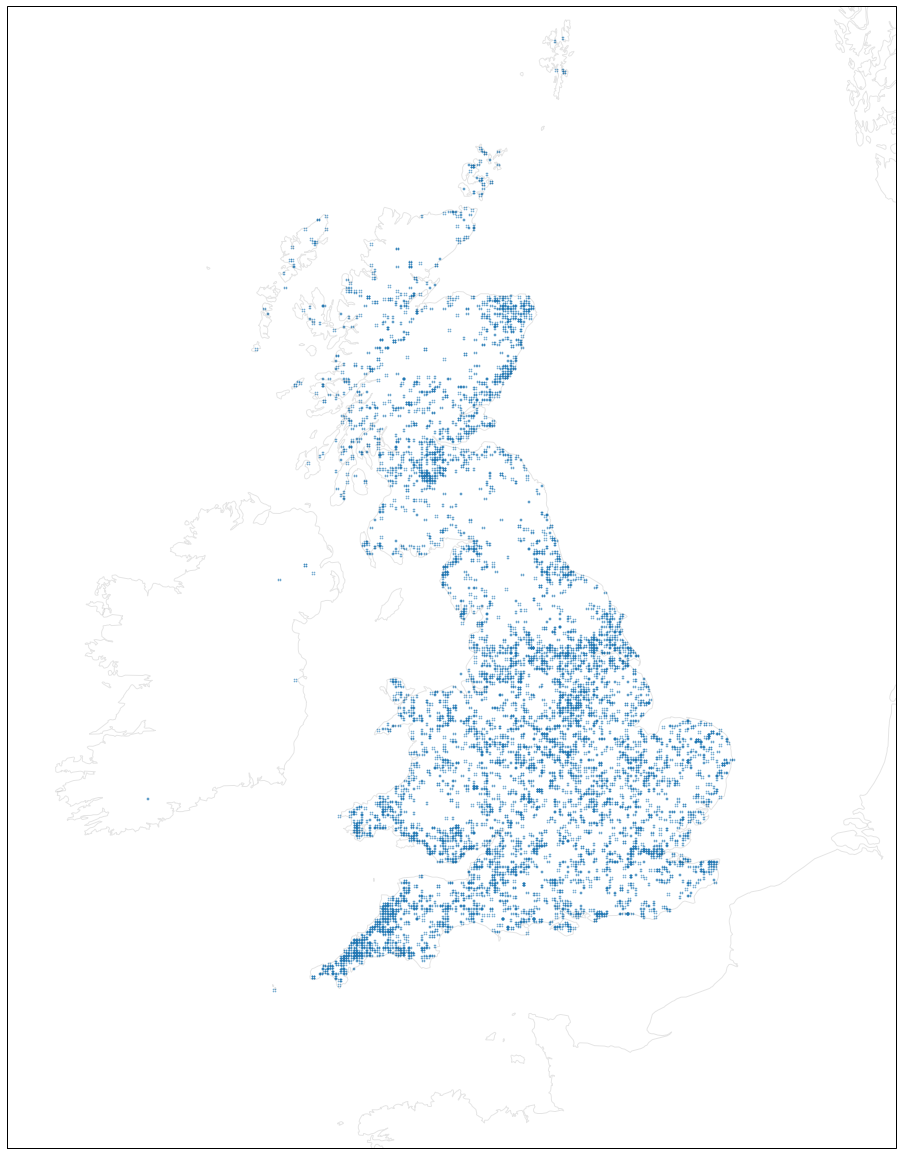

In [10]:
fig = plt.figure(figsize=(25, 21))
ax = plt.axes(projection=UKVDomain())
ax.scatter(mpan_4_corners['easting'], mpan_4_corners['northing'], s=0.5, alpha=0.5)
ax.set_global()
ax.coastlines(resolution='10m', alpha=0.1);

In [11]:
def northing_easting_to_index(northing: np.ndarray, easting: np.ndarray) -> pd.DataFrame:
    # Sanity check
    def _sanity_check(legal_values, test_array):
        if any(test_array < legal_values.min()) or any(test_array > legal_values.max()):
            raise ValueError('Value out of bounds')            
    _sanity_check(NORTHING, northing)
    _sanity_check(EASTING, easting)
    assert len(northing) == len(easting)

    northing_index = np.searchsorted(NORTHING, northing)
    easting_index = np.searchsorted(EASTING, easting)
    return pd.DataFrame(
        {
            'northing_index': northing_index, 
            'easting_index': easting_index
        },
        index=range(len(northing_index)))


# Test :)
np.testing.assert_array_equal(
    northing_easting_to_index(
        northing=np.array([NORTHING[0]]), 
        easting=np.array([EASTING[303]])).values[0],
    (0, 303))

In [12]:
def northing_easting_index_to_1d_grib_index(northing_index: np.ndarray, easting_index: np.ndarray) -> np.ndarray:
    # Sanity check
    if any(northing_index < 0) or any(northing_index >= NUM_ROWS):
        raise ValueError('northing_index out of bounds')
    if any(easting_index < 0) or any(easting_index >= NUM_COLS):
        raise ValueError('easting_index out of bounds')
        
    # The rows are upside-down in original grib file
    last_row_index = NUM_ROWS - 1
    northing_index_flipped = last_row_index - northing_index
    return (northing_index_flipped * NUM_COLS) + easting_index


northing_easting_index_to_1d_grib_index(
    np.array([NUM_ROWS-1, 0, NUM_ROWS-1,          0]), 
    np.array([NUM_COLS-1, 0,          0, NUM_COLS-1]))

array([   547, 385244,      0, 385791])

In [13]:
osgb_index = northing_easting_to_index(
    northing=mpan_4_corners.northing,
    easting=mpan_4_corners.easting)

osgb_index.head()

northing_index  easting_index
0             194            397
1             193            398
2             193            397
3             194            398
4             245            438

In [14]:
grib_index = northing_easting_index_to_1d_grib_index(
    northing_index=osgb_index.northing_index,
    easting_index=osgb_index.easting_index).values

'{:,d}'.format(len(grib_index))

'25,304'

In [15]:
grib_index = np.unique(grib_index)
grib_index = np.sort(grib_index)
grib_index = np.int32(grib_index)
'{:,d}'.format(len(grib_index))

'15,559'

# Load Wholesale1 files

## Create empty data array

In [16]:
def get_empty_data_array():
    coords = (
        ('init_time', pd.date_range(START_DATE, END_DATE, freq='3H')),
        ('forecast_hour', range(37)),
        ('grib_index', grib_index),
        ('variable_name', ['wind_speed', 'wind_direction']))

    shape = [len(coord[1]) for coord in coords]
    data = np.full(shape, fill_value=np.NaN, dtype=np.float32)
    return xr.DataArray(data, coords=coords)

data_array = get_empty_data_array()

## Load GRIB files

Variable names in wholesale1
* r = relative humidity
* t = temperature
* dpt = dew point temperature
* vis = visability
* si10 = 10 metre wind speed, m/s
* wdir10 = 10 metre wind direction, Degree true
* prmsl = Pressure reduced to MSL
* prate = Precipitation rate

In [17]:
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2019/08/29/201908290000_u1096_ng_umqv_Wholesale1.grib'
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib'
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2015/06/01/prodm_op_ukv_20150601_03_000.pp'

In [18]:
filenames = glob.glob('/storage/data/uk_met_office/UKV/*/*/*/*Wholesale1.grib')
filenames.sort()

In [19]:
len(filenames)

8603

In [20]:
filenames[:10]

['/storage/data/uk_met_office/UKV/2016/03/22/201603221500_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/22/201603221800_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/22/201603222100_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230000_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230300_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230600_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230900_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603231200_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603231500_u1096_ng_umqv_Wholesale1.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603231800_u1096_ng_umqv_Wholesale1.grib']

In [21]:
def load_grib_dataset(filename):
    ds = cfgrib.open_dataset(
        filename,
        # Wind direction and wind speed are the only variables which are at 
        # 10 meters above ground in the UKV GRIB files.
        backend_kwargs={'filter_by_keys': {'level': 10}})

    # Check this dataset only contains wind speed and wind direction
    assert 'si10' in ds
    assert 'wdir10' in ds
    assert len(ds) == 2
    return ds

TODO: Capture stderr.  See [stackoverflow](https://stackoverflow.com/questions/34145950/is-there-a-way-to-redirect-stderr-to-file-in-jupyter).

In [22]:
%%time
n = len(filenames)
for i, filename in enumerate(filenames):
    print('\r', i, 'of', n, ':', filename, end='', flush=True)
    ds = load_grib_dataset(filename)
    
    wind_speed = ds['si10'][:, grib_index]
    wind_direction = ds['wdir10'][:, grib_index]

    try:
        data_array.loc[wind_speed.time.values, :, :, 'wind_speed'] = wind_speed.values
        data_array.loc[wind_direction.time.values, :, :, 'wind_direction'] = wind_direction.values
    except KeyError as e:  # nasty hack for detecting when we get to the end!
        print("Finished!", e)
        break

 0 of 8603 : /storage/data/uk_met_office/UKV/2016/03/22/201603221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1 of 8603 : /storage/data/uk_met_office/UKV/2016/03/22/201603221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2 of 8603 : /storage/data/uk_met_office/UKV/2016/03/22/201603222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 6 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 7 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 8 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 9 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 10 of 8603 : /storage/data/uk_met_office/UKV/2016/03/23/201603232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 11 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 12 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 13 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 14 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 15 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 16 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 17 of 8603 : /storage/data/uk_met_office/UKV/2016/03/24/201603242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 18 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 19 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 20 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 21 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 22 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 23 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 24 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 25 of 8603 : /storage/data/uk_met_office/UKV/2016/03/25/201603252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 26 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 27 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 28 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 29 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 30 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 31 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 32 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 33 of 8603 : /storage/data/uk_met_office/UKV/2016/03/26/201603262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 34 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 35 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 36 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 37 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 38 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 39 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 40 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 41 of 8603 : /storage/data/uk_met_office/UKV/2016/03/27/201603272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 42 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 43 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 44 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 45 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 46 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 47 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 48 of 8603 : /storage/data/uk_met_office/UKV/2016/03/28/201603281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 49 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 50 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 51 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 52 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 53 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 54 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 55 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 56 of 8603 : /storage/data/uk_met_office/UKV/2016/03/29/201603292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 57 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 58 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 59 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 60 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 61 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 62 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 63 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 64 of 8603 : /storage/data/uk_met_office/UKV/2016/03/30/201603302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 65 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 66 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 67 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 68 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 69 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 70 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 71 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 72 of 8603 : /storage/data/uk_met_office/UKV/2016/03/31/201603312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 73 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 74 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 75 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 76 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 77 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 78 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 79 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 80 of 8603 : /storage/data/uk_met_office/UKV/2016/04/01/201604012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 81 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 82 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 83 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 84 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 85 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 86 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 87 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 88 of 8603 : /storage/data/uk_met_office/UKV/2016/04/02/201604022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 89 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 90 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 91 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 92 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 93 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 94 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 95 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 96 of 8603 : /storage/data/uk_met_office/UKV/2016/04/03/201604032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 97 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 98 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 99 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 100 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 101 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 102 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 103 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 104 of 8603 : /storage/data/uk_met_office/UKV/2016/04/04/201604042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 105 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 106 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 107 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 108 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 109 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 110 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 111 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 112 of 8603 : /storage/data/uk_met_office/UKV/2016/04/05/201604052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 113 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 114 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 115 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 116 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 117 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 118 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 119 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 120 of 8603 : /storage/data/uk_met_office/UKV/2016/04/06/201604062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 121 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 122 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 123 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 124 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 125 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 126 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 127 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 128 of 8603 : /storage/data/uk_met_office/UKV/2016/04/07/201604072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 129 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 130 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 131 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 132 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 133 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 134 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 135 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 136 of 8603 : /storage/data/uk_met_office/UKV/2016/04/08/201604082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 137 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 138 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 139 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 140 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 141 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 142 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 143 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 144 of 8603 : /storage/data/uk_met_office/UKV/2016/04/09/201604092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 145 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 146 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 147 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 148 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 149 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 150 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 151 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 152 of 8603 : /storage/data/uk_met_office/UKV/2016/04/10/201604102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 153 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 154 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 155 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 156 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 157 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 158 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 159 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 160 of 8603 : /storage/data/uk_met_office/UKV/2016/04/11/201604112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 161 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 162 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 163 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 164 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 165 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 166 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 167 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 168 of 8603 : /storage/data/uk_met_office/UKV/2016/04/12/201604122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 169 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 170 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 171 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 172 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 173 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 174 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 175 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 176 of 8603 : /storage/data/uk_met_office/UKV/2016/04/13/201604132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 177 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 178 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 179 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 180 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 181 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 182 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 183 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 184 of 8603 : /storage/data/uk_met_office/UKV/2016/04/14/201604142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 185 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 186 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 187 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 188 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 189 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 190 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 191 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 192 of 8603 : /storage/data/uk_met_office/UKV/2016/04/15/201604152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 193 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 194 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 195 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 196 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 197 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 198 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 199 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 200 of 8603 : /storage/data/uk_met_office/UKV/2016/04/16/201604162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 201 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 202 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 203 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 204 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 205 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 206 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 207 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 208 of 8603 : /storage/data/uk_met_office/UKV/2016/04/17/201604172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 209 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 210 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 211 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 212 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 213 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 214 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 215 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 216 of 8603 : /storage/data/uk_met_office/UKV/2016/04/18/201604182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 217 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 218 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 219 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 220 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 221 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 222 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 223 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 224 of 8603 : /storage/data/uk_met_office/UKV/2016/04/19/201604192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 225 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 226 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 227 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 228 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 229 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 230 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 231 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 232 of 8603 : /storage/data/uk_met_office/UKV/2016/04/20/201604202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 233 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 234 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 235 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 236 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 237 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 238 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 239 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 240 of 8603 : /storage/data/uk_met_office/UKV/2016/04/21/201604212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 241 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 242 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 243 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 244 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 245 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 246 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 247 of 8603 : /storage/data/uk_met_office/UKV/2016/04/22/201604222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 248 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 249 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 250 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 251 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 252 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 253 of 8603 : /storage/data/uk_met_office/UKV/2016/04/23/201604232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 254 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 255 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 256 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 257 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 258 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 259 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 260 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 261 of 8603 : /storage/data/uk_met_office/UKV/2016/04/24/201604242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 262 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 263 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 264 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 265 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 266 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 267 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 268 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 269 of 8603 : /storage/data/uk_met_office/UKV/2016/04/25/201604252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 270 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 271 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 272 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 273 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 274 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 275 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 276 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 277 of 8603 : /storage/data/uk_met_office/UKV/2016/04/26/201604262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 278 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 279 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 280 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 281 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 282 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 283 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 284 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 285 of 8603 : /storage/data/uk_met_office/UKV/2016/04/27/201604272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 286 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 287 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 288 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 289 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 290 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 291 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 292 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 293 of 8603 : /storage/data/uk_met_office/UKV/2016/04/28/201604282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 294 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 295 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 296 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 297 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 298 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 299 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 300 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 301 of 8603 : /storage/data/uk_met_office/UKV/2016/04/29/201604292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 302 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 303 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 304 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 305 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 306 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 307 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 308 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 309 of 8603 : /storage/data/uk_met_office/UKV/2016/04/30/201604302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 310 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 311 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 312 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 313 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 314 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 315 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 316 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 317 of 8603 : /storage/data/uk_met_office/UKV/2016/05/01/201605012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 318 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 319 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 320 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 321 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 322 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 323 of 8603 : /storage/data/uk_met_office/UKV/2016/05/02/201605022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 324 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 325 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 326 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 327 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 328 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 329 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 330 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 331 of 8603 : /storage/data/uk_met_office/UKV/2016/05/03/201605032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 332 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 333 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 334 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 335 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 336 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 337 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 338 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 339 of 8603 : /storage/data/uk_met_office/UKV/2016/05/04/201605042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 340 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 341 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 342 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 343 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 344 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 345 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 346 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 347 of 8603 : /storage/data/uk_met_office/UKV/2016/05/05/201605052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 348 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 349 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 350 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 351 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 352 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 353 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 354 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 355 of 8603 : /storage/data/uk_met_office/UKV/2016/05/06/201605062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 356 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 357 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 358 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 359 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 360 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 361 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 362 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 363 of 8603 : /storage/data/uk_met_office/UKV/2016/05/07/201605072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 364 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 365 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 366 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 367 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 368 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 369 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 370 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 371 of 8603 : /storage/data/uk_met_office/UKV/2016/05/08/201605082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 372 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 373 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 374 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 375 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 376 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 377 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 378 of 8603 : /storage/data/uk_met_office/UKV/2016/05/09/201605092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 379 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 380 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 381 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 382 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 383 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 384 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 385 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 386 of 8603 : /storage/data/uk_met_office/UKV/2016/05/10/201605102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 387 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 388 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 389 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 390 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 391 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 392 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 393 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 394 of 8603 : /storage/data/uk_met_office/UKV/2016/05/11/201605112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 395 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 396 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 397 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 398 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 399 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 400 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 401 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 402 of 8603 : /storage/data/uk_met_office/UKV/2016/05/12/201605122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 403 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 404 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 405 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 406 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 407 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 408 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 409 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 410 of 8603 : /storage/data/uk_met_office/UKV/2016/05/13/201605132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 411 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 412 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 413 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 414 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 415 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 416 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 417 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 418 of 8603 : /storage/data/uk_met_office/UKV/2016/05/14/201605142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 419 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 420 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 421 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 422 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 423 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 424 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 425 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 426 of 8603 : /storage/data/uk_met_office/UKV/2016/05/15/201605152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 427 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 428 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 429 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 430 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 431 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 432 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 433 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 434 of 8603 : /storage/data/uk_met_office/UKV/2016/05/16/201605162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 435 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 436 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 437 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 438 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 439 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 440 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 441 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 442 of 8603 : /storage/data/uk_met_office/UKV/2016/05/17/201605172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 443 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 444 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 445 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 446 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 447 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 448 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 449 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 450 of 8603 : /storage/data/uk_met_office/UKV/2016/05/18/201605182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 451 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 452 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 453 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 454 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 455 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 456 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 457 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 458 of 8603 : /storage/data/uk_met_office/UKV/2016/05/19/201605192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 459 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 460 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 461 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 462 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 463 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 464 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 465 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 466 of 8603 : /storage/data/uk_met_office/UKV/2016/05/20/201605202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 467 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 468 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 469 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 470 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 471 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 472 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 473 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 474 of 8603 : /storage/data/uk_met_office/UKV/2016/05/21/201605212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 475 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 476 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 477 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 478 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 479 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 480 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 481 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 482 of 8603 : /storage/data/uk_met_office/UKV/2016/05/22/201605222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 483 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 484 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 485 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 486 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 487 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 488 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 489 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 490 of 8603 : /storage/data/uk_met_office/UKV/2016/05/23/201605232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 491 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 492 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 493 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 494 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 495 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 496 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 497 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 498 of 8603 : /storage/data/uk_met_office/UKV/2016/05/24/201605242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 499 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 500 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 501 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 502 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 503 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 504 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 505 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 506 of 8603 : /storage/data/uk_met_office/UKV/2016/05/25/201605252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 507 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 508 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 509 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 510 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 511 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 512 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 513 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 514 of 8603 : /storage/data/uk_met_office/UKV/2016/05/26/201605262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 515 of 8603 : /storage/data/uk_met_office/UKV/2016/05/27/201605270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 516 of 8603 : /storage/data/uk_met_office/UKV/2016/05/27/201605270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 517 of 8603 : /storage/data/uk_met_office/UKV/2016/05/27/201605270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 518 of 8603 : /storage/data/uk_met_office/UKV/2016/05/27/201605271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 519 of 8603 : /storage/data/uk_met_office/UKV/2016/05/27/201605272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 520 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 521 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 522 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 523 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 524 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 525 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 526 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 527 of 8603 : /storage/data/uk_met_office/UKV/2016/05/28/201605282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 528 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 529 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 530 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 531 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 532 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 533 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 534 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 535 of 8603 : /storage/data/uk_met_office/UKV/2016/05/29/201605292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 536 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 537 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 538 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 539 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 540 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 541 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 542 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 543 of 8603 : /storage/data/uk_met_office/UKV/2016/05/30/201605302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 544 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 545 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 546 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 547 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 548 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 549 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 550 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 551 of 8603 : /storage/data/uk_met_office/UKV/2016/05/31/201605312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 552 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 553 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 554 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 555 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 556 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 557 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 558 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 559 of 8603 : /storage/data/uk_met_office/UKV/2016/06/01/201606012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 560 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 561 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 562 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 563 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 564 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 565 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 566 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 567 of 8603 : /storage/data/uk_met_office/UKV/2016/06/02/201606022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 568 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 569 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 570 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 571 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 572 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 573 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 574 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 575 of 8603 : /storage/data/uk_met_office/UKV/2016/06/03/201606032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 576 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 577 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 578 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 579 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 580 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 581 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 582 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 583 of 8603 : /storage/data/uk_met_office/UKV/2016/06/04/201606042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 584 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 585 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 586 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 587 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 588 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 589 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 590 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 591 of 8603 : /storage/data/uk_met_office/UKV/2016/06/05/201606052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 592 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 593 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 594 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 595 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 596 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 597 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 598 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 599 of 8603 : /storage/data/uk_met_office/UKV/2016/06/06/201606062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 600 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 601 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 602 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 603 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 604 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 605 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 606 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 607 of 8603 : /storage/data/uk_met_office/UKV/2016/06/07/201606072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 608 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 609 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 610 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 611 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 612 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 613 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 614 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 615 of 8603 : /storage/data/uk_met_office/UKV/2016/06/08/201606082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 616 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 617 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 618 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 619 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 620 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 621 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 622 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 623 of 8603 : /storage/data/uk_met_office/UKV/2016/06/09/201606092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 624 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 625 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 626 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 627 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 628 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 629 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 630 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 631 of 8603 : /storage/data/uk_met_office/UKV/2016/06/10/201606102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 632 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 633 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 634 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 635 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 636 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 637 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 638 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 639 of 8603 : /storage/data/uk_met_office/UKV/2016/06/11/201606112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 640 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 641 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 642 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 643 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 644 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 645 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 646 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 647 of 8603 : /storage/data/uk_met_office/UKV/2016/06/12/201606122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 648 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 649 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 650 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 651 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 652 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 653 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 654 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 655 of 8603 : /storage/data/uk_met_office/UKV/2016/06/13/201606132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 656 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 657 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 658 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 659 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 660 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 661 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 662 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 663 of 8603 : /storage/data/uk_met_office/UKV/2016/06/14/201606142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 664 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 665 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 666 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 667 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 668 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 669 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 670 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 671 of 8603 : /storage/data/uk_met_office/UKV/2016/06/15/201606152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 672 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 673 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 674 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 675 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 676 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 677 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 678 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 679 of 8603 : /storage/data/uk_met_office/UKV/2016/06/16/201606162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 680 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 681 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 682 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 683 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 684 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 685 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 686 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 687 of 8603 : /storage/data/uk_met_office/UKV/2016/06/17/201606172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 688 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 689 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 690 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 691 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 692 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 693 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 694 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 695 of 8603 : /storage/data/uk_met_office/UKV/2016/06/18/201606182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 696 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 697 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 698 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 699 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 700 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 701 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 702 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 703 of 8603 : /storage/data/uk_met_office/UKV/2016/06/19/201606192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 704 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 705 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 706 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 707 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 708 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 709 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 710 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 711 of 8603 : /storage/data/uk_met_office/UKV/2016/06/20/201606202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 712 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 713 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 714 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 715 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 716 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 717 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 718 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 719 of 8603 : /storage/data/uk_met_office/UKV/2016/06/21/201606212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 720 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 721 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 722 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 723 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 724 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 725 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 726 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 727 of 8603 : /storage/data/uk_met_office/UKV/2016/06/22/201606222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 728 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 729 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 730 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 731 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 732 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 733 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 734 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 735 of 8603 : /storage/data/uk_met_office/UKV/2016/06/23/201606232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 736 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 737 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 738 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 739 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 740 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 741 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 742 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 743 of 8603 : /storage/data/uk_met_office/UKV/2016/06/24/201606242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 744 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 745 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 746 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 747 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 748 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 749 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 750 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 751 of 8603 : /storage/data/uk_met_office/UKV/2016/06/25/201606252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 752 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 753 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 754 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 755 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 756 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 757 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 758 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 759 of 8603 : /storage/data/uk_met_office/UKV/2016/06/26/201606262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 760 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 761 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 762 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 763 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 764 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 765 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 766 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 767 of 8603 : /storage/data/uk_met_office/UKV/2016/06/27/201606272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 768 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 769 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 770 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 771 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 772 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 773 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 774 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 775 of 8603 : /storage/data/uk_met_office/UKV/2016/06/28/201606282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 776 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 777 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 778 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 779 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 780 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 781 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 782 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 783 of 8603 : /storage/data/uk_met_office/UKV/2016/06/29/201606292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 784 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 785 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 786 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 787 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 788 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 789 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 790 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 791 of 8603 : /storage/data/uk_met_office/UKV/2016/06/30/201606302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 792 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 793 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 794 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 795 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 796 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 797 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 798 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 799 of 8603 : /storage/data/uk_met_office/UKV/2016/07/01/201607012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 800 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 801 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 802 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 803 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 804 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 805 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 806 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 807 of 8603 : /storage/data/uk_met_office/UKV/2016/07/02/201607022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 808 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 809 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 810 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 811 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 812 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 813 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 814 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 815 of 8603 : /storage/data/uk_met_office/UKV/2016/07/03/201607032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 816 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 817 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 818 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 819 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 820 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 821 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 822 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 823 of 8603 : /storage/data/uk_met_office/UKV/2016/07/04/201607042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 824 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 825 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 826 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 827 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 828 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 829 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 830 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 831 of 8603 : /storage/data/uk_met_office/UKV/2016/07/05/201607052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 832 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 833 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 834 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 835 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 836 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 837 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 838 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 839 of 8603 : /storage/data/uk_met_office/UKV/2016/07/06/201607062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 840 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 841 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 842 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 843 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 844 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 845 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 846 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 847 of 8603 : /storage/data/uk_met_office/UKV/2016/07/07/201607072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 848 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 849 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 850 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 851 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 852 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 853 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 854 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 855 of 8603 : /storage/data/uk_met_office/UKV/2016/07/08/201607082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 856 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 857 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 858 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 859 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 860 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 861 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 862 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 863 of 8603 : /storage/data/uk_met_office/UKV/2016/07/09/201607092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 864 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 865 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 866 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 867 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 868 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 869 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 870 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 871 of 8603 : /storage/data/uk_met_office/UKV/2016/07/10/201607102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 872 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 873 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 874 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 875 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 876 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 877 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 878 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 879 of 8603 : /storage/data/uk_met_office/UKV/2016/07/11/201607112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 880 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 881 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 882 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 883 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 884 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 885 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 886 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 887 of 8603 : /storage/data/uk_met_office/UKV/2016/07/12/201607122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 888 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 889 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 890 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 891 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 892 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 893 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 894 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 895 of 8603 : /storage/data/uk_met_office/UKV/2016/07/13/201607132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 896 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 897 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 898 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 899 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 900 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 901 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 902 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 903 of 8603 : /storage/data/uk_met_office/UKV/2016/07/14/201607142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 904 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 905 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 906 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 907 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 908 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 909 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 910 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 911 of 8603 : /storage/data/uk_met_office/UKV/2016/07/15/201607152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 912 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 913 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 914 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 915 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 916 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 917 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 918 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 919 of 8603 : /storage/data/uk_met_office/UKV/2016/07/16/201607162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 920 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 921 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 922 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 923 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 924 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 925 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 926 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 927 of 8603 : /storage/data/uk_met_office/UKV/2016/07/17/201607172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 928 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 929 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 930 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 931 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 932 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 933 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 934 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 935 of 8603 : /storage/data/uk_met_office/UKV/2016/07/18/201607182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 936 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 937 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 938 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 939 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 940 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 941 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 942 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 943 of 8603 : /storage/data/uk_met_office/UKV/2016/07/19/201607192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 944 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 945 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 946 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 947 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 948 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 949 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 950 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 951 of 8603 : /storage/data/uk_met_office/UKV/2016/07/20/201607202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 952 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 953 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 954 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 955 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 956 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 957 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 958 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 959 of 8603 : /storage/data/uk_met_office/UKV/2016/07/21/201607212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 960 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 961 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 962 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 963 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 964 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 965 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 966 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 967 of 8603 : /storage/data/uk_met_office/UKV/2016/07/22/201607222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 968 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 969 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 970 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 971 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 972 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 973 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 974 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 975 of 8603 : /storage/data/uk_met_office/UKV/2016/07/23/201607232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 976 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 977 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 978 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 979 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 980 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 981 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 982 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 983 of 8603 : /storage/data/uk_met_office/UKV/2016/07/24/201607242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 984 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 985 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 986 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 987 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 988 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 989 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 990 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 991 of 8603 : /storage/data/uk_met_office/UKV/2016/07/25/201607252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 992 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 993 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 994 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 995 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 996 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 997 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 998 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 999 of 8603 : /storage/data/uk_met_office/UKV/2016/07/26/201607262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1000 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1001 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1002 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1003 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1004 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1005 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1006 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1007 of 8603 : /storage/data/uk_met_office/UKV/2016/07/27/201607272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1008 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1009 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1010 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1011 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1012 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1013 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1014 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1015 of 8603 : /storage/data/uk_met_office/UKV/2016/07/28/201607282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1016 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1017 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1018 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1019 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1020 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1021 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1022 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1023 of 8603 : /storage/data/uk_met_office/UKV/2016/07/29/201607292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1024 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1025 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1026 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1027 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1028 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1029 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1030 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1031 of 8603 : /storage/data/uk_met_office/UKV/2016/07/30/201607302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1032 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1033 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1034 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1035 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1036 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1037 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1038 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1039 of 8603 : /storage/data/uk_met_office/UKV/2016/07/31/201607312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1040 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1041 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1042 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1043 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1044 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1045 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1046 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1047 of 8603 : /storage/data/uk_met_office/UKV/2016/08/01/201608012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1048 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1049 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1050 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1051 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1052 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1053 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1054 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1055 of 8603 : /storage/data/uk_met_office/UKV/2016/08/02/201608022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1056 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1057 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1058 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1059 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1060 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1061 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1062 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1063 of 8603 : /storage/data/uk_met_office/UKV/2016/08/03/201608032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1064 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1065 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1066 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1067 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1068 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1069 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1070 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1071 of 8603 : /storage/data/uk_met_office/UKV/2016/08/04/201608042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1072 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1073 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1074 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1075 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1076 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1077 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1078 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1079 of 8603 : /storage/data/uk_met_office/UKV/2016/08/05/201608052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1080 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1081 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1082 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1083 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1084 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1085 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1086 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1087 of 8603 : /storage/data/uk_met_office/UKV/2016/08/06/201608062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1088 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1089 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1090 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1091 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1092 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1093 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1094 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1095 of 8603 : /storage/data/uk_met_office/UKV/2016/08/07/201608072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1096 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1097 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1098 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1099 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1100 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1101 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1102 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1103 of 8603 : /storage/data/uk_met_office/UKV/2016/08/08/201608082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1104 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1105 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1106 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1107 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1108 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1109 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1110 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1111 of 8603 : /storage/data/uk_met_office/UKV/2016/08/09/201608092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1112 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1113 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1114 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1115 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1116 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1117 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1118 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1119 of 8603 : /storage/data/uk_met_office/UKV/2016/08/10/201608102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1120 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1121 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1122 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1123 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1124 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1125 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1126 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1127 of 8603 : /storage/data/uk_met_office/UKV/2016/08/11/201608112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1128 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1129 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1130 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1131 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1132 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1133 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1134 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1135 of 8603 : /storage/data/uk_met_office/UKV/2016/08/12/201608122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1136 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1137 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1138 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1139 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1140 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1141 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1142 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1143 of 8603 : /storage/data/uk_met_office/UKV/2016/08/13/201608132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1144 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1145 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1146 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1147 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1148 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1149 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1150 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1151 of 8603 : /storage/data/uk_met_office/UKV/2016/08/14/201608142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1152 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1153 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1154 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1155 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1156 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1157 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1158 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1159 of 8603 : /storage/data/uk_met_office/UKV/2016/08/15/201608152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1160 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1161 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1162 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1163 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1164 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1165 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1166 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1167 of 8603 : /storage/data/uk_met_office/UKV/2016/08/16/201608162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1168 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1169 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1170 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1171 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1172 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1173 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1174 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1175 of 8603 : /storage/data/uk_met_office/UKV/2016/08/17/201608172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1176 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1177 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1178 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1179 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1180 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1181 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1182 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1183 of 8603 : /storage/data/uk_met_office/UKV/2016/08/18/201608182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1184 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1185 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1186 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1187 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1188 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1189 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1190 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1191 of 8603 : /storage/data/uk_met_office/UKV/2016/08/19/201608192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1192 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1193 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1194 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1195 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1196 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1197 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1198 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1199 of 8603 : /storage/data/uk_met_office/UKV/2016/08/20/201608202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1200 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1201 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1202 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1203 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1204 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1205 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1206 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1207 of 8603 : /storage/data/uk_met_office/UKV/2016/08/21/201608212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1208 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1209 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1210 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1211 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1212 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1213 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1214 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1215 of 8603 : /storage/data/uk_met_office/UKV/2016/08/22/201608222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1216 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1217 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1218 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1219 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1220 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1221 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1222 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1223 of 8603 : /storage/data/uk_met_office/UKV/2016/08/23/201608232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1224 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1225 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1226 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1227 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1228 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1229 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1230 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1231 of 8603 : /storage/data/uk_met_office/UKV/2016/08/24/201608242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1232 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1233 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1234 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1235 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1236 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1237 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1238 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1239 of 8603 : /storage/data/uk_met_office/UKV/2016/08/25/201608252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1240 of 8603 : /storage/data/uk_met_office/UKV/2016/08/26/201608260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1241 of 8603 : /storage/data/uk_met_office/UKV/2016/08/26/201608260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1242 of 8603 : /storage/data/uk_met_office/UKV/2016/08/26/201608261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1243 of 8603 : /storage/data/uk_met_office/UKV/2016/08/26/201608262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1244 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1245 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1246 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1247 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1248 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1249 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1250 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1251 of 8603 : /storage/data/uk_met_office/UKV/2016/08/27/201608272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1252 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1253 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1254 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1255 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1256 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1257 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1258 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1259 of 8603 : /storage/data/uk_met_office/UKV/2016/08/28/201608282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1260 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1261 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1262 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1263 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1264 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1265 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1266 of 8603 : /storage/data/uk_met_office/UKV/2016/08/29/201608292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1267 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1268 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1269 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1270 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1271 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1272 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1273 of 8603 : /storage/data/uk_met_office/UKV/2016/08/30/201608302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1274 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1275 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1276 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1277 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1278 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1279 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1280 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1281 of 8603 : /storage/data/uk_met_office/UKV/2016/08/31/201608312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1282 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1283 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1284 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1285 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1286 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1287 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1288 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1289 of 8603 : /storage/data/uk_met_office/UKV/2016/09/01/201609012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1290 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1291 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1292 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1293 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1294 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1295 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1296 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1297 of 8603 : /storage/data/uk_met_office/UKV/2016/09/02/201609022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1298 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1299 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1300 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1301 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1302 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1303 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1304 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1305 of 8603 : /storage/data/uk_met_office/UKV/2016/09/03/201609032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1306 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1307 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1308 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1309 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1310 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1311 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1312 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1313 of 8603 : /storage/data/uk_met_office/UKV/2016/09/04/201609042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1314 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1315 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1316 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1317 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1318 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1319 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1320 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1321 of 8603 : /storage/data/uk_met_office/UKV/2016/09/05/201609052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1322 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1323 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1324 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1325 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1326 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1327 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1328 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1329 of 8603 : /storage/data/uk_met_office/UKV/2016/09/06/201609062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1330 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1331 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1332 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1333 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1334 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1335 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1336 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1337 of 8603 : /storage/data/uk_met_office/UKV/2016/09/07/201609072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1338 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1339 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1340 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1341 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1342 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1343 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1344 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1345 of 8603 : /storage/data/uk_met_office/UKV/2016/09/08/201609082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1346 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1347 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1348 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1349 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1350 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1351 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1352 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1353 of 8603 : /storage/data/uk_met_office/UKV/2016/09/09/201609092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1354 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1355 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1356 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1357 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1358 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1359 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1360 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1361 of 8603 : /storage/data/uk_met_office/UKV/2016/09/10/201609102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1362 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1363 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1364 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1365 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1366 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1367 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1368 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1369 of 8603 : /storage/data/uk_met_office/UKV/2016/09/11/201609112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1370 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1371 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1372 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1373 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1374 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1375 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1376 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1377 of 8603 : /storage/data/uk_met_office/UKV/2016/09/12/201609122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1378 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1379 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1380 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1381 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1382 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1383 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1384 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1385 of 8603 : /storage/data/uk_met_office/UKV/2016/09/13/201609132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1386 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1387 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1388 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1389 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1390 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1391 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1392 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1393 of 8603 : /storage/data/uk_met_office/UKV/2016/09/14/201609142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1394 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1395 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1396 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1397 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1398 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1399 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1400 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1401 of 8603 : /storage/data/uk_met_office/UKV/2016/09/15/201609152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1402 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1403 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1404 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1405 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1406 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1407 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1408 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1409 of 8603 : /storage/data/uk_met_office/UKV/2016/09/16/201609162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1410 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1411 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1412 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1413 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1414 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1415 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1416 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1417 of 8603 : /storage/data/uk_met_office/UKV/2016/09/17/201609172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1418 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1419 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1420 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1421 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1422 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1423 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1424 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1425 of 8603 : /storage/data/uk_met_office/UKV/2016/09/18/201609182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1426 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1427 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1428 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1429 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1430 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1431 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1432 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1433 of 8603 : /storage/data/uk_met_office/UKV/2016/09/19/201609192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1434 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1435 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1436 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1437 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1438 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1439 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1440 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1441 of 8603 : /storage/data/uk_met_office/UKV/2016/09/20/201609202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1442 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1443 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1444 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1445 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1446 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1447 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1448 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1449 of 8603 : /storage/data/uk_met_office/UKV/2016/09/21/201609212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1450 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1451 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1452 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1453 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1454 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1455 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1456 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1457 of 8603 : /storage/data/uk_met_office/UKV/2016/09/22/201609222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1458 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1459 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1460 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1461 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1462 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1463 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1464 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1465 of 8603 : /storage/data/uk_met_office/UKV/2016/09/23/201609232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1466 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1467 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1468 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1469 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1470 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1471 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1472 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1473 of 8603 : /storage/data/uk_met_office/UKV/2016/09/24/201609242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1474 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1475 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1476 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1477 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1478 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1479 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1480 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1481 of 8603 : /storage/data/uk_met_office/UKV/2016/09/25/201609252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1482 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1483 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1484 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1485 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1486 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1487 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1488 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1489 of 8603 : /storage/data/uk_met_office/UKV/2016/09/26/201609262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1490 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1491 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1492 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1493 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1494 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1495 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1496 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1497 of 8603 : /storage/data/uk_met_office/UKV/2016/09/27/201609272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1498 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1499 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1500 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1501 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1502 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1503 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1504 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1505 of 8603 : /storage/data/uk_met_office/UKV/2016/09/28/201609282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1506 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1507 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1508 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1509 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1510 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1511 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1512 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1513 of 8603 : /storage/data/uk_met_office/UKV/2016/09/29/201609292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1514 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1515 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1516 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1517 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1518 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1519 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1520 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1521 of 8603 : /storage/data/uk_met_office/UKV/2016/09/30/201609302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1522 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1523 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1524 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1525 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1526 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1527 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1528 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1529 of 8603 : /storage/data/uk_met_office/UKV/2016/10/01/201610012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1530 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1531 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1532 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1533 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1534 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1535 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1536 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1537 of 8603 : /storage/data/uk_met_office/UKV/2016/10/02/201610022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1538 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1539 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1540 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1541 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1542 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1543 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1544 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1545 of 8603 : /storage/data/uk_met_office/UKV/2016/10/03/201610032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1546 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1547 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1548 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1549 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1550 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1551 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1552 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1553 of 8603 : /storage/data/uk_met_office/UKV/2016/10/04/201610042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1554 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1555 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1556 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1557 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1558 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1559 of 8603 : /storage/data/uk_met_office/UKV/2016/10/05/201610052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1560 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1561 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1562 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1563 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1564 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1565 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1566 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1567 of 8603 : /storage/data/uk_met_office/UKV/2016/10/06/201610062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1568 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1569 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1570 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1571 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1572 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1573 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1574 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1575 of 8603 : /storage/data/uk_met_office/UKV/2016/10/07/201610072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1576 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1577 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1578 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1579 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1580 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1581 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1582 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1583 of 8603 : /storage/data/uk_met_office/UKV/2016/10/08/201610082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1584 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1585 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1586 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1587 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1588 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1589 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1590 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1591 of 8603 : /storage/data/uk_met_office/UKV/2016/10/09/201610092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1592 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1593 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1594 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1595 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1596 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1597 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1598 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1599 of 8603 : /storage/data/uk_met_office/UKV/2016/10/10/201610102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1600 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1601 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1602 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1603 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1604 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1605 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1606 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1607 of 8603 : /storage/data/uk_met_office/UKV/2016/10/11/201610112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1608 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1609 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1610 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1611 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1612 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1613 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1614 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1615 of 8603 : /storage/data/uk_met_office/UKV/2016/10/12/201610122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1616 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1617 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1618 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1619 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1620 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1621 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1622 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1623 of 8603 : /storage/data/uk_met_office/UKV/2016/10/13/201610132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1624 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1625 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1626 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1627 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1628 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1629 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1630 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1631 of 8603 : /storage/data/uk_met_office/UKV/2016/10/14/201610142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1632 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1633 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1634 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1635 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1636 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1637 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1638 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1639 of 8603 : /storage/data/uk_met_office/UKV/2016/10/15/201610152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1640 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1641 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1642 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1643 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1644 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1645 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1646 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1647 of 8603 : /storage/data/uk_met_office/UKV/2016/10/16/201610162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1648 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1649 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1650 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1651 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1652 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1653 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1654 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1655 of 8603 : /storage/data/uk_met_office/UKV/2016/10/17/201610172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1656 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1657 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1658 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1659 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1660 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1661 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1662 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1663 of 8603 : /storage/data/uk_met_office/UKV/2016/10/18/201610182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1664 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1665 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1666 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1667 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1668 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1669 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1670 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1671 of 8603 : /storage/data/uk_met_office/UKV/2016/10/19/201610192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1672 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1673 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1674 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1675 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1676 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1677 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1678 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1679 of 8603 : /storage/data/uk_met_office/UKV/2016/10/20/201610202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1680 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1681 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1682 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1683 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1684 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1685 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1686 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1687 of 8603 : /storage/data/uk_met_office/UKV/2016/10/21/201610212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1688 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1689 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1690 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1691 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1692 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1693 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1694 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1695 of 8603 : /storage/data/uk_met_office/UKV/2016/10/22/201610222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1696 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1697 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1698 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1699 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1700 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1701 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1702 of 8603 : /storage/data/uk_met_office/UKV/2016/10/23/201610232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1703 of 8603 : /storage/data/uk_met_office/UKV/2016/10/24/201610240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1704 of 8603 : /storage/data/uk_met_office/UKV/2016/10/24/201610240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1705 of 8603 : /storage/data/uk_met_office/UKV/2016/10/24/201610240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1706 of 8603 : /storage/data/uk_met_office/UKV/2016/10/24/201610240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1707 of 8603 : /storage/data/uk_met_office/UKV/2016/10/25/201610252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1708 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1709 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1710 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1711 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1712 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1713 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1714 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1715 of 8603 : /storage/data/uk_met_office/UKV/2016/10/26/201610262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1716 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1717 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1718 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1719 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1720 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1721 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1722 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1723 of 8603 : /storage/data/uk_met_office/UKV/2016/10/27/201610272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1724 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1725 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1726 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1727 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1728 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1729 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1730 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1731 of 8603 : /storage/data/uk_met_office/UKV/2016/10/28/201610282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1732 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1733 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1734 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1735 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1736 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1737 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1738 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1739 of 8603 : /storage/data/uk_met_office/UKV/2016/10/29/201610292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1740 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1741 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1742 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1743 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1744 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1745 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1746 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1747 of 8603 : /storage/data/uk_met_office/UKV/2016/10/30/201610302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1748 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1749 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1750 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1751 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1752 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1753 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1754 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1755 of 8603 : /storage/data/uk_met_office/UKV/2016/10/31/201610312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1756 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1757 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1758 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1759 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1760 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1761 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1762 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1763 of 8603 : /storage/data/uk_met_office/UKV/2016/11/01/201611012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1764 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1765 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1766 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1767 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1768 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1769 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1770 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1771 of 8603 : /storage/data/uk_met_office/UKV/2016/11/02/201611022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1772 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1773 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1774 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1775 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1776 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1777 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1778 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1779 of 8603 : /storage/data/uk_met_office/UKV/2016/11/03/201611032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1780 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1781 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1782 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1783 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1784 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1785 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1786 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1787 of 8603 : /storage/data/uk_met_office/UKV/2016/11/04/201611042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1788 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1789 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1790 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1791 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1792 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1793 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1794 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1795 of 8603 : /storage/data/uk_met_office/UKV/2016/11/05/201611052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1796 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1797 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1798 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1799 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1800 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1801 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1802 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1803 of 8603 : /storage/data/uk_met_office/UKV/2016/11/06/201611062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1804 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1805 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1806 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1807 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1808 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1809 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1810 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1811 of 8603 : /storage/data/uk_met_office/UKV/2016/11/07/201611072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1812 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1813 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1814 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1815 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1816 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1817 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1818 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1819 of 8603 : /storage/data/uk_met_office/UKV/2016/11/08/201611082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1820 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1821 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1822 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1823 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1824 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1825 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1826 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1827 of 8603 : /storage/data/uk_met_office/UKV/2016/11/09/201611092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1828 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1829 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1830 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1831 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1832 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1833 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1834 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1835 of 8603 : /storage/data/uk_met_office/UKV/2016/11/10/201611102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1836 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1837 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1838 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1839 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1840 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1841 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1842 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1843 of 8603 : /storage/data/uk_met_office/UKV/2016/11/11/201611112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1844 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1845 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1846 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1847 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1848 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1849 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1850 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1851 of 8603 : /storage/data/uk_met_office/UKV/2016/11/12/201611122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1852 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1853 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1854 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1855 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1856 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1857 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1858 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1859 of 8603 : /storage/data/uk_met_office/UKV/2016/11/13/201611132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1860 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1861 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1862 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1863 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1864 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1865 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1866 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1867 of 8603 : /storage/data/uk_met_office/UKV/2016/11/14/201611142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1868 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1869 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1870 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1871 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1872 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1873 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1874 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1875 of 8603 : /storage/data/uk_met_office/UKV/2016/11/15/201611152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1876 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1877 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1878 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1879 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1880 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1881 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1882 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1883 of 8603 : /storage/data/uk_met_office/UKV/2016/11/16/201611162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1884 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1885 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1886 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1887 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1888 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1889 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1890 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1891 of 8603 : /storage/data/uk_met_office/UKV/2016/11/17/201611172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1892 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1893 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1894 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1895 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1896 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1897 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1898 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1899 of 8603 : /storage/data/uk_met_office/UKV/2016/11/18/201611182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1900 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1901 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1902 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1903 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1904 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1905 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1906 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1907 of 8603 : /storage/data/uk_met_office/UKV/2016/11/19/201611192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1908 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1909 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1910 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1911 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1912 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1913 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1914 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1915 of 8603 : /storage/data/uk_met_office/UKV/2016/11/20/201611202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1916 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1917 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1918 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1919 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1920 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1921 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1922 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1923 of 8603 : /storage/data/uk_met_office/UKV/2016/11/21/201611212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1924 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1925 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1926 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1927 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1928 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1929 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1930 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1931 of 8603 : /storage/data/uk_met_office/UKV/2016/11/22/201611222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1932 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1933 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1934 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1935 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1936 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1937 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1938 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1939 of 8603 : /storage/data/uk_met_office/UKV/2016/11/23/201611232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1940 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1941 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1942 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1943 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1944 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1945 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1946 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1947 of 8603 : /storage/data/uk_met_office/UKV/2016/11/24/201611242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1948 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1949 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1950 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1951 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1952 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1953 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1954 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1955 of 8603 : /storage/data/uk_met_office/UKV/2016/11/25/201611252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1956 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1957 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1958 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1959 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1960 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1961 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1962 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1963 of 8603 : /storage/data/uk_met_office/UKV/2016/11/26/201611262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1964 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1965 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1966 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1967 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1968 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1969 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1970 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1971 of 8603 : /storage/data/uk_met_office/UKV/2016/11/27/201611272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1972 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1973 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1974 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1975 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1976 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1977 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1978 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1979 of 8603 : /storage/data/uk_met_office/UKV/2016/11/28/201611282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1980 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1981 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1982 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1983 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1984 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1985 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1986 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1987 of 8603 : /storage/data/uk_met_office/UKV/2016/11/29/201611292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1988 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1989 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1990 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1991 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1992 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1993 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1994 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1995 of 8603 : /storage/data/uk_met_office/UKV/2016/11/30/201611302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1996 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1997 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1998 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1999 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2000 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2001 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2002 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2003 of 8603 : /storage/data/uk_met_office/UKV/2016/12/01/201612012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2004 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2005 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2006 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2007 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2008 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2009 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2010 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2011 of 8603 : /storage/data/uk_met_office/UKV/2016/12/02/201612022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2012 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2013 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2014 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2015 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2016 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2017 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2018 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2019 of 8603 : /storage/data/uk_met_office/UKV/2016/12/03/201612032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2020 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2021 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2022 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2023 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2024 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2025 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2026 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2027 of 8603 : /storage/data/uk_met_office/UKV/2016/12/04/201612042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2028 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2029 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2030 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2031 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2032 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2033 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2034 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2035 of 8603 : /storage/data/uk_met_office/UKV/2016/12/05/201612052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2036 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2037 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2038 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2039 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2040 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2041 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2042 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2043 of 8603 : /storage/data/uk_met_office/UKV/2016/12/06/201612062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2044 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2045 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2046 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2047 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2048 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2049 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2050 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2051 of 8603 : /storage/data/uk_met_office/UKV/2016/12/07/201612072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2052 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2053 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2054 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2055 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2056 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2057 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2058 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2059 of 8603 : /storage/data/uk_met_office/UKV/2016/12/08/201612082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2060 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2061 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2062 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2063 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2064 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2065 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2066 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2067 of 8603 : /storage/data/uk_met_office/UKV/2016/12/09/201612092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2068 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2069 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2070 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2071 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2072 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2073 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2074 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2075 of 8603 : /storage/data/uk_met_office/UKV/2016/12/10/201612102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2076 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2077 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2078 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2079 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2080 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2081 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2082 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2083 of 8603 : /storage/data/uk_met_office/UKV/2016/12/11/201612112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2084 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2085 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2086 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2087 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2088 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2089 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2090 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2091 of 8603 : /storage/data/uk_met_office/UKV/2016/12/12/201612122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2092 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2093 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2094 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2095 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2096 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2097 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2098 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2099 of 8603 : /storage/data/uk_met_office/UKV/2016/12/13/201612132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2100 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2101 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2102 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2103 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2104 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2105 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2106 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2107 of 8603 : /storage/data/uk_met_office/UKV/2016/12/14/201612142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2108 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2109 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2110 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2111 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2112 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2113 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2114 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2115 of 8603 : /storage/data/uk_met_office/UKV/2016/12/15/201612152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2116 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2117 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2118 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2119 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2120 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2121 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2122 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2123 of 8603 : /storage/data/uk_met_office/UKV/2016/12/16/201612162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2124 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2125 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2126 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2127 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2128 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2129 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2130 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2131 of 8603 : /storage/data/uk_met_office/UKV/2016/12/17/201612172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2132 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2133 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2134 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2135 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2136 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2137 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2138 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2139 of 8603 : /storage/data/uk_met_office/UKV/2016/12/18/201612182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2140 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2141 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2142 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2143 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2144 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2145 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2146 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2147 of 8603 : /storage/data/uk_met_office/UKV/2016/12/19/201612192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2148 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2149 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2150 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2151 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2152 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2153 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2154 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2155 of 8603 : /storage/data/uk_met_office/UKV/2016/12/20/201612202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2156 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2157 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2158 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2159 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2160 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2161 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2162 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2163 of 8603 : /storage/data/uk_met_office/UKV/2016/12/21/201612212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2164 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2165 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2166 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2167 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2168 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2169 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2170 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2171 of 8603 : /storage/data/uk_met_office/UKV/2016/12/22/201612222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2172 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2173 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2174 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2175 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2176 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2177 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2178 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2179 of 8603 : /storage/data/uk_met_office/UKV/2016/12/23/201612232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2180 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2181 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2182 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2183 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2184 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2185 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2186 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2187 of 8603 : /storage/data/uk_met_office/UKV/2016/12/24/201612242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2188 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2189 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2190 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2191 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2192 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2193 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2194 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2195 of 8603 : /storage/data/uk_met_office/UKV/2016/12/25/201612252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2196 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2197 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2198 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2199 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2200 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2201 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2202 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2203 of 8603 : /storage/data/uk_met_office/UKV/2016/12/26/201612262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2204 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2205 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2206 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2207 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2208 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2209 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2210 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2211 of 8603 : /storage/data/uk_met_office/UKV/2016/12/27/201612272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2212 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2213 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2214 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2215 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2216 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2217 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2218 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2219 of 8603 : /storage/data/uk_met_office/UKV/2016/12/28/201612282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2220 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2221 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2222 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2223 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2224 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2225 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2226 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2227 of 8603 : /storage/data/uk_met_office/UKV/2016/12/29/201612292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2228 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2229 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2230 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2231 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2232 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2233 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2234 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2235 of 8603 : /storage/data/uk_met_office/UKV/2016/12/30/201612302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2236 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2237 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2238 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2239 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2240 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2241 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2242 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2243 of 8603 : /storage/data/uk_met_office/UKV/2016/12/31/201612312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2244 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2245 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2246 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2247 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2248 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2249 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2250 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2251 of 8603 : /storage/data/uk_met_office/UKV/2017/01/01/201701012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2252 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2253 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2254 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2255 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2256 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2257 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2258 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2259 of 8603 : /storage/data/uk_met_office/UKV/2017/01/02/201701022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2260 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2261 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2262 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2263 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2264 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2265 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2266 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2267 of 8603 : /storage/data/uk_met_office/UKV/2017/01/03/201701032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2268 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2269 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2270 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2271 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2272 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2273 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2274 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2275 of 8603 : /storage/data/uk_met_office/UKV/2017/01/04/201701042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2276 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2277 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2278 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2279 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2280 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2281 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2282 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2283 of 8603 : /storage/data/uk_met_office/UKV/2017/01/05/201701052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2284 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2285 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2286 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2287 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2288 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2289 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2290 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2291 of 8603 : /storage/data/uk_met_office/UKV/2017/01/06/201701062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2292 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2293 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2294 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2295 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2296 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2297 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2298 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2299 of 8603 : /storage/data/uk_met_office/UKV/2017/01/07/201701072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2300 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2301 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2302 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2303 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2304 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2305 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2306 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2307 of 8603 : /storage/data/uk_met_office/UKV/2017/01/08/201701082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2308 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2309 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2310 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2311 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2312 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2313 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2314 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2315 of 8603 : /storage/data/uk_met_office/UKV/2017/01/09/201701092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2316 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2317 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2318 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2319 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2320 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2321 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2322 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2323 of 8603 : /storage/data/uk_met_office/UKV/2017/01/10/201701102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2324 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2325 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2326 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2327 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2328 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2329 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2330 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2331 of 8603 : /storage/data/uk_met_office/UKV/2017/01/11/201701112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2332 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2333 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2334 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2335 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2336 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2337 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2338 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2339 of 8603 : /storage/data/uk_met_office/UKV/2017/01/12/201701122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2340 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2341 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2342 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2343 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2344 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2345 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2346 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2347 of 8603 : /storage/data/uk_met_office/UKV/2017/01/13/201701132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2348 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2349 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2350 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2351 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2352 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2353 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2354 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2355 of 8603 : /storage/data/uk_met_office/UKV/2017/01/14/201701142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2356 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2357 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2358 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2359 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2360 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2361 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2362 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2363 of 8603 : /storage/data/uk_met_office/UKV/2017/01/15/201701152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2364 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2365 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2366 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2367 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2368 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2369 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2370 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2371 of 8603 : /storage/data/uk_met_office/UKV/2017/01/16/201701162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2372 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2373 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2374 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2375 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2376 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2377 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2378 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2379 of 8603 : /storage/data/uk_met_office/UKV/2017/01/17/201701172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2380 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2381 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2382 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2383 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2384 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2385 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2386 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2387 of 8603 : /storage/data/uk_met_office/UKV/2017/01/18/201701182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2388 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2389 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2390 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2391 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2392 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2393 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2394 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2395 of 8603 : /storage/data/uk_met_office/UKV/2017/01/19/201701192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2396 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2397 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2398 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2399 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2400 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2401 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2402 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2403 of 8603 : /storage/data/uk_met_office/UKV/2017/01/20/201701202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2404 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2405 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2406 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2407 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2408 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2409 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2410 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2411 of 8603 : /storage/data/uk_met_office/UKV/2017/01/21/201701212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2412 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2413 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2414 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2415 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2416 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2417 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2418 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2419 of 8603 : /storage/data/uk_met_office/UKV/2017/01/22/201701222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2420 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2421 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2422 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2423 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2424 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2425 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2426 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2427 of 8603 : /storage/data/uk_met_office/UKV/2017/01/23/201701232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2428 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2429 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2430 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2431 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2432 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2433 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2434 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2435 of 8603 : /storage/data/uk_met_office/UKV/2017/01/24/201701242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2436 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2437 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2438 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2439 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2440 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2441 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2442 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2443 of 8603 : /storage/data/uk_met_office/UKV/2017/01/25/201701252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2444 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2445 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2446 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2447 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2448 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2449 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2450 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2451 of 8603 : /storage/data/uk_met_office/UKV/2017/01/26/201701262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2452 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2453 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2454 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2455 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2456 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2457 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2458 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2459 of 8603 : /storage/data/uk_met_office/UKV/2017/01/27/201701272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2460 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2461 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2462 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2463 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2464 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2465 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2466 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2467 of 8603 : /storage/data/uk_met_office/UKV/2017/01/28/201701282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2468 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2469 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2470 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2471 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2472 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2473 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2474 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2475 of 8603 : /storage/data/uk_met_office/UKV/2017/01/29/201701292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2476 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2477 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2478 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2479 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2480 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2481 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2482 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2483 of 8603 : /storage/data/uk_met_office/UKV/2017/01/30/201701302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2484 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2485 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2486 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2487 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2488 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2489 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2490 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2491 of 8603 : /storage/data/uk_met_office/UKV/2017/01/31/201701312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2492 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2493 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2494 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2495 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2496 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2497 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2498 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2499 of 8603 : /storage/data/uk_met_office/UKV/2017/02/01/201702012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2500 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2501 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2502 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2503 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2504 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2505 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2506 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2507 of 8603 : /storage/data/uk_met_office/UKV/2017/02/02/201702022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2508 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2509 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2510 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2511 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2512 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2513 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2514 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2515 of 8603 : /storage/data/uk_met_office/UKV/2017/02/03/201702032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2516 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2517 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2518 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2519 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2520 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2521 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2522 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2523 of 8603 : /storage/data/uk_met_office/UKV/2017/02/04/201702042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2524 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2525 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2526 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2527 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2528 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2529 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2530 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2531 of 8603 : /storage/data/uk_met_office/UKV/2017/02/05/201702052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2532 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2533 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2534 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2535 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2536 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2537 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2538 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2539 of 8603 : /storage/data/uk_met_office/UKV/2017/02/06/201702062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2540 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2541 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2542 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2543 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2544 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2545 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2546 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2547 of 8603 : /storage/data/uk_met_office/UKV/2017/02/07/201702072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2548 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2549 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2550 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2551 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2552 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2553 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2554 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2555 of 8603 : /storage/data/uk_met_office/UKV/2017/02/08/201702082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2556 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2557 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2558 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2559 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2560 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2561 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2562 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2563 of 8603 : /storage/data/uk_met_office/UKV/2017/02/09/201702092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2564 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2565 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2566 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2567 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2568 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2569 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2570 of 8603 : /storage/data/uk_met_office/UKV/2017/02/10/201702102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2571 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2572 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2573 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2574 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2575 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2576 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2577 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2578 of 8603 : /storage/data/uk_met_office/UKV/2017/02/11/201702112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2579 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2580 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2581 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2582 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2583 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2584 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2585 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2586 of 8603 : /storage/data/uk_met_office/UKV/2017/02/12/201702122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2587 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2588 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2589 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2590 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2591 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2592 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2593 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2594 of 8603 : /storage/data/uk_met_office/UKV/2017/02/13/201702132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2595 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2596 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2597 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2598 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2599 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2600 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2601 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2602 of 8603 : /storage/data/uk_met_office/UKV/2017/02/14/201702142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2603 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2604 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2605 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2606 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2607 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2608 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2609 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2610 of 8603 : /storage/data/uk_met_office/UKV/2017/02/15/201702152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2611 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2612 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2613 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2614 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2615 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2616 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2617 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2618 of 8603 : /storage/data/uk_met_office/UKV/2017/02/16/201702162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2619 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2620 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2621 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2622 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2623 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2624 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2625 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2626 of 8603 : /storage/data/uk_met_office/UKV/2017/02/17/201702172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2627 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2628 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2629 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2630 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2631 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2632 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2633 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2634 of 8603 : /storage/data/uk_met_office/UKV/2017/02/18/201702182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2635 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2636 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2637 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2638 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2639 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2640 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2641 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2642 of 8603 : /storage/data/uk_met_office/UKV/2017/02/19/201702192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2643 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2644 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2645 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2646 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2647 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2648 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2649 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2650 of 8603 : /storage/data/uk_met_office/UKV/2017/02/20/201702202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2651 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2652 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2653 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2654 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2655 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2656 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2657 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2658 of 8603 : /storage/data/uk_met_office/UKV/2017/02/21/201702212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2659 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2660 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2661 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2662 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2663 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2664 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2665 of 8603 : /storage/data/uk_met_office/UKV/2017/02/22/201702222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2666 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2667 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2668 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2669 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2670 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2671 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2672 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2673 of 8603 : /storage/data/uk_met_office/UKV/2017/02/23/201702232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2674 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2675 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2676 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2677 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2678 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2679 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2680 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2681 of 8603 : /storage/data/uk_met_office/UKV/2017/02/24/201702242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2682 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2683 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2684 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2685 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2686 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2687 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2688 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2689 of 8603 : /storage/data/uk_met_office/UKV/2017/02/25/201702252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2690 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2691 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2692 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2693 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2694 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2695 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2696 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2697 of 8603 : /storage/data/uk_met_office/UKV/2017/02/26/201702262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2698 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2699 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2700 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2701 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2702 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2703 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2704 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2705 of 8603 : /storage/data/uk_met_office/UKV/2017/02/27/201702272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2706 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2707 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2708 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2709 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2710 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2711 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2712 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2713 of 8603 : /storage/data/uk_met_office/UKV/2017/02/28/201702282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2714 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2715 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2716 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2717 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2718 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2719 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2720 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2721 of 8603 : /storage/data/uk_met_office/UKV/2017/03/01/201703012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2722 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2723 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2724 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2725 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2726 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2727 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2728 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2729 of 8603 : /storage/data/uk_met_office/UKV/2017/03/02/201703022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2730 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2731 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2732 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2733 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2734 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2735 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2736 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2737 of 8603 : /storage/data/uk_met_office/UKV/2017/03/03/201703032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2738 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2739 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2740 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2741 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2742 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2743 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2744 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2745 of 8603 : /storage/data/uk_met_office/UKV/2017/03/04/201703042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2746 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2747 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2748 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2749 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2750 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2751 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2752 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2753 of 8603 : /storage/data/uk_met_office/UKV/2017/03/05/201703052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2754 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2755 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2756 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2757 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2758 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2759 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2760 of 8603 : /storage/data/uk_met_office/UKV/2017/03/06/201703061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2761 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2762 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2763 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2764 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2765 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2766 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2767 of 8603 : /storage/data/uk_met_office/UKV/2017/03/07/201703072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2768 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2769 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2770 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2771 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2772 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2773 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2774 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2775 of 8603 : /storage/data/uk_met_office/UKV/2017/03/08/201703082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2776 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2777 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2778 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2779 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2780 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2781 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2782 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2783 of 8603 : /storage/data/uk_met_office/UKV/2017/03/09/201703092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2784 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2785 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2786 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2787 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2788 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2789 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2790 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2791 of 8603 : /storage/data/uk_met_office/UKV/2017/03/10/201703102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2792 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2793 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2794 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2795 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2796 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2797 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2798 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2799 of 8603 : /storage/data/uk_met_office/UKV/2017/03/11/201703112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2800 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2801 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2802 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2803 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2804 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2805 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2806 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2807 of 8603 : /storage/data/uk_met_office/UKV/2017/03/12/201703122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2808 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2809 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2810 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2811 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2812 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2813 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2814 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2815 of 8603 : /storage/data/uk_met_office/UKV/2017/03/13/201703132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2816 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2817 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2818 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2819 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2820 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2821 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2822 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2823 of 8603 : /storage/data/uk_met_office/UKV/2017/03/14/201703142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2824 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2825 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2826 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2827 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2828 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2829 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2830 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2831 of 8603 : /storage/data/uk_met_office/UKV/2017/03/15/201703152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2832 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2833 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2834 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2835 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2836 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2837 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2838 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2839 of 8603 : /storage/data/uk_met_office/UKV/2017/03/16/201703162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2840 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2841 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2842 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2843 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2844 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2845 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2846 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2847 of 8603 : /storage/data/uk_met_office/UKV/2017/03/17/201703172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2848 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2849 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2850 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2851 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2852 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2853 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2854 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2855 of 8603 : /storage/data/uk_met_office/UKV/2017/03/18/201703182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2856 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2857 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2858 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2859 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2860 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2861 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2862 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2863 of 8603 : /storage/data/uk_met_office/UKV/2017/03/19/201703192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2864 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2865 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2866 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2867 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2868 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2869 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2870 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2871 of 8603 : /storage/data/uk_met_office/UKV/2017/03/20/201703202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2872 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2873 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2874 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2875 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2876 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2877 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2878 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2879 of 8603 : /storage/data/uk_met_office/UKV/2017/03/21/201703212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2880 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2881 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2882 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2883 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2884 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2885 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2886 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2887 of 8603 : /storage/data/uk_met_office/UKV/2017/03/22/201703222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2888 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2889 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2890 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2891 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2892 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2893 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2894 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2895 of 8603 : /storage/data/uk_met_office/UKV/2017/03/23/201703232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2896 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2897 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2898 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2899 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2900 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2901 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2902 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2903 of 8603 : /storage/data/uk_met_office/UKV/2017/03/24/201703242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2904 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2905 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2906 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2907 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2908 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2909 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2910 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2911 of 8603 : /storage/data/uk_met_office/UKV/2017/03/25/201703252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2912 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2913 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2914 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2915 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2916 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2917 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2918 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2919 of 8603 : /storage/data/uk_met_office/UKV/2017/03/26/201703262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2920 of 8603 : /storage/data/uk_met_office/UKV/2017/03/27/201703270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2921 of 8603 : /storage/data/uk_met_office/UKV/2017/03/27/201703271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2922 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2923 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2924 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2925 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2926 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2927 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2928 of 8603 : /storage/data/uk_met_office/UKV/2017/03/28/201703282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2929 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2930 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2931 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2932 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2933 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2934 of 8603 : /storage/data/uk_met_office/UKV/2017/03/29/201703292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2935 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2936 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2937 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2938 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2939 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2940 of 8603 : /storage/data/uk_met_office/UKV/2017/03/30/201703302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2941 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2942 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2943 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2944 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2945 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2946 of 8603 : /storage/data/uk_met_office/UKV/2017/03/31/201703312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2947 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2948 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2949 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2950 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2951 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2952 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2953 of 8603 : /storage/data/uk_met_office/UKV/2017/04/01/201704012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2954 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2955 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2956 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2957 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2958 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2959 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2960 of 8603 : /storage/data/uk_met_office/UKV/2017/04/02/201704022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2961 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2962 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2963 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2964 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2965 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2966 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2967 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2968 of 8603 : /storage/data/uk_met_office/UKV/2017/04/03/201704032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2969 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2970 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2971 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2972 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2973 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2974 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2975 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2976 of 8603 : /storage/data/uk_met_office/UKV/2017/04/04/201704042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2977 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2978 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2979 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2980 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2981 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2982 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2983 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2984 of 8603 : /storage/data/uk_met_office/UKV/2017/04/05/201704052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2985 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2986 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2987 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2988 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2989 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2990 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2991 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2992 of 8603 : /storage/data/uk_met_office/UKV/2017/04/06/201704062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2993 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2994 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2995 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2996 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2997 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2998 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2999 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3000 of 8603 : /storage/data/uk_met_office/UKV/2017/04/07/201704072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3001 of 8603 : /storage/data/uk_met_office/UKV/2017/04/08/201704080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3002 of 8603 : /storage/data/uk_met_office/UKV/2017/04/08/201704081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3003 of 8603 : /storage/data/uk_met_office/UKV/2017/04/08/201704081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3004 of 8603 : /storage/data/uk_met_office/UKV/2017/04/08/201704082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3005 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3006 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3007 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3008 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3009 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3010 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3011 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3012 of 8603 : /storage/data/uk_met_office/UKV/2017/04/09/201704092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3013 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3014 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3015 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3016 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3017 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3018 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3019 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3020 of 8603 : /storage/data/uk_met_office/UKV/2017/04/10/201704102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3021 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3022 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3023 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3024 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3025 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3026 of 8603 : /storage/data/uk_met_office/UKV/2017/04/11/201704112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3027 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3028 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3029 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3030 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3031 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3032 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3033 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3034 of 8603 : /storage/data/uk_met_office/UKV/2017/04/12/201704122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3035 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3036 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3037 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3038 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3039 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3040 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3041 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3042 of 8603 : /storage/data/uk_met_office/UKV/2017/04/13/201704132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3043 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3044 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3045 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3046 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3047 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3048 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3049 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3050 of 8603 : /storage/data/uk_met_office/UKV/2017/04/14/201704142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3051 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3052 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3053 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3054 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3055 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3056 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3057 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3058 of 8603 : /storage/data/uk_met_office/UKV/2017/04/15/201704152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3059 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3060 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3061 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3062 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3063 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3064 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3065 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3066 of 8603 : /storage/data/uk_met_office/UKV/2017/04/16/201704162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3067 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3068 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3069 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3070 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3071 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3072 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3073 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3074 of 8603 : /storage/data/uk_met_office/UKV/2017/04/17/201704172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3075 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3076 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3077 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3078 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3079 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3080 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3081 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3082 of 8603 : /storage/data/uk_met_office/UKV/2017/04/18/201704182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3083 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3084 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3085 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3086 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3087 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3088 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3089 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3090 of 8603 : /storage/data/uk_met_office/UKV/2017/04/19/201704192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3091 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3092 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3093 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3094 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3095 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3096 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3097 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3098 of 8603 : /storage/data/uk_met_office/UKV/2017/04/20/201704202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3099 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3100 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3101 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3102 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3103 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3104 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3105 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3106 of 8603 : /storage/data/uk_met_office/UKV/2017/04/21/201704212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3107 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3108 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3109 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3110 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3111 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3112 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3113 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3114 of 8603 : /storage/data/uk_met_office/UKV/2017/04/22/201704222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3115 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3116 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3117 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3118 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3119 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3120 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3121 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3122 of 8603 : /storage/data/uk_met_office/UKV/2017/04/23/201704232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3123 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3124 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3125 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3126 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3127 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3128 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3129 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3130 of 8603 : /storage/data/uk_met_office/UKV/2017/04/24/201704242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3131 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3132 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3133 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3134 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3135 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3136 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3137 of 8603 : /storage/data/uk_met_office/UKV/2017/04/25/201704251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3138 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3139 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3140 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3141 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3142 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3143 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3144 of 8603 : /storage/data/uk_met_office/UKV/2017/04/26/201704262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3145 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3146 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3147 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3148 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3149 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3150 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3151 of 8603 : /storage/data/uk_met_office/UKV/2017/04/27/201704272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3152 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3153 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3154 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3155 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3156 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3157 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3158 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3159 of 8603 : /storage/data/uk_met_office/UKV/2017/04/28/201704282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3160 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3161 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3162 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3163 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3164 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3165 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3166 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3167 of 8603 : /storage/data/uk_met_office/UKV/2017/04/29/201704292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3168 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3169 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3170 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3171 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3172 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3173 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3174 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3175 of 8603 : /storage/data/uk_met_office/UKV/2017/04/30/201704302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3176 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3177 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3178 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3179 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3180 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3181 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3182 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3183 of 8603 : /storage/data/uk_met_office/UKV/2017/05/01/201705012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3184 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3185 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3186 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3187 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3188 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3189 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3190 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3191 of 8603 : /storage/data/uk_met_office/UKV/2017/05/02/201705022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3192 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3193 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3194 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3195 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3196 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3197 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3198 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3199 of 8603 : /storage/data/uk_met_office/UKV/2017/05/03/201705032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3200 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3201 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3202 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3203 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3204 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3205 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3206 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3207 of 8603 : /storage/data/uk_met_office/UKV/2017/05/04/201705042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3208 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3209 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3210 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3211 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3212 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3213 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3214 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3215 of 8603 : /storage/data/uk_met_office/UKV/2017/05/05/201705052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3216 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3217 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3218 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3219 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3220 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3221 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3222 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3223 of 8603 : /storage/data/uk_met_office/UKV/2017/05/06/201705062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3224 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3225 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3226 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3227 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3228 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3229 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3230 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3231 of 8603 : /storage/data/uk_met_office/UKV/2017/05/07/201705072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3232 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3233 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3234 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3235 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3236 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3237 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3238 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3239 of 8603 : /storage/data/uk_met_office/UKV/2017/05/08/201705082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3240 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3241 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3242 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3243 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3244 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3245 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3246 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3247 of 8603 : /storage/data/uk_met_office/UKV/2017/05/09/201705092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3248 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3249 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3250 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3251 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3252 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3253 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3254 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3255 of 8603 : /storage/data/uk_met_office/UKV/2017/05/10/201705102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3256 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3257 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3258 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3259 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3260 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3261 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3262 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3263 of 8603 : /storage/data/uk_met_office/UKV/2017/05/11/201705112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3264 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3265 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3266 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3267 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3268 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3269 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3270 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3271 of 8603 : /storage/data/uk_met_office/UKV/2017/05/12/201705122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3272 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3273 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3274 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3275 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3276 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3277 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3278 of 8603 : /storage/data/uk_met_office/UKV/2017/05/13/201705132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3279 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3280 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3281 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3282 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3283 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3284 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3285 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3286 of 8603 : /storage/data/uk_met_office/UKV/2017/05/14/201705142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3287 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3288 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3289 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3290 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3291 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3292 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3293 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3294 of 8603 : /storage/data/uk_met_office/UKV/2017/05/15/201705152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3295 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3296 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3297 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3298 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3299 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3300 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3301 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3302 of 8603 : /storage/data/uk_met_office/UKV/2017/05/16/201705162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3303 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3304 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3305 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3306 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3307 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3308 of 8603 : /storage/data/uk_met_office/UKV/2017/05/17/201705172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3309 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3310 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3311 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3312 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3313 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3314 of 8603 : /storage/data/uk_met_office/UKV/2017/05/18/201705182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3315 of 8603 : /storage/data/uk_met_office/UKV/2017/05/19/201705190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3316 of 8603 : /storage/data/uk_met_office/UKV/2017/05/19/201705191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3317 of 8603 : /storage/data/uk_met_office/UKV/2017/05/19/201705191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3318 of 8603 : /storage/data/uk_met_office/UKV/2017/05/19/201705192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3319 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3320 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3321 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3322 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3323 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3324 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3325 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3326 of 8603 : /storage/data/uk_met_office/UKV/2017/05/20/201705202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3327 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3328 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3329 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3330 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3331 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3332 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3333 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3334 of 8603 : /storage/data/uk_met_office/UKV/2017/05/21/201705212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3335 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3336 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3337 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3338 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3339 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3340 of 8603 : /storage/data/uk_met_office/UKV/2017/05/22/201705222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3341 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3342 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3343 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3344 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3345 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3346 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3347 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3348 of 8603 : /storage/data/uk_met_office/UKV/2017/05/23/201705232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3349 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3350 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3351 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3352 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3353 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3354 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3355 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3356 of 8603 : /storage/data/uk_met_office/UKV/2017/05/24/201705242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3357 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3358 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3359 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3360 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3361 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3362 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3363 of 8603 : /storage/data/uk_met_office/UKV/2017/05/25/201705251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3364 of 8603 : /storage/data/uk_met_office/UKV/2017/05/26/201705260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3365 of 8603 : /storage/data/uk_met_office/UKV/2017/05/26/201705261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3366 of 8603 : /storage/data/uk_met_office/UKV/2017/05/26/201705261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3367 of 8603 : /storage/data/uk_met_office/UKV/2017/05/26/201705261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3368 of 8603 : /storage/data/uk_met_office/UKV/2017/05/26/201705262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3369 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3370 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3371 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3372 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3373 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3374 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3375 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3376 of 8603 : /storage/data/uk_met_office/UKV/2017/05/27/201705272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3377 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3378 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3379 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3380 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3381 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3382 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3383 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3384 of 8603 : /storage/data/uk_met_office/UKV/2017/05/28/201705282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3385 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3386 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3387 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3388 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3389 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3390 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3391 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3392 of 8603 : /storage/data/uk_met_office/UKV/2017/05/29/201705292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3393 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3394 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3395 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3396 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3397 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3398 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3399 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3400 of 8603 : /storage/data/uk_met_office/UKV/2017/05/30/201705302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3401 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3402 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3403 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3404 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3405 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3406 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3407 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3408 of 8603 : /storage/data/uk_met_office/UKV/2017/05/31/201705312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3409 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3410 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3411 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3412 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3413 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3414 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3415 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3416 of 8603 : /storage/data/uk_met_office/UKV/2017/06/01/201706012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3417 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3418 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3419 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3420 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3421 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3422 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3423 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3424 of 8603 : /storage/data/uk_met_office/UKV/2017/06/02/201706022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3425 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3426 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3427 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3428 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3429 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3430 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3431 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3432 of 8603 : /storage/data/uk_met_office/UKV/2017/06/03/201706032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3433 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3434 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3435 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3436 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3437 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3438 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3439 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3440 of 8603 : /storage/data/uk_met_office/UKV/2017/06/04/201706042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3441 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3442 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3443 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3444 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3445 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3446 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3447 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3448 of 8603 : /storage/data/uk_met_office/UKV/2017/06/05/201706052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3449 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3450 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3451 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3452 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3453 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3454 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3455 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3456 of 8603 : /storage/data/uk_met_office/UKV/2017/06/06/201706062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3457 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3458 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3459 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3460 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3461 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3462 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3463 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3464 of 8603 : /storage/data/uk_met_office/UKV/2017/06/07/201706072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3465 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3466 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3467 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3468 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3469 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3470 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3471 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3472 of 8603 : /storage/data/uk_met_office/UKV/2017/06/08/201706082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3473 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3474 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3475 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3476 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3477 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3478 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3479 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3480 of 8603 : /storage/data/uk_met_office/UKV/2017/06/09/201706092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3481 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3482 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3483 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3484 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3485 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3486 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3487 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3488 of 8603 : /storage/data/uk_met_office/UKV/2017/06/10/201706102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3489 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3490 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3491 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3492 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3493 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3494 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3495 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3496 of 8603 : /storage/data/uk_met_office/UKV/2017/06/11/201706112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3497 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3498 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3499 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3500 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3501 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3502 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3503 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3504 of 8603 : /storage/data/uk_met_office/UKV/2017/06/12/201706122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3505 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3506 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3507 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3508 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3509 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3510 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3511 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3512 of 8603 : /storage/data/uk_met_office/UKV/2017/06/13/201706132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3513 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3514 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3515 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3516 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3517 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3518 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3519 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3520 of 8603 : /storage/data/uk_met_office/UKV/2017/06/14/201706142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3521 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3522 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3523 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3524 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3525 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3526 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3527 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3528 of 8603 : /storage/data/uk_met_office/UKV/2017/06/15/201706152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3529 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3530 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3531 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3532 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3533 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3534 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3535 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3536 of 8603 : /storage/data/uk_met_office/UKV/2017/06/16/201706162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3537 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3538 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3539 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3540 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3541 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3542 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3543 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3544 of 8603 : /storage/data/uk_met_office/UKV/2017/06/17/201706172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3545 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3546 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3547 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3548 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3549 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3550 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3551 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3552 of 8603 : /storage/data/uk_met_office/UKV/2017/06/18/201706182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3553 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3554 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3555 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3556 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3557 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3558 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3559 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3560 of 8603 : /storage/data/uk_met_office/UKV/2017/06/19/201706192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3561 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3562 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3563 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3564 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3565 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3566 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3567 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3568 of 8603 : /storage/data/uk_met_office/UKV/2017/06/20/201706202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3569 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3570 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3571 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3572 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3573 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3574 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3575 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3576 of 8603 : /storage/data/uk_met_office/UKV/2017/06/21/201706212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3577 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3578 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3579 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3580 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3581 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3582 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3583 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3584 of 8603 : /storage/data/uk_met_office/UKV/2017/06/22/201706222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3585 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3586 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3587 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3588 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3589 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3590 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3591 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3592 of 8603 : /storage/data/uk_met_office/UKV/2017/06/23/201706232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3593 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3594 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3595 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3596 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3597 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3598 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3599 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3600 of 8603 : /storage/data/uk_met_office/UKV/2017/06/24/201706242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3601 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3602 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3603 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3604 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3605 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3606 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3607 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3608 of 8603 : /storage/data/uk_met_office/UKV/2017/06/25/201706252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3609 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3610 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3611 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3612 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3613 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3614 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3615 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3616 of 8603 : /storage/data/uk_met_office/UKV/2017/06/26/201706262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3617 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3618 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3619 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3620 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3621 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3622 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3623 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3624 of 8603 : /storage/data/uk_met_office/UKV/2017/06/27/201706272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3625 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3626 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3627 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3628 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3629 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3630 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3631 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3632 of 8603 : /storage/data/uk_met_office/UKV/2017/06/28/201706282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3633 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3634 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3635 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3636 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3637 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3638 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3639 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3640 of 8603 : /storage/data/uk_met_office/UKV/2017/06/29/201706292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3641 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3642 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3643 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3644 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3645 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3646 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3647 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3648 of 8603 : /storage/data/uk_met_office/UKV/2017/06/30/201706302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3649 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3650 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3651 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3652 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3653 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3654 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3655 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3656 of 8603 : /storage/data/uk_met_office/UKV/2017/07/01/201707012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3657 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3658 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3659 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3660 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3661 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3662 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3663 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3664 of 8603 : /storage/data/uk_met_office/UKV/2017/07/02/201707022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3665 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3666 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3667 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3668 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3669 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3670 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3671 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3672 of 8603 : /storage/data/uk_met_office/UKV/2017/07/03/201707032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3673 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3674 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3675 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3676 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3677 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3678 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3679 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3680 of 8603 : /storage/data/uk_met_office/UKV/2017/07/04/201707042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3681 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3682 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3683 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3684 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3685 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3686 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3687 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3688 of 8603 : /storage/data/uk_met_office/UKV/2017/07/05/201707052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3689 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3690 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3691 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3692 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3693 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3694 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3695 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3696 of 8603 : /storage/data/uk_met_office/UKV/2017/07/06/201707062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3697 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3698 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3699 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3700 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3701 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3702 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3703 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3704 of 8603 : /storage/data/uk_met_office/UKV/2017/07/07/201707072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3705 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3706 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3707 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3708 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3709 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3710 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3711 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3712 of 8603 : /storage/data/uk_met_office/UKV/2017/07/08/201707082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3713 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3714 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3715 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3716 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3717 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3718 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3719 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3720 of 8603 : /storage/data/uk_met_office/UKV/2017/07/09/201707092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3721 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3722 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3723 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3724 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3725 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3726 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3727 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3728 of 8603 : /storage/data/uk_met_office/UKV/2017/07/10/201707102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3729 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3730 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3731 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3732 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3733 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3734 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3735 of 8603 : /storage/data/uk_met_office/UKV/2017/07/11/201707112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3736 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3737 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3738 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3739 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3740 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3741 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3742 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3743 of 8603 : /storage/data/uk_met_office/UKV/2017/07/12/201707122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3744 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3745 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3746 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3747 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3748 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3749 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3750 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3751 of 8603 : /storage/data/uk_met_office/UKV/2017/07/13/201707132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3752 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3753 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3754 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3755 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3756 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3757 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3758 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3759 of 8603 : /storage/data/uk_met_office/UKV/2017/07/14/201707142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3760 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3761 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3762 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3763 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3764 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3765 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3766 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3767 of 8603 : /storage/data/uk_met_office/UKV/2017/07/15/201707152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3768 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3769 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3770 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3771 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3772 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3773 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3774 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3775 of 8603 : /storage/data/uk_met_office/UKV/2017/07/16/201707162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3776 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3777 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3778 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3779 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3780 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3781 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3782 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3783 of 8603 : /storage/data/uk_met_office/UKV/2017/07/17/201707172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3784 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3785 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3786 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3787 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3788 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3789 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3790 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3791 of 8603 : /storage/data/uk_met_office/UKV/2017/07/18/201707182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3792 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3793 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3794 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3795 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3796 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3797 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3798 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3799 of 8603 : /storage/data/uk_met_office/UKV/2017/07/19/201707192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3800 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3801 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3802 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3803 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3804 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3805 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3806 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3807 of 8603 : /storage/data/uk_met_office/UKV/2017/07/20/201707202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3808 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3809 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3810 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3811 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3812 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3813 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3814 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3815 of 8603 : /storage/data/uk_met_office/UKV/2017/07/21/201707212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3816 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3817 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3818 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3819 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3820 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3821 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3822 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3823 of 8603 : /storage/data/uk_met_office/UKV/2017/07/22/201707222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3824 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3825 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3826 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3827 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3828 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3829 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3830 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3831 of 8603 : /storage/data/uk_met_office/UKV/2017/07/23/201707232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3832 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3833 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3834 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3835 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3836 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3837 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3838 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3839 of 8603 : /storage/data/uk_met_office/UKV/2017/07/24/201707242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3840 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3841 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3842 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3843 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3844 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3845 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3846 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3847 of 8603 : /storage/data/uk_met_office/UKV/2017/07/25/201707252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3848 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3849 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3850 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3851 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3852 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3853 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3854 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3855 of 8603 : /storage/data/uk_met_office/UKV/2017/07/26/201707262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3856 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3857 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3858 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3859 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3860 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3861 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3862 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3863 of 8603 : /storage/data/uk_met_office/UKV/2017/07/27/201707272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3864 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3865 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3866 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3867 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3868 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3869 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3870 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3871 of 8603 : /storage/data/uk_met_office/UKV/2017/07/28/201707282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3872 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3873 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3874 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3875 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3876 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3877 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3878 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3879 of 8603 : /storage/data/uk_met_office/UKV/2017/07/29/201707292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3880 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3881 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3882 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3883 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3884 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3885 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3886 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3887 of 8603 : /storage/data/uk_met_office/UKV/2017/07/30/201707302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3888 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3889 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3890 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3891 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3892 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3893 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3894 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3895 of 8603 : /storage/data/uk_met_office/UKV/2017/07/31/201707312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3896 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3897 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3898 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3899 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3900 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3901 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3902 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3903 of 8603 : /storage/data/uk_met_office/UKV/2017/08/01/201708012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3904 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3905 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3906 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3907 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3908 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3909 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3910 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3911 of 8603 : /storage/data/uk_met_office/UKV/2017/08/02/201708022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3912 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3913 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3914 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3915 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3916 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3917 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3918 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3919 of 8603 : /storage/data/uk_met_office/UKV/2017/08/03/201708032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3920 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3921 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3922 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3923 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3924 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3925 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3926 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3927 of 8603 : /storage/data/uk_met_office/UKV/2017/08/04/201708042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3928 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3929 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3930 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3931 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3932 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3933 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3934 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3935 of 8603 : /storage/data/uk_met_office/UKV/2017/08/05/201708052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3936 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3937 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3938 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3939 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3940 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3941 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3942 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3943 of 8603 : /storage/data/uk_met_office/UKV/2017/08/06/201708062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3944 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3945 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3946 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3947 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3948 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3949 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3950 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3951 of 8603 : /storage/data/uk_met_office/UKV/2017/08/07/201708072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3952 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3953 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3954 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3955 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3956 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3957 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3958 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3959 of 8603 : /storage/data/uk_met_office/UKV/2017/08/08/201708082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3960 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3961 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3962 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3963 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3964 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3965 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3966 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3967 of 8603 : /storage/data/uk_met_office/UKV/2017/08/09/201708092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3968 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3969 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3970 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3971 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3972 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3973 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3974 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3975 of 8603 : /storage/data/uk_met_office/UKV/2017/08/10/201708102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3976 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3977 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3978 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3979 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3980 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3981 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3982 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3983 of 8603 : /storage/data/uk_met_office/UKV/2017/08/11/201708112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3984 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3985 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3986 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3987 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3988 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3989 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3990 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3991 of 8603 : /storage/data/uk_met_office/UKV/2017/08/12/201708122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3992 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3993 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3994 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3995 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3996 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3997 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3998 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3999 of 8603 : /storage/data/uk_met_office/UKV/2017/08/13/201708132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4000 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4001 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4002 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4003 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4004 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4005 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4006 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4007 of 8603 : /storage/data/uk_met_office/UKV/2017/08/14/201708142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4008 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4009 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4010 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4011 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4012 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4013 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4014 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4015 of 8603 : /storage/data/uk_met_office/UKV/2017/08/15/201708152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4016 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4017 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4018 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4019 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4020 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4021 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4022 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4023 of 8603 : /storage/data/uk_met_office/UKV/2017/08/16/201708162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4024 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4025 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4026 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4027 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4028 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4029 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4030 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4031 of 8603 : /storage/data/uk_met_office/UKV/2017/08/17/201708172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4032 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4033 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4034 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4035 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4036 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4037 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4038 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4039 of 8603 : /storage/data/uk_met_office/UKV/2017/08/18/201708182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4040 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4041 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4042 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4043 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4044 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4045 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4046 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4047 of 8603 : /storage/data/uk_met_office/UKV/2017/08/19/201708192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4048 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4049 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4050 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4051 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4052 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4053 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4054 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4055 of 8603 : /storage/data/uk_met_office/UKV/2017/08/20/201708202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4056 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4057 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4058 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4059 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4060 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4061 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4062 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4063 of 8603 : /storage/data/uk_met_office/UKV/2017/08/21/201708212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4064 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4065 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4066 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4067 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4068 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4069 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4070 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4071 of 8603 : /storage/data/uk_met_office/UKV/2017/08/22/201708222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4072 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4073 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4074 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4075 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4076 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4077 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4078 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4079 of 8603 : /storage/data/uk_met_office/UKV/2017/08/23/201708232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4080 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4081 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4082 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4083 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4084 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4085 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4086 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4087 of 8603 : /storage/data/uk_met_office/UKV/2017/08/24/201708242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4088 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4089 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4090 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4091 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4092 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4093 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4094 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4095 of 8603 : /storage/data/uk_met_office/UKV/2017/08/25/201708252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4096 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4097 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4098 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4099 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4100 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4101 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4102 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4103 of 8603 : /storage/data/uk_met_office/UKV/2017/08/26/201708262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4104 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4105 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4106 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4107 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4108 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4109 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4110 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4111 of 8603 : /storage/data/uk_met_office/UKV/2017/08/27/201708272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4112 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4113 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4114 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4115 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4116 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4117 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4118 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4119 of 8603 : /storage/data/uk_met_office/UKV/2017/08/28/201708282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4120 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4121 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4122 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4123 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4124 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4125 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4126 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4127 of 8603 : /storage/data/uk_met_office/UKV/2017/08/29/201708292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4128 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4129 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4130 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4131 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4132 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4133 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4134 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4135 of 8603 : /storage/data/uk_met_office/UKV/2017/08/30/201708302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4136 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4137 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4138 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4139 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4140 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4141 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4142 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4143 of 8603 : /storage/data/uk_met_office/UKV/2017/08/31/201708312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4144 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4145 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4146 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4147 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4148 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4149 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4150 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4151 of 8603 : /storage/data/uk_met_office/UKV/2017/09/01/201709012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4152 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4153 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4154 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4155 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4156 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4157 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4158 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4159 of 8603 : /storage/data/uk_met_office/UKV/2017/09/02/201709022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4160 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4161 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4162 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4163 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4164 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4165 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4166 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4167 of 8603 : /storage/data/uk_met_office/UKV/2017/09/03/201709032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4168 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4169 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4170 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4171 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4172 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4173 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4174 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4175 of 8603 : /storage/data/uk_met_office/UKV/2017/09/04/201709042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4176 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4177 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4178 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4179 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4180 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4181 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4182 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4183 of 8603 : /storage/data/uk_met_office/UKV/2017/09/05/201709052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4184 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4185 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4186 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4187 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4188 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4189 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4190 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4191 of 8603 : /storage/data/uk_met_office/UKV/2017/09/06/201709062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4192 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4193 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4194 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4195 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4196 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4197 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4198 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4199 of 8603 : /storage/data/uk_met_office/UKV/2017/09/07/201709072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4200 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4201 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4202 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4203 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4204 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4205 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4206 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4207 of 8603 : /storage/data/uk_met_office/UKV/2017/09/08/201709082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4208 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4209 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4210 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4211 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4212 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4213 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4214 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4215 of 8603 : /storage/data/uk_met_office/UKV/2017/09/09/201709092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4216 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4217 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4218 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4219 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4220 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4221 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4222 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4223 of 8603 : /storage/data/uk_met_office/UKV/2017/09/10/201709102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4224 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4225 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4226 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4227 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4228 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4229 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4230 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4231 of 8603 : /storage/data/uk_met_office/UKV/2017/09/11/201709112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4232 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4233 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4234 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4235 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4236 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4237 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4238 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4239 of 8603 : /storage/data/uk_met_office/UKV/2017/09/12/201709122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4240 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4241 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4242 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4243 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4244 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4245 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4246 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4247 of 8603 : /storage/data/uk_met_office/UKV/2017/09/13/201709132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4248 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4249 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4250 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4251 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4252 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4253 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4254 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4255 of 8603 : /storage/data/uk_met_office/UKV/2017/09/14/201709142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4256 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4257 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4258 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4259 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4260 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4261 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4262 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4263 of 8603 : /storage/data/uk_met_office/UKV/2017/09/15/201709152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4264 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4265 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4266 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4267 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4268 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4269 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4270 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4271 of 8603 : /storage/data/uk_met_office/UKV/2017/09/16/201709162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4272 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4273 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4274 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4275 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4276 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4277 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4278 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4279 of 8603 : /storage/data/uk_met_office/UKV/2017/09/17/201709172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4280 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4281 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4282 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4283 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4284 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4285 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4286 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4287 of 8603 : /storage/data/uk_met_office/UKV/2017/09/18/201709182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4288 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4289 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4290 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4291 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4292 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4293 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4294 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4295 of 8603 : /storage/data/uk_met_office/UKV/2017/09/19/201709192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4296 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4297 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4298 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4299 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4300 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4301 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4302 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4303 of 8603 : /storage/data/uk_met_office/UKV/2017/09/20/201709202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4304 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4305 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4306 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4307 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4308 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4309 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4310 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4311 of 8603 : /storage/data/uk_met_office/UKV/2017/09/21/201709212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4312 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4313 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4314 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4315 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4316 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4317 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4318 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4319 of 8603 : /storage/data/uk_met_office/UKV/2017/09/22/201709222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4320 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4321 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4322 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4323 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4324 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4325 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4326 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4327 of 8603 : /storage/data/uk_met_office/UKV/2017/09/23/201709232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4328 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4329 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4330 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4331 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4332 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4333 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4334 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4335 of 8603 : /storage/data/uk_met_office/UKV/2017/09/24/201709242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4336 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4337 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4338 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4339 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4340 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4341 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4342 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4343 of 8603 : /storage/data/uk_met_office/UKV/2017/09/25/201709252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4344 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4345 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4346 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4347 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4348 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4349 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4350 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4351 of 8603 : /storage/data/uk_met_office/UKV/2017/09/26/201709262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4352 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4353 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4354 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4355 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4356 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4357 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4358 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4359 of 8603 : /storage/data/uk_met_office/UKV/2017/09/27/201709272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4360 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4361 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4362 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4363 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4364 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4365 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4366 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4367 of 8603 : /storage/data/uk_met_office/UKV/2017/09/28/201709282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4368 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4369 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4370 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4371 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4372 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4373 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4374 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4375 of 8603 : /storage/data/uk_met_office/UKV/2017/09/29/201709292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4376 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4377 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4378 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4379 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4380 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4381 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4382 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4383 of 8603 : /storage/data/uk_met_office/UKV/2017/09/30/201709302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4384 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4385 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4386 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4387 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4388 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4389 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4390 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4391 of 8603 : /storage/data/uk_met_office/UKV/2017/10/01/201710012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4392 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4393 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4394 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4395 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4396 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4397 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4398 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4399 of 8603 : /storage/data/uk_met_office/UKV/2017/10/02/201710022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4400 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4401 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4402 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4403 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4404 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4405 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4406 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4407 of 8603 : /storage/data/uk_met_office/UKV/2017/10/03/201710032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4408 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4409 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4410 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4411 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4412 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4413 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4414 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4415 of 8603 : /storage/data/uk_met_office/UKV/2017/10/04/201710042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4416 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4417 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4418 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4419 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4420 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4421 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4422 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4423 of 8603 : /storage/data/uk_met_office/UKV/2017/10/05/201710052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4424 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4425 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4426 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4427 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4428 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4429 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4430 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4431 of 8603 : /storage/data/uk_met_office/UKV/2017/10/06/201710062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4432 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4433 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4434 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4435 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4436 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4437 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4438 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4439 of 8603 : /storage/data/uk_met_office/UKV/2017/10/07/201710072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4440 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4441 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4442 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4443 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4444 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4445 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4446 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4447 of 8603 : /storage/data/uk_met_office/UKV/2017/10/08/201710082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4448 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4449 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4450 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4451 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4452 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4453 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4454 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4455 of 8603 : /storage/data/uk_met_office/UKV/2017/10/09/201710092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4456 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4457 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4458 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4459 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4460 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4461 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4462 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4463 of 8603 : /storage/data/uk_met_office/UKV/2017/10/10/201710102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4464 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4465 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4466 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4467 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4468 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4469 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4470 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4471 of 8603 : /storage/data/uk_met_office/UKV/2017/10/11/201710112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4472 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4473 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4474 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4475 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4476 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4477 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4478 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4479 of 8603 : /storage/data/uk_met_office/UKV/2017/10/12/201710122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4480 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4481 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4482 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4483 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4484 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4485 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4486 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4487 of 8603 : /storage/data/uk_met_office/UKV/2017/10/13/201710132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4488 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4489 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4490 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4491 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4492 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4493 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4494 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4495 of 8603 : /storage/data/uk_met_office/UKV/2017/10/14/201710142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4496 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4497 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4498 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4499 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4500 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4501 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4502 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4503 of 8603 : /storage/data/uk_met_office/UKV/2017/10/15/201710152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4504 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4505 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4506 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4507 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4508 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4509 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4510 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4511 of 8603 : /storage/data/uk_met_office/UKV/2017/10/16/201710162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4512 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4513 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4514 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4515 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4516 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4517 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4518 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4519 of 8603 : /storage/data/uk_met_office/UKV/2017/10/17/201710172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4520 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4521 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4522 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4523 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4524 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4525 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4526 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4527 of 8603 : /storage/data/uk_met_office/UKV/2017/10/18/201710182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4528 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4529 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4530 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4531 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4532 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4533 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4534 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4535 of 8603 : /storage/data/uk_met_office/UKV/2017/10/19/201710192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4536 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4537 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4538 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4539 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4540 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4541 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4542 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4543 of 8603 : /storage/data/uk_met_office/UKV/2017/10/20/201710202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4544 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4545 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4546 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4547 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4548 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4549 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4550 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4551 of 8603 : /storage/data/uk_met_office/UKV/2017/10/21/201710212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4552 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4553 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4554 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4555 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4556 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4557 of 8603 : /storage/data/uk_met_office/UKV/2017/10/22/201710221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4558 of 8603 : /storage/data/uk_met_office/UKV/2017/10/23/201710230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4559 of 8603 : /storage/data/uk_met_office/UKV/2017/10/23/201710230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4560 of 8603 : /storage/data/uk_met_office/UKV/2017/10/23/201710231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4561 of 8603 : /storage/data/uk_met_office/UKV/2017/10/23/201710231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4562 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4563 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4564 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4565 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4566 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4567 of 8603 : /storage/data/uk_met_office/UKV/2017/10/24/201710242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4568 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4569 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4570 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4571 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4572 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4573 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4574 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4575 of 8603 : /storage/data/uk_met_office/UKV/2017/10/25/201710252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4576 of 8603 : /storage/data/uk_met_office/UKV/2017/10/26/201710260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4577 of 8603 : /storage/data/uk_met_office/UKV/2017/10/26/201710260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4578 of 8603 : /storage/data/uk_met_office/UKV/2017/10/26/201710261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4579 of 8603 : /storage/data/uk_met_office/UKV/2017/10/26/201710261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4580 of 8603 : /storage/data/uk_met_office/UKV/2017/10/27/201710270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4581 of 8603 : /storage/data/uk_met_office/UKV/2017/10/27/201710270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4582 of 8603 : /storage/data/uk_met_office/UKV/2017/10/27/201710271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4583 of 8603 : /storage/data/uk_met_office/UKV/2017/10/27/201710271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4584 of 8603 : /storage/data/uk_met_office/UKV/2017/10/28/201710280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4585 of 8603 : /storage/data/uk_met_office/UKV/2017/10/28/201710280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4586 of 8603 : /storage/data/uk_met_office/UKV/2017/10/28/201710281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4587 of 8603 : /storage/data/uk_met_office/UKV/2017/10/28/201710281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4588 of 8603 : /storage/data/uk_met_office/UKV/2017/10/29/201710290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4589 of 8603 : /storage/data/uk_met_office/UKV/2017/10/29/201710290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4590 of 8603 : /storage/data/uk_met_office/UKV/2017/10/29/201710291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4591 of 8603 : /storage/data/uk_met_office/UKV/2017/10/29/201710291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4592 of 8603 : /storage/data/uk_met_office/UKV/2017/10/29/201710292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4593 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4594 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4595 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4596 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4597 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4598 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4599 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4600 of 8603 : /storage/data/uk_met_office/UKV/2017/10/30/201710302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4601 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4602 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4603 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4604 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4605 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4606 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4607 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4608 of 8603 : /storage/data/uk_met_office/UKV/2017/10/31/201710312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4609 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4610 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4611 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4612 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4613 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4614 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4615 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4616 of 8603 : /storage/data/uk_met_office/UKV/2017/11/01/201711012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4617 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4618 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4619 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4620 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4621 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4622 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4623 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4624 of 8603 : /storage/data/uk_met_office/UKV/2017/11/02/201711022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4625 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4626 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4627 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4628 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4629 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4630 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4631 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4632 of 8603 : /storage/data/uk_met_office/UKV/2017/11/03/201711032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4633 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4634 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4635 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4636 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4637 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4638 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4639 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4640 of 8603 : /storage/data/uk_met_office/UKV/2017/11/04/201711042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4641 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4642 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4643 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4644 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4645 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4646 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4647 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4648 of 8603 : /storage/data/uk_met_office/UKV/2017/11/05/201711052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4649 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4650 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4651 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4652 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4653 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4654 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4655 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4656 of 8603 : /storage/data/uk_met_office/UKV/2017/11/06/201711062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4657 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4658 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4659 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4660 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4661 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4662 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4663 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4664 of 8603 : /storage/data/uk_met_office/UKV/2017/11/07/201711072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4665 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4666 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4667 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4668 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4669 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4670 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4671 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4672 of 8603 : /storage/data/uk_met_office/UKV/2017/11/08/201711082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4673 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4674 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4675 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4676 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4677 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4678 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4679 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4680 of 8603 : /storage/data/uk_met_office/UKV/2017/11/09/201711092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4681 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4682 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4683 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4684 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4685 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4686 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4687 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4688 of 8603 : /storage/data/uk_met_office/UKV/2017/11/10/201711102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4689 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4690 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4691 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4692 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4693 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4694 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4695 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4696 of 8603 : /storage/data/uk_met_office/UKV/2017/11/11/201711112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4697 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4698 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4699 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4700 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4701 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4702 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4703 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4704 of 8603 : /storage/data/uk_met_office/UKV/2017/11/12/201711122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4705 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4706 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4707 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4708 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4709 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4710 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4711 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4712 of 8603 : /storage/data/uk_met_office/UKV/2017/11/13/201711132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4713 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4714 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4715 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4716 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4717 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4718 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4719 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4720 of 8603 : /storage/data/uk_met_office/UKV/2017/11/14/201711142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4721 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4722 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4723 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4724 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4725 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4726 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4727 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4728 of 8603 : /storage/data/uk_met_office/UKV/2017/11/15/201711152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4729 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4730 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4731 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4732 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4733 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4734 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4735 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4736 of 8603 : /storage/data/uk_met_office/UKV/2017/11/16/201711162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4737 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4738 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4739 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4740 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4741 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4742 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4743 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4744 of 8603 : /storage/data/uk_met_office/UKV/2017/11/17/201711172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4745 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4746 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4747 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4748 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4749 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4750 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4751 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4752 of 8603 : /storage/data/uk_met_office/UKV/2017/11/18/201711182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4753 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4754 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4755 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4756 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4757 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4758 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4759 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4760 of 8603 : /storage/data/uk_met_office/UKV/2017/11/19/201711192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4761 of 8603 : /storage/data/uk_met_office/UKV/2017/11/20/201711200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4762 of 8603 : /storage/data/uk_met_office/UKV/2017/11/20/201711200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4763 of 8603 : /storage/data/uk_met_office/UKV/2017/11/20/201711200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4764 of 8603 : /storage/data/uk_met_office/UKV/2017/11/20/201711200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4765 of 8603 : /storage/data/uk_met_office/UKV/2017/11/21/201711211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4766 of 8603 : /storage/data/uk_met_office/UKV/2017/11/21/201711211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4767 of 8603 : /storage/data/uk_met_office/UKV/2017/11/21/201711211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4768 of 8603 : /storage/data/uk_met_office/UKV/2017/11/21/201711212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4769 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4770 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4771 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4772 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4773 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4774 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4775 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4776 of 8603 : /storage/data/uk_met_office/UKV/2017/11/22/201711222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4777 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4778 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4779 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4780 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4781 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4782 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4783 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4784 of 8603 : /storage/data/uk_met_office/UKV/2017/11/23/201711232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4785 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4786 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4787 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4788 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4789 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4790 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4791 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4792 of 8603 : /storage/data/uk_met_office/UKV/2017/11/24/201711242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4793 of 8603 : /storage/data/uk_met_office/UKV/2017/11/25/201711250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4794 of 8603 : /storage/data/uk_met_office/UKV/2017/11/25/201711250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4795 of 8603 : /storage/data/uk_met_office/UKV/2017/11/25/201711250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4796 of 8603 : /storage/data/uk_met_office/UKV/2017/11/25/201711251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4797 of 8603 : /storage/data/uk_met_office/UKV/2017/11/26/201711261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4798 of 8603 : /storage/data/uk_met_office/UKV/2017/11/26/201711261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4799 of 8603 : /storage/data/uk_met_office/UKV/2017/11/26/201711262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4800 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4801 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4802 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4803 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4804 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4805 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4806 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4807 of 8603 : /storage/data/uk_met_office/UKV/2017/11/27/201711272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4808 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4809 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4810 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4811 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4812 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4813 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4814 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4815 of 8603 : /storage/data/uk_met_office/UKV/2017/11/28/201711282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4816 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4817 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4818 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4819 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4820 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4821 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4822 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4823 of 8603 : /storage/data/uk_met_office/UKV/2017/11/29/201711292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4824 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4825 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4826 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4827 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4828 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4829 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4830 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4831 of 8603 : /storage/data/uk_met_office/UKV/2017/11/30/201711302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4832 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4833 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4834 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4835 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4836 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4837 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4838 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4839 of 8603 : /storage/data/uk_met_office/UKV/2017/12/01/201712012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4840 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4841 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4842 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4843 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4844 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4845 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4846 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4847 of 8603 : /storage/data/uk_met_office/UKV/2017/12/02/201712022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4848 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4849 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4850 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4851 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4852 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4853 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4854 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4855 of 8603 : /storage/data/uk_met_office/UKV/2017/12/03/201712032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4856 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4857 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4858 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4859 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4860 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4861 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4862 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4863 of 8603 : /storage/data/uk_met_office/UKV/2017/12/04/201712042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4864 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4865 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4866 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4867 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4868 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4869 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4870 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4871 of 8603 : /storage/data/uk_met_office/UKV/2017/12/05/201712052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4872 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4873 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4874 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4875 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4876 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4877 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4878 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4879 of 8603 : /storage/data/uk_met_office/UKV/2017/12/06/201712062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4880 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4881 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4882 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4883 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4884 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4885 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4886 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4887 of 8603 : /storage/data/uk_met_office/UKV/2017/12/07/201712072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4888 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4889 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4890 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4891 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4892 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4893 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4894 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4895 of 8603 : /storage/data/uk_met_office/UKV/2017/12/08/201712082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4896 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4897 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4898 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4899 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4900 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4901 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4902 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4903 of 8603 : /storage/data/uk_met_office/UKV/2017/12/09/201712092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4904 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4905 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4906 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4907 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4908 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4909 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4910 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4911 of 8603 : /storage/data/uk_met_office/UKV/2017/12/10/201712102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4912 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4913 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4914 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4915 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4916 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4917 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4918 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4919 of 8603 : /storage/data/uk_met_office/UKV/2017/12/11/201712112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4920 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4921 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4922 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4923 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4924 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4925 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4926 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4927 of 8603 : /storage/data/uk_met_office/UKV/2017/12/12/201712122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4928 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4929 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4930 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4931 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4932 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4933 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4934 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4935 of 8603 : /storage/data/uk_met_office/UKV/2017/12/13/201712132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4936 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4937 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4938 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4939 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4940 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4941 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4942 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4943 of 8603 : /storage/data/uk_met_office/UKV/2017/12/14/201712142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4944 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4945 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4946 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4947 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4948 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4949 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4950 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4951 of 8603 : /storage/data/uk_met_office/UKV/2017/12/15/201712152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4952 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4953 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4954 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4955 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4956 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4957 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4958 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4959 of 8603 : /storage/data/uk_met_office/UKV/2017/12/16/201712162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4960 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4961 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4962 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4963 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4964 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4965 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4966 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4967 of 8603 : /storage/data/uk_met_office/UKV/2017/12/17/201712172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4968 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4969 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4970 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4971 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4972 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4973 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4974 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4975 of 8603 : /storage/data/uk_met_office/UKV/2017/12/18/201712182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4976 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4977 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4978 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4979 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4980 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4981 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4982 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4983 of 8603 : /storage/data/uk_met_office/UKV/2017/12/19/201712192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4984 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4985 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4986 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4987 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4988 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4989 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4990 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4991 of 8603 : /storage/data/uk_met_office/UKV/2017/12/20/201712202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4992 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4993 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4994 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4995 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4996 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4997 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4998 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4999 of 8603 : /storage/data/uk_met_office/UKV/2017/12/21/201712212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5000 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5001 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5002 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5003 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5004 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5005 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5006 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5007 of 8603 : /storage/data/uk_met_office/UKV/2017/12/22/201712222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5008 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5009 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5010 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5011 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5012 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5013 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5014 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5015 of 8603 : /storage/data/uk_met_office/UKV/2017/12/23/201712232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5016 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5017 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5018 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5019 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5020 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5021 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5022 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5023 of 8603 : /storage/data/uk_met_office/UKV/2017/12/24/201712242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5024 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5025 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5026 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5027 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5028 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5029 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5030 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5031 of 8603 : /storage/data/uk_met_office/UKV/2017/12/25/201712252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5032 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5033 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5034 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5035 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5036 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5037 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5038 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5039 of 8603 : /storage/data/uk_met_office/UKV/2017/12/26/201712262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5040 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5041 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5042 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5043 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5044 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5045 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5046 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5047 of 8603 : /storage/data/uk_met_office/UKV/2017/12/27/201712272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5048 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5049 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5050 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5051 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5052 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5053 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5054 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5055 of 8603 : /storage/data/uk_met_office/UKV/2017/12/28/201712282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5056 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5057 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5058 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5059 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5060 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5061 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5062 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5063 of 8603 : /storage/data/uk_met_office/UKV/2017/12/29/201712292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5064 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5065 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5066 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5067 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5068 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5069 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5070 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5071 of 8603 : /storage/data/uk_met_office/UKV/2017/12/30/201712302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5072 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5073 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5074 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5075 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5076 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5077 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5078 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5079 of 8603 : /storage/data/uk_met_office/UKV/2017/12/31/201712312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5080 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5081 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5082 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5083 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5084 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5085 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5086 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5087 of 8603 : /storage/data/uk_met_office/UKV/2018/01/01/201801012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5088 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5089 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5090 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5091 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5092 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5093 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5094 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5095 of 8603 : /storage/data/uk_met_office/UKV/2018/01/02/201801022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5096 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5097 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5098 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5099 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5100 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5101 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5102 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5103 of 8603 : /storage/data/uk_met_office/UKV/2018/01/03/201801032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5104 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5105 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5106 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5107 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5108 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5109 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5110 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5111 of 8603 : /storage/data/uk_met_office/UKV/2018/01/04/201801042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5112 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5113 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5114 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5115 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5116 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5117 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5118 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5119 of 8603 : /storage/data/uk_met_office/UKV/2018/01/05/201801052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5120 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5121 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5122 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5123 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5124 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5125 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5126 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5127 of 8603 : /storage/data/uk_met_office/UKV/2018/01/06/201801062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5128 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5129 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5130 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5131 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5132 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5133 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5134 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5135 of 8603 : /storage/data/uk_met_office/UKV/2018/01/07/201801072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5136 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5137 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5138 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5139 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5140 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5141 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5142 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5143 of 8603 : /storage/data/uk_met_office/UKV/2018/01/08/201801082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5144 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5145 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5146 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5147 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5148 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5149 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5150 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5151 of 8603 : /storage/data/uk_met_office/UKV/2018/01/09/201801092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5152 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5153 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5154 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5155 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5156 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5157 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5158 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5159 of 8603 : /storage/data/uk_met_office/UKV/2018/01/10/201801102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5160 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5161 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5162 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5163 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5164 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5165 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5166 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5167 of 8603 : /storage/data/uk_met_office/UKV/2018/01/11/201801112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5168 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5169 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5170 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5171 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5172 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5173 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5174 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5175 of 8603 : /storage/data/uk_met_office/UKV/2018/01/12/201801122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5176 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5177 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5178 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5179 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5180 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5181 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5182 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5183 of 8603 : /storage/data/uk_met_office/UKV/2018/01/13/201801132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5184 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5185 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5186 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5187 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5188 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5189 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5190 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5191 of 8603 : /storage/data/uk_met_office/UKV/2018/01/14/201801142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5192 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5193 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5194 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5195 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5196 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5197 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5198 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5199 of 8603 : /storage/data/uk_met_office/UKV/2018/01/15/201801152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5200 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5201 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5202 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5203 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5204 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5205 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5206 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5207 of 8603 : /storage/data/uk_met_office/UKV/2018/01/16/201801162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5208 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5209 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5210 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5211 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5212 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5213 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5214 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5215 of 8603 : /storage/data/uk_met_office/UKV/2018/01/17/201801172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5216 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5217 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5218 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5219 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5220 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5221 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5222 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5223 of 8603 : /storage/data/uk_met_office/UKV/2018/01/18/201801182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5224 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5225 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5226 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5227 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5228 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5229 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5230 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5231 of 8603 : /storage/data/uk_met_office/UKV/2018/01/19/201801192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5232 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5233 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5234 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5235 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5236 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5237 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5238 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5239 of 8603 : /storage/data/uk_met_office/UKV/2018/01/20/201801202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5240 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5241 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5242 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5243 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5244 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5245 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5246 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5247 of 8603 : /storage/data/uk_met_office/UKV/2018/01/21/201801212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5248 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5249 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5250 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5251 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5252 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5253 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5254 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5255 of 8603 : /storage/data/uk_met_office/UKV/2018/01/22/201801222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5256 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5257 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5258 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5259 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5260 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5261 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5262 of 8603 : /storage/data/uk_met_office/UKV/2018/01/23/201801232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5263 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5264 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5265 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5266 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5267 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5268 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5269 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5270 of 8603 : /storage/data/uk_met_office/UKV/2018/01/24/201801242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5271 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5272 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5273 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5274 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5275 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5276 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5277 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5278 of 8603 : /storage/data/uk_met_office/UKV/2018/01/25/201801252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5279 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5280 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5281 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5282 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5283 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5284 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5285 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5286 of 8603 : /storage/data/uk_met_office/UKV/2018/01/26/201801262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5287 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5288 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5289 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5290 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5291 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5292 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5293 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5294 of 8603 : /storage/data/uk_met_office/UKV/2018/01/27/201801272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5295 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5296 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5297 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5298 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5299 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5300 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5301 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5302 of 8603 : /storage/data/uk_met_office/UKV/2018/01/28/201801282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5303 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5304 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801290300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5305 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5306 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801290900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5307 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5308 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801291500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5309 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5310 of 8603 : /storage/data/uk_met_office/UKV/2018/01/29/201801292100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5311 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5312 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801300300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5313 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5314 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801300900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5315 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5316 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801301500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5317 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5318 of 8603 : /storage/data/uk_met_office/UKV/2018/01/30/201801302100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5319 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5320 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801310300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5321 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5322 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801310900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5323 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5324 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801311500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5325 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5326 of 8603 : /storage/data/uk_met_office/UKV/2018/01/31/201801312100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5327 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5328 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5329 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5330 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802010900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5331 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5332 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802011500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5333 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5334 of 8603 : /storage/data/uk_met_office/UKV/2018/02/01/201802012100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5335 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5336 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802020300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5337 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5338 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802020900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5339 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5340 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802021500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5341 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5342 of 8603 : /storage/data/uk_met_office/UKV/2018/02/02/201802022100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5343 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5344 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802030300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5345 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5346 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802030900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5347 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5348 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802031500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5349 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5350 of 8603 : /storage/data/uk_met_office/UKV/2018/02/03/201802032100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5351 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5352 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802040300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5353 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5354 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802040900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5355 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5356 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802041500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5357 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5358 of 8603 : /storage/data/uk_met_office/UKV/2018/02/04/201802042100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5359 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5360 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802050300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5361 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5362 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802050900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5363 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5364 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802051500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5365 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5366 of 8603 : /storage/data/uk_met_office/UKV/2018/02/05/201802052100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5367 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5368 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802060300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5369 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5370 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802060900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5371 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5372 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802061500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5373 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5374 of 8603 : /storage/data/uk_met_office/UKV/2018/02/06/201802062100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5375 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5376 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802070300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5377 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5378 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802070900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5379 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5380 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802071500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5381 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5382 of 8603 : /storage/data/uk_met_office/UKV/2018/02/07/201802072100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5383 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5384 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802080300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5385 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5386 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802080900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5387 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5388 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802081500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5389 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5390 of 8603 : /storage/data/uk_met_office/UKV/2018/02/08/201802082100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5391 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5392 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802090300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5393 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5394 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802090900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5395 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5396 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802091500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5397 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5398 of 8603 : /storage/data/uk_met_office/UKV/2018/02/09/201802092100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5399 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5400 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802100300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5401 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5402 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802100900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5403 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5404 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802101500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5405 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5406 of 8603 : /storage/data/uk_met_office/UKV/2018/02/10/201802102100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5407 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5408 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802110300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5409 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5410 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802110900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5411 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5412 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802111500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5413 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5414 of 8603 : /storage/data/uk_met_office/UKV/2018/02/11/201802112100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5415 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5416 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802120300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5417 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5418 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802120900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5419 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5420 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802121500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5421 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5422 of 8603 : /storage/data/uk_met_office/UKV/2018/02/12/201802122100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5423 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5424 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802130300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5425 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5426 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802130900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5427 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5428 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802131500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5429 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5430 of 8603 : /storage/data/uk_met_office/UKV/2018/02/13/201802132100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5431 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5432 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802140300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5433 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5434 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802140900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5435 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5436 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802141500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5437 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5438 of 8603 : /storage/data/uk_met_office/UKV/2018/02/14/201802142100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5439 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5440 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802150300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5441 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5442 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802150900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5443 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5444 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802151500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5445 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5446 of 8603 : /storage/data/uk_met_office/UKV/2018/02/15/201802152100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5447 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5448 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802160300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5449 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5450 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802160900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5451 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5452 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802161500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5453 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5454 of 8603 : /storage/data/uk_met_office/UKV/2018/02/16/201802162100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5455 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5456 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802170300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5457 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5458 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802170900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5459 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5460 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802171500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5461 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5462 of 8603 : /storage/data/uk_met_office/UKV/2018/02/17/201802172100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5463 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5464 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802180300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5465 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5466 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802180900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5467 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5468 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802181500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5469 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5470 of 8603 : /storage/data/uk_met_office/UKV/2018/02/18/201802182100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5471 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5472 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802190300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5473 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5474 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802190900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5475 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5476 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802191500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5477 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5478 of 8603 : /storage/data/uk_met_office/UKV/2018/02/19/201802192100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5479 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5480 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802200300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5481 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5482 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802200900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5483 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5484 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802201500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5485 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5486 of 8603 : /storage/data/uk_met_office/UKV/2018/02/20/201802202100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5487 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5488 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802210300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5489 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5490 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802210900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5491 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5492 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802211500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5493 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5494 of 8603 : /storage/data/uk_met_office/UKV/2018/02/21/201802212100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5495 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5496 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802220300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5497 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5498 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802220900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5499 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5500 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802221500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5501 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5502 of 8603 : /storage/data/uk_met_office/UKV/2018/02/22/201802222100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5503 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5504 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802230300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5505 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5506 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802230900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5507 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5508 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802231500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5509 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5510 of 8603 : /storage/data/uk_met_office/UKV/2018/02/23/201802232100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5511 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5512 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802240300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5513 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5514 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802240900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5515 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5516 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802241500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5517 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5518 of 8603 : /storage/data/uk_met_office/UKV/2018/02/24/201802242100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5519 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5520 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802250300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5521 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5522 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802250900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5523 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5524 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802251500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5525 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5526 of 8603 : /storage/data/uk_met_office/UKV/2018/02/25/201802252100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5527 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5528 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802260300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5529 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5530 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802260900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5531 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5532 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802261500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5533 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5534 of 8603 : /storage/data/uk_met_office/UKV/2018/02/26/201802262100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5535 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5536 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802270300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5537 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5538 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802270900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5539 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5540 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802271500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5541 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5542 of 8603 : /storage/data/uk_met_office/UKV/2018/02/27/201802272100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5543 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5544 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802280300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5545 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5546 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802280900_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5547 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5548 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802281500_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5549 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5550 of 8603 : /storage/data/uk_met_office/UKV/2018/02/28/201802282100_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5551 of 8603 : /storage/data/uk_met_office/UKV/2018/03/01/201803010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5552 of 8603 : /storage/data/uk_met_office/UKV/2018/03/01/201803010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Finished! 1519873200000000000
CPU times: user 3h 57min 22s, sys: 38min 43s, total: 4h 36min 5s
Wall time: 5h 14min 19s


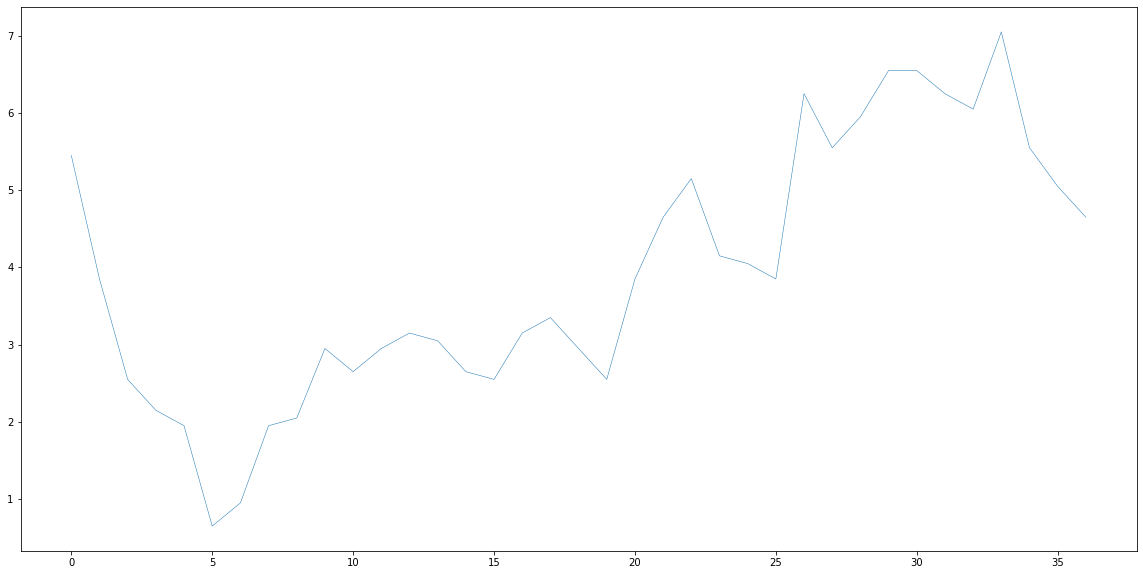

In [23]:
selection = data_array.loc['2016-03-22 18:00'][:, 0, 0]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(
    selection.forecast_hour,
    selection.values,
    linewidth=.5
)

In [24]:
wind_speed = data_array[:, :, :, 0].drop('variable_name')
wind_direction = data_array[:, :, :, 1].drop('variable_name')

In [25]:
wind_speed.attrs = ds['si10'].attrs
wind_speed.attrs['heightAboveGround'] = 10
wind_direction.attrs = ds['wdir10'].attrs
wind_direction.attrs['heightAboveGround'] = 10

In [26]:
dataset = xr.Dataset(
    {'wind_speed': wind_speed, 'wind_direction': wind_direction},
    attrs=ds.attrs)

In [27]:
del data_array
del wind_speed
del wind_direction

In [32]:
dataset.wind_speed

<xarray.DataArray 'wind_speed' (init_time: 5673, forecast_hour: 37, grib_index: 15559)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan

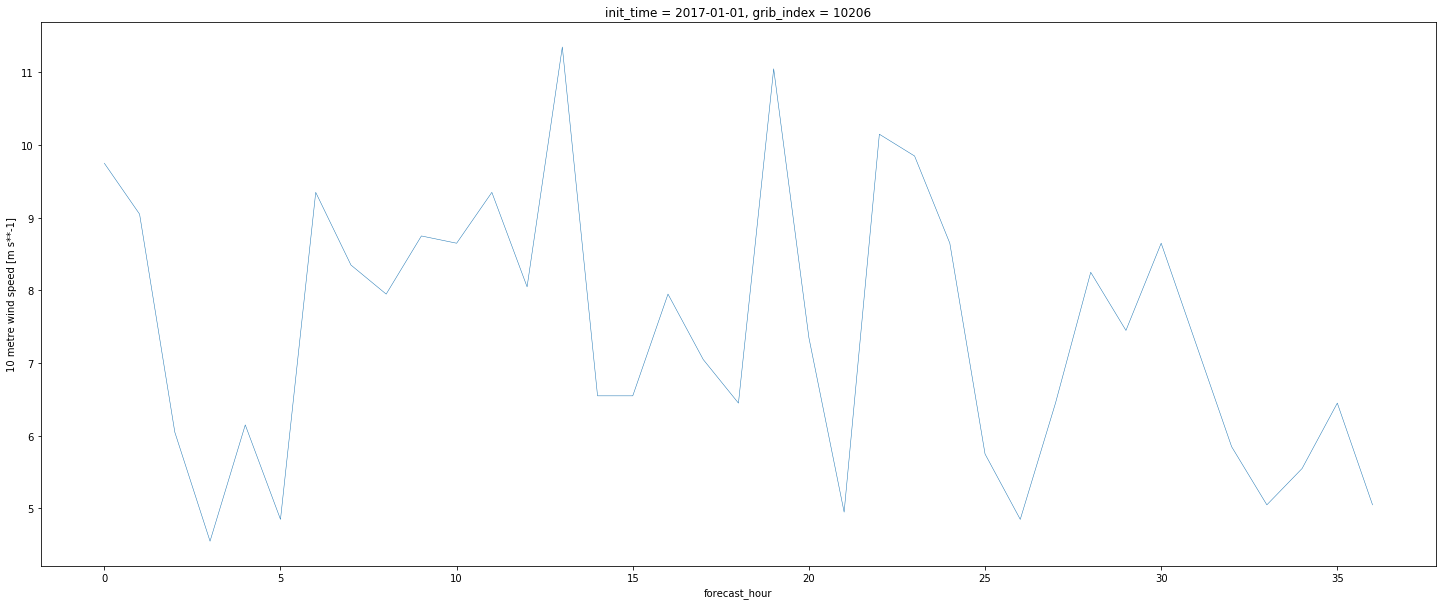

In [34]:
dataset.wind_speed.sel(grib_index=10206, init_time='2017-01-01T00').plot(figsize=(25, 10), linewidth=0.5)

In [29]:
%%time

COMPRESS = False

if COMPRESS:
    COMPRESSION_ARGS = {'compression': 'gzip', 'compression_opts': 9}
    encoding = {variable: COMPRESSION_ARGS for variable in dataset}
else:
    encoding = None

dataset.to_netcdf(
    '~/data/national_grid/ukv_10m_wind_for_mpans_all.nc',
    encoding=encoding
)

CPU times: user 5.51 s, sys: 46.5 s, total: 52.1 s
Wall time: 58.8 s


In [30]:
import matplotlib.ticker as mticker

/home/jack/miniconda3/envs/nwp/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jack/miniconda3/envs/nwp/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


ValueError: Axis limits cannot be NaN or Inf

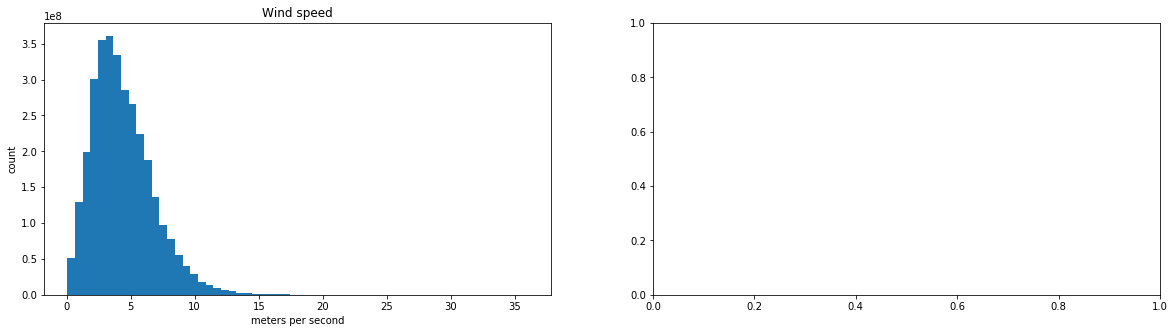

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

BINS = 60

ax = axes[0]
ax.set_title('Wind speed')
ax.set_xlabel('meters per second')
ax.set_ylabel('count')
wind_speed_flat = dataset.wind_speed.values.flatten()
ax.hist(wind_speed_flat, bins=BINS)
ax.set_xlim((0, wind_speed_flat.max()))

ax = axes[1]
ax.set_title('Wind direction')
ax.set_xlabel('degrees')
ax.set_ylabel('count')
wind_dir_flat = dataset.wind_direction.values.flatten()
ax.hist(wind_dir_flat, bins=BINS)
ax.set_xlim((0, 360))
ax.xaxis.set_major_locator(mticker.MultipleLocator(90))

In [ ]:
def describe(array, unit=''):
    print('min = {:6.1f}'.format(array.min()), unit)
    print('max = {:6.1f}'.format(array.max()), unit)
    print('num unique values =', len(np.unique(array)))
    print('NaNs:', np.isnan(array).any())
    
describe(wind_speed_flat, 'm/s')

In [ ]:
describe(wind_dir_flat, 'degrees')

In [ ]:
dataset

# Load Wholesale3 (multilevel) files

## Create empty data array

In [16]:
PRESSURE_LEVELS = [1000, 925]

In [17]:
def get_empty_data_array_wholesale3():
    coords = (
        ('init_time', pd.date_range(START_DATE, END_DATE, freq='3H')),
        ('forecast_hour', range(37)),
        ('pressure_level', PRESSURE_LEVELS),
        ('grib_index', grib_index),
        ('variable_name', ['wind_speed', 'wind_direction', 'geometric_height']))

    shape = [len(coord[1]) for coord in coords]
    data = np.empty(shape, dtype=np.float16)
    data[:, :, :] = np.NaN
    return xr.DataArray(data, coords=coords)

data_array_wholesale3 = get_empty_data_array_wholesale3()

## Load GRIB files

Variable names in wholesale1
* r = relative humidity
* t = temperature
* dpt = dew point temperature
* vis = visability
* si10 = 10 metre wind speed, m/s
* wdir10 = 10 metre wind direction, Degree true
* prmsl = Pressure reduced to MSL
* prate = Precipitation rate

In [18]:
filenames = glob.glob('/storage/data/uk_met_office/UKV/*/*/*/*Wholesale3.grib')
filenames.sort()

In [19]:
len(filenames)

5058

In [20]:
filenames[:5]

['/storage/data/uk_met_office/UKV/2016/03/22/201603221800_u1096_ng_umqv_Wholesale3.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230000_u1096_ng_umqv_Wholesale3.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603230600_u1096_ng_umqv_Wholesale3.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603231200_u1096_ng_umqv_Wholesale3.grib',
 '/storage/data/uk_met_office/UKV/2016/03/23/201603231800_u1096_ng_umqv_Wholesale3.grib']

In [21]:
def load_grib_dataset_wholesale3(filename):
    ds = cfgrib.open_dataset(filename)

    # Check this dataset only contains wind speed and wind direction
    assert 'ws' in ds
    assert 'wdir' in ds
    assert 'gh' in ds
    return ds

filename = filenames[3]
ds = load_grib_dataset_wholesale3(filename)
filename

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


'/storage/data/uk_met_office/UKV/2016/03/23/201603231200_u1096_ng_umqv_Wholesale3.grib'

TODO: Capture stderr.  See [stackoverflow](https://stackoverflow.com/questions/34145950/is-there-a-way-to-redirect-stderr-to-file-in-jupyter).

In [ ]:
%%time
n = len(filenames)
for i, filename in enumerate(filenames):
    print('\r', i, 'of', n, ':', filename, end='', flush=True)
    ds = load_grib_dataset_wholesale3(filename)
    ds = ds.sel(isobaricInhPa=PRESSURE_LEVELS).isel(values=grib_index)
    
    wind_speed = ds['ws']
    wind_direction = ds['wdir']
    geometric_height = ds['gh']

    data_array_wholesale3.loc[wind_speed.time.values, :, :, :, 'wind_speed'] = wind_speed.values
    data_array_wholesale3.loc[wind_direction.time.values, :, :, :, 'wind_direction'] = wind_direction.values
    data_array_wholesale3.loc[geometric_height.time.values, :, :, :, 'geometric_height'] = geometric_height.values

 0 of 5058 : /storage/data/uk_met_office/UKV/2016/03/22/201603221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1 of 5058 : /storage/data/uk_met_office/UKV/2016/03/23/201603230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2 of 5058 : /storage/data/uk_met_office/UKV/2016/03/23/201603230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3 of 5058 : /storage/data/uk_met_office/UKV/2016/03/23/201603231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4 of 5058 : /storage/data/uk_met_office/UKV/2016/03/23/201603231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5 of 5058 : /storage/data/uk_met_office/UKV/2016/03/24/201603240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 6 of 5058 : /storage/data/uk_met_office/UKV/2016/03/24/201603240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 7 of 5058 : /storage/data/uk_met_office/UKV/2016/03/24/201603241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 8 of 5058 : /storage/data/uk_met_office/UKV/2016/03/24/201603241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 9 of 5058 : /storage/data/uk_met_office/UKV/2016/03/25/201603250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 10 of 5058 : /storage/data/uk_met_office/UKV/2016/03/25/201603250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 11 of 5058 : /storage/data/uk_met_office/UKV/2016/03/25/201603251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 12 of 5058 : /storage/data/uk_met_office/UKV/2016/03/25/201603251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 13 of 5058 : /storage/data/uk_met_office/UKV/2016/03/26/201603260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 14 of 5058 : /storage/data/uk_met_office/UKV/2016/03/26/201603260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 15 of 5058 : /storage/data/uk_met_office/UKV/2016/03/26/201603261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 16 of 5058 : /storage/data/uk_met_office/UKV/2016/03/26/201603261800_u1096_ng_umqv_Wholesale3.grib

Can't read index file '/storage/data/uk_met_office/UKV/2016/03/26/201603261800_u1096_ng_umqv_Wholesale3.grib.011ab.idx'
Traceback (most recent call last):
  File "/home/jack/miniconda3/envs/nwp/lib/python3.7/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/jack/miniconda3/envs/nwp/lib/python3.7/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 17 of 5058 : /storage/data/uk_met_office/UKV/2016/03/27/201603270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 18 of 5058 : /storage/data/uk_met_office/UKV/2016/03/27/201603270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 19 of 5058 : /storage/data/uk_met_office/UKV/2016/03/27/201603271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 20 of 5058 : /storage/data/uk_met_office/UKV/2016/03/27/201603271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 21 of 5058 : /storage/data/uk_met_office/UKV/2016/03/28/201603280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 22 of 5058 : /storage/data/uk_met_office/UKV/2016/03/28/201603280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 23 of 5058 : /storage/data/uk_met_office/UKV/2016/03/28/201603281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 24 of 5058 : /storage/data/uk_met_office/UKV/2016/03/28/201603281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 25 of 5058 : /storage/data/uk_met_office/UKV/2016/03/29/201603290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 26 of 5058 : /storage/data/uk_met_office/UKV/2016/03/29/201603290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 27 of 5058 : /storage/data/uk_met_office/UKV/2016/03/29/201603291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 28 of 5058 : /storage/data/uk_met_office/UKV/2016/03/29/201603291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 29 of 5058 : /storage/data/uk_met_office/UKV/2016/03/30/201603300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 30 of 5058 : /storage/data/uk_met_office/UKV/2016/03/30/201603300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 31 of 5058 : /storage/data/uk_met_office/UKV/2016/03/30/201603301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 32 of 5058 : /storage/data/uk_met_office/UKV/2016/03/30/201603301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 33 of 5058 : /storage/data/uk_met_office/UKV/2016/03/31/201603310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 34 of 5058 : /storage/data/uk_met_office/UKV/2016/03/31/201603310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 35 of 5058 : /storage/data/uk_met_office/UKV/2016/03/31/201603311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 36 of 5058 : /storage/data/uk_met_office/UKV/2016/03/31/201603311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 37 of 5058 : /storage/data/uk_met_office/UKV/2016/04/01/201604010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 38 of 5058 : /storage/data/uk_met_office/UKV/2016/04/01/201604010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 39 of 5058 : /storage/data/uk_met_office/UKV/2016/04/01/201604011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 40 of 5058 : /storage/data/uk_met_office/UKV/2016/04/01/201604011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 41 of 5058 : /storage/data/uk_met_office/UKV/2016/04/02/201604020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 42 of 5058 : /storage/data/uk_met_office/UKV/2016/04/02/201604020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 43 of 5058 : /storage/data/uk_met_office/UKV/2016/04/02/201604021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 44 of 5058 : /storage/data/uk_met_office/UKV/2016/04/02/201604021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 45 of 5058 : /storage/data/uk_met_office/UKV/2016/04/03/201604030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 46 of 5058 : /storage/data/uk_met_office/UKV/2016/04/03/201604030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 47 of 5058 : /storage/data/uk_met_office/UKV/2016/04/03/201604031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 48 of 5058 : /storage/data/uk_met_office/UKV/2016/04/03/201604031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 49 of 5058 : /storage/data/uk_met_office/UKV/2016/04/04/201604040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 50 of 5058 : /storage/data/uk_met_office/UKV/2016/04/04/201604040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 51 of 5058 : /storage/data/uk_met_office/UKV/2016/04/04/201604041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 52 of 5058 : /storage/data/uk_met_office/UKV/2016/04/04/201604041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 53 of 5058 : /storage/data/uk_met_office/UKV/2016/04/05/201604050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 54 of 5058 : /storage/data/uk_met_office/UKV/2016/04/05/201604050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 55 of 5058 : /storage/data/uk_met_office/UKV/2016/04/05/201604051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 56 of 5058 : /storage/data/uk_met_office/UKV/2016/04/05/201604051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 57 of 5058 : /storage/data/uk_met_office/UKV/2016/04/06/201604060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 58 of 5058 : /storage/data/uk_met_office/UKV/2016/04/06/201604060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 59 of 5058 : /storage/data/uk_met_office/UKV/2016/04/06/201604061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 60 of 5058 : /storage/data/uk_met_office/UKV/2016/04/06/201604061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 61 of 5058 : /storage/data/uk_met_office/UKV/2016/04/07/201604070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 62 of 5058 : /storage/data/uk_met_office/UKV/2016/04/07/201604070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 63 of 5058 : /storage/data/uk_met_office/UKV/2016/04/07/201604071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 64 of 5058 : /storage/data/uk_met_office/UKV/2016/04/07/201604071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 65 of 5058 : /storage/data/uk_met_office/UKV/2016/04/08/201604080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 66 of 5058 : /storage/data/uk_met_office/UKV/2016/04/08/201604080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 67 of 5058 : /storage/data/uk_met_office/UKV/2016/04/08/201604081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 68 of 5058 : /storage/data/uk_met_office/UKV/2016/04/08/201604081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 69 of 5058 : /storage/data/uk_met_office/UKV/2016/04/09/201604090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 70 of 5058 : /storage/data/uk_met_office/UKV/2016/04/09/201604090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 71 of 5058 : /storage/data/uk_met_office/UKV/2016/04/09/201604091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 72 of 5058 : /storage/data/uk_met_office/UKV/2016/04/09/201604091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 73 of 5058 : /storage/data/uk_met_office/UKV/2016/04/10/201604100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 74 of 5058 : /storage/data/uk_met_office/UKV/2016/04/10/201604100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 75 of 5058 : /storage/data/uk_met_office/UKV/2016/04/10/201604101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 76 of 5058 : /storage/data/uk_met_office/UKV/2016/04/10/201604101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 77 of 5058 : /storage/data/uk_met_office/UKV/2016/04/11/201604110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 78 of 5058 : /storage/data/uk_met_office/UKV/2016/04/11/201604110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 79 of 5058 : /storage/data/uk_met_office/UKV/2016/04/11/201604111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 80 of 5058 : /storage/data/uk_met_office/UKV/2016/04/11/201604111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 81 of 5058 : /storage/data/uk_met_office/UKV/2016/04/12/201604120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 82 of 5058 : /storage/data/uk_met_office/UKV/2016/04/12/201604120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 83 of 5058 : /storage/data/uk_met_office/UKV/2016/04/12/201604121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 84 of 5058 : /storage/data/uk_met_office/UKV/2016/04/12/201604121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 85 of 5058 : /storage/data/uk_met_office/UKV/2016/04/13/201604130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 86 of 5058 : /storage/data/uk_met_office/UKV/2016/04/13/201604130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 87 of 5058 : /storage/data/uk_met_office/UKV/2016/04/13/201604131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 88 of 5058 : /storage/data/uk_met_office/UKV/2016/04/13/201604131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 89 of 5058 : /storage/data/uk_met_office/UKV/2016/04/14/201604140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 90 of 5058 : /storage/data/uk_met_office/UKV/2016/04/14/201604140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 91 of 5058 : /storage/data/uk_met_office/UKV/2016/04/14/201604141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 92 of 5058 : /storage/data/uk_met_office/UKV/2016/04/14/201604141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 93 of 5058 : /storage/data/uk_met_office/UKV/2016/04/15/201604150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 94 of 5058 : /storage/data/uk_met_office/UKV/2016/04/15/201604150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 95 of 5058 : /storage/data/uk_met_office/UKV/2016/04/15/201604151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 96 of 5058 : /storage/data/uk_met_office/UKV/2016/04/15/201604151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 97 of 5058 : /storage/data/uk_met_office/UKV/2016/04/16/201604160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 98 of 5058 : /storage/data/uk_met_office/UKV/2016/04/16/201604160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 99 of 5058 : /storage/data/uk_met_office/UKV/2016/04/16/201604161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 100 of 5058 : /storage/data/uk_met_office/UKV/2016/04/16/201604161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 101 of 5058 : /storage/data/uk_met_office/UKV/2016/04/17/201604170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 102 of 5058 : /storage/data/uk_met_office/UKV/2016/04/17/201604170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 103 of 5058 : /storage/data/uk_met_office/UKV/2016/04/17/201604171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 104 of 5058 : /storage/data/uk_met_office/UKV/2016/04/17/201604171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 105 of 5058 : /storage/data/uk_met_office/UKV/2016/04/18/201604180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 106 of 5058 : /storage/data/uk_met_office/UKV/2016/04/18/201604180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 107 of 5058 : /storage/data/uk_met_office/UKV/2016/04/18/201604181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 108 of 5058 : /storage/data/uk_met_office/UKV/2016/04/18/201604181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 109 of 5058 : /storage/data/uk_met_office/UKV/2016/04/19/201604190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 110 of 5058 : /storage/data/uk_met_office/UKV/2016/04/19/201604190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 111 of 5058 : /storage/data/uk_met_office/UKV/2016/04/19/201604191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 112 of 5058 : /storage/data/uk_met_office/UKV/2016/04/19/201604191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 113 of 5058 : /storage/data/uk_met_office/UKV/2016/04/20/201604200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 114 of 5058 : /storage/data/uk_met_office/UKV/2016/04/20/201604200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 115 of 5058 : /storage/data/uk_met_office/UKV/2016/04/20/201604201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 116 of 5058 : /storage/data/uk_met_office/UKV/2016/04/20/201604201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 117 of 5058 : /storage/data/uk_met_office/UKV/2016/04/21/201604210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 118 of 5058 : /storage/data/uk_met_office/UKV/2016/04/21/201604210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 119 of 5058 : /storage/data/uk_met_office/UKV/2016/04/21/201604211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 120 of 5058 : /storage/data/uk_met_office/UKV/2016/04/21/201604211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 121 of 5058 : /storage/data/uk_met_office/UKV/2016/04/22/201604220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 122 of 5058 : /storage/data/uk_met_office/UKV/2016/04/22/201604220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 123 of 5058 : /storage/data/uk_met_office/UKV/2016/04/22/201604221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 124 of 5058 : /storage/data/uk_met_office/UKV/2016/04/22/201604221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 125 of 5058 : /storage/data/uk_met_office/UKV/2016/04/23/201604230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 126 of 5058 : /storage/data/uk_met_office/UKV/2016/04/23/201604231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 127 of 5058 : /storage/data/uk_met_office/UKV/2016/04/23/201604231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 128 of 5058 : /storage/data/uk_met_office/UKV/2016/04/24/201604240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 129 of 5058 : /storage/data/uk_met_office/UKV/2016/04/24/201604240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 130 of 5058 : /storage/data/uk_met_office/UKV/2016/04/24/201604241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 131 of 5058 : /storage/data/uk_met_office/UKV/2016/04/24/201604241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 132 of 5058 : /storage/data/uk_met_office/UKV/2016/04/25/201604250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 133 of 5058 : /storage/data/uk_met_office/UKV/2016/04/25/201604250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 134 of 5058 : /storage/data/uk_met_office/UKV/2016/04/25/201604251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 135 of 5058 : /storage/data/uk_met_office/UKV/2016/04/25/201604251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 136 of 5058 : /storage/data/uk_met_office/UKV/2016/04/26/201604260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 137 of 5058 : /storage/data/uk_met_office/UKV/2016/04/26/201604260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 138 of 5058 : /storage/data/uk_met_office/UKV/2016/04/26/201604261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 139 of 5058 : /storage/data/uk_met_office/UKV/2016/04/26/201604261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 140 of 5058 : /storage/data/uk_met_office/UKV/2016/04/27/201604270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 141 of 5058 : /storage/data/uk_met_office/UKV/2016/04/27/201604270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 142 of 5058 : /storage/data/uk_met_office/UKV/2016/04/27/201604271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 143 of 5058 : /storage/data/uk_met_office/UKV/2016/04/27/201604271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 144 of 5058 : /storage/data/uk_met_office/UKV/2016/04/28/201604280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 145 of 5058 : /storage/data/uk_met_office/UKV/2016/04/28/201604280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 146 of 5058 : /storage/data/uk_met_office/UKV/2016/04/28/201604281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 147 of 5058 : /storage/data/uk_met_office/UKV/2016/04/28/201604281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 148 of 5058 : /storage/data/uk_met_office/UKV/2016/04/29/201604290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 149 of 5058 : /storage/data/uk_met_office/UKV/2016/04/29/201604290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 150 of 5058 : /storage/data/uk_met_office/UKV/2016/04/29/201604291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 151 of 5058 : /storage/data/uk_met_office/UKV/2016/04/29/201604291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 152 of 5058 : /storage/data/uk_met_office/UKV/2016/04/30/201604300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 153 of 5058 : /storage/data/uk_met_office/UKV/2016/04/30/201604300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 154 of 5058 : /storage/data/uk_met_office/UKV/2016/04/30/201604301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 155 of 5058 : /storage/data/uk_met_office/UKV/2016/04/30/201604301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 156 of 5058 : /storage/data/uk_met_office/UKV/2016/05/01/201605010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 157 of 5058 : /storage/data/uk_met_office/UKV/2016/05/01/201605010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 158 of 5058 : /storage/data/uk_met_office/UKV/2016/05/01/201605011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 159 of 5058 : /storage/data/uk_met_office/UKV/2016/05/01/201605011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 160 of 5058 : /storage/data/uk_met_office/UKV/2016/05/02/201605020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 161 of 5058 : /storage/data/uk_met_office/UKV/2016/05/02/201605020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 162 of 5058 : /storage/data/uk_met_office/UKV/2016/05/02/201605021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 163 of 5058 : /storage/data/uk_met_office/UKV/2016/05/03/201605030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 164 of 5058 : /storage/data/uk_met_office/UKV/2016/05/03/201605030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 165 of 5058 : /storage/data/uk_met_office/UKV/2016/05/03/201605031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 166 of 5058 : /storage/data/uk_met_office/UKV/2016/05/03/201605031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 167 of 5058 : /storage/data/uk_met_office/UKV/2016/05/04/201605040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 168 of 5058 : /storage/data/uk_met_office/UKV/2016/05/04/201605040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 169 of 5058 : /storage/data/uk_met_office/UKV/2016/05/04/201605041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 170 of 5058 : /storage/data/uk_met_office/UKV/2016/05/04/201605041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 171 of 5058 : /storage/data/uk_met_office/UKV/2016/05/05/201605050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 172 of 5058 : /storage/data/uk_met_office/UKV/2016/05/05/201605050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 173 of 5058 : /storage/data/uk_met_office/UKV/2016/05/05/201605051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 174 of 5058 : /storage/data/uk_met_office/UKV/2016/05/05/201605051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 175 of 5058 : /storage/data/uk_met_office/UKV/2016/05/06/201605060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 176 of 5058 : /storage/data/uk_met_office/UKV/2016/05/06/201605060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 177 of 5058 : /storage/data/uk_met_office/UKV/2016/05/06/201605061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 178 of 5058 : /storage/data/uk_met_office/UKV/2016/05/06/201605061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 179 of 5058 : /storage/data/uk_met_office/UKV/2016/05/07/201605070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 180 of 5058 : /storage/data/uk_met_office/UKV/2016/05/07/201605070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 181 of 5058 : /storage/data/uk_met_office/UKV/2016/05/07/201605071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 182 of 5058 : /storage/data/uk_met_office/UKV/2016/05/07/201605071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 183 of 5058 : /storage/data/uk_met_office/UKV/2016/05/08/201605080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 184 of 5058 : /storage/data/uk_met_office/UKV/2016/05/08/201605080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 185 of 5058 : /storage/data/uk_met_office/UKV/2016/05/08/201605081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 186 of 5058 : /storage/data/uk_met_office/UKV/2016/05/08/201605081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 187 of 5058 : /storage/data/uk_met_office/UKV/2016/05/09/201605090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 188 of 5058 : /storage/data/uk_met_office/UKV/2016/05/09/201605090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 189 of 5058 : /storage/data/uk_met_office/UKV/2016/05/09/201605091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 190 of 5058 : /storage/data/uk_met_office/UKV/2016/05/10/201605100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 191 of 5058 : /storage/data/uk_met_office/UKV/2016/05/10/201605100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 192 of 5058 : /storage/data/uk_met_office/UKV/2016/05/10/201605101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 193 of 5058 : /storage/data/uk_met_office/UKV/2016/05/10/201605101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 194 of 5058 : /storage/data/uk_met_office/UKV/2016/05/11/201605110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 195 of 5058 : /storage/data/uk_met_office/UKV/2016/05/11/201605110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 196 of 5058 : /storage/data/uk_met_office/UKV/2016/05/11/201605111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 197 of 5058 : /storage/data/uk_met_office/UKV/2016/05/11/201605111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 198 of 5058 : /storage/data/uk_met_office/UKV/2016/05/12/201605120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 199 of 5058 : /storage/data/uk_met_office/UKV/2016/05/12/201605120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 200 of 5058 : /storage/data/uk_met_office/UKV/2016/05/12/201605121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 201 of 5058 : /storage/data/uk_met_office/UKV/2016/05/12/201605121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 202 of 5058 : /storage/data/uk_met_office/UKV/2016/05/13/201605130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 203 of 5058 : /storage/data/uk_met_office/UKV/2016/05/13/201605130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 204 of 5058 : /storage/data/uk_met_office/UKV/2016/05/13/201605131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 205 of 5058 : /storage/data/uk_met_office/UKV/2016/05/13/201605131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 206 of 5058 : /storage/data/uk_met_office/UKV/2016/05/14/201605140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 207 of 5058 : /storage/data/uk_met_office/UKV/2016/05/14/201605140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 208 of 5058 : /storage/data/uk_met_office/UKV/2016/05/14/201605141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 209 of 5058 : /storage/data/uk_met_office/UKV/2016/05/14/201605141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 210 of 5058 : /storage/data/uk_met_office/UKV/2016/05/15/201605150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 211 of 5058 : /storage/data/uk_met_office/UKV/2016/05/15/201605150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 212 of 5058 : /storage/data/uk_met_office/UKV/2016/05/15/201605151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 213 of 5058 : /storage/data/uk_met_office/UKV/2016/05/15/201605151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 214 of 5058 : /storage/data/uk_met_office/UKV/2016/05/16/201605160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 215 of 5058 : /storage/data/uk_met_office/UKV/2016/05/16/201605160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 216 of 5058 : /storage/data/uk_met_office/UKV/2016/05/16/201605161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 217 of 5058 : /storage/data/uk_met_office/UKV/2016/05/16/201605161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 218 of 5058 : /storage/data/uk_met_office/UKV/2016/05/17/201605170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 219 of 5058 : /storage/data/uk_met_office/UKV/2016/05/17/201605170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 220 of 5058 : /storage/data/uk_met_office/UKV/2016/05/17/201605171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 221 of 5058 : /storage/data/uk_met_office/UKV/2016/05/17/201605171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 222 of 5058 : /storage/data/uk_met_office/UKV/2016/05/18/201605180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 223 of 5058 : /storage/data/uk_met_office/UKV/2016/05/18/201605180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 224 of 5058 : /storage/data/uk_met_office/UKV/2016/05/18/201605181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 225 of 5058 : /storage/data/uk_met_office/UKV/2016/05/18/201605181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 226 of 5058 : /storage/data/uk_met_office/UKV/2016/05/19/201605190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 227 of 5058 : /storage/data/uk_met_office/UKV/2016/05/19/201605190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 228 of 5058 : /storage/data/uk_met_office/UKV/2016/05/19/201605191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 229 of 5058 : /storage/data/uk_met_office/UKV/2016/05/19/201605191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 230 of 5058 : /storage/data/uk_met_office/UKV/2016/05/20/201605200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 231 of 5058 : /storage/data/uk_met_office/UKV/2016/05/20/201605200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 232 of 5058 : /storage/data/uk_met_office/UKV/2016/05/20/201605201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 233 of 5058 : /storage/data/uk_met_office/UKV/2016/05/20/201605201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 234 of 5058 : /storage/data/uk_met_office/UKV/2016/05/21/201605210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 235 of 5058 : /storage/data/uk_met_office/UKV/2016/05/21/201605210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 236 of 5058 : /storage/data/uk_met_office/UKV/2016/05/21/201605211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 237 of 5058 : /storage/data/uk_met_office/UKV/2016/05/21/201605211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 238 of 5058 : /storage/data/uk_met_office/UKV/2016/05/22/201605220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 239 of 5058 : /storage/data/uk_met_office/UKV/2016/05/22/201605220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 240 of 5058 : /storage/data/uk_met_office/UKV/2016/05/22/201605221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 241 of 5058 : /storage/data/uk_met_office/UKV/2016/05/22/201605221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 242 of 5058 : /storage/data/uk_met_office/UKV/2016/05/23/201605230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 243 of 5058 : /storage/data/uk_met_office/UKV/2016/05/23/201605230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 244 of 5058 : /storage/data/uk_met_office/UKV/2016/05/23/201605231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 245 of 5058 : /storage/data/uk_met_office/UKV/2016/05/23/201605231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 246 of 5058 : /storage/data/uk_met_office/UKV/2016/05/24/201605240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 247 of 5058 : /storage/data/uk_met_office/UKV/2016/05/24/201605240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 248 of 5058 : /storage/data/uk_met_office/UKV/2016/05/24/201605241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 249 of 5058 : /storage/data/uk_met_office/UKV/2016/05/24/201605241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 250 of 5058 : /storage/data/uk_met_office/UKV/2016/05/25/201605250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 251 of 5058 : /storage/data/uk_met_office/UKV/2016/05/25/201605250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 252 of 5058 : /storage/data/uk_met_office/UKV/2016/05/25/201605251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 253 of 5058 : /storage/data/uk_met_office/UKV/2016/05/25/201605251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 254 of 5058 : /storage/data/uk_met_office/UKV/2016/05/26/201605260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 255 of 5058 : /storage/data/uk_met_office/UKV/2016/05/26/201605260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 256 of 5058 : /storage/data/uk_met_office/UKV/2016/05/26/201605261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 257 of 5058 : /storage/data/uk_met_office/UKV/2016/05/26/201605261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 258 of 5058 : /storage/data/uk_met_office/UKV/2016/05/27/201605270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 259 of 5058 : /storage/data/uk_met_office/UKV/2016/05/27/201605270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 260 of 5058 : /storage/data/uk_met_office/UKV/2016/05/27/201605271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 261 of 5058 : /storage/data/uk_met_office/UKV/2016/05/28/201605280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 262 of 5058 : /storage/data/uk_met_office/UKV/2016/05/28/201605280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 263 of 5058 : /storage/data/uk_met_office/UKV/2016/05/28/201605281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 264 of 5058 : /storage/data/uk_met_office/UKV/2016/05/28/201605281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 265 of 5058 : /storage/data/uk_met_office/UKV/2016/05/29/201605290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 266 of 5058 : /storage/data/uk_met_office/UKV/2016/05/29/201605290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 267 of 5058 : /storage/data/uk_met_office/UKV/2016/05/29/201605291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 268 of 5058 : /storage/data/uk_met_office/UKV/2016/05/29/201605291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 269 of 5058 : /storage/data/uk_met_office/UKV/2016/05/30/201605300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 270 of 5058 : /storage/data/uk_met_office/UKV/2016/05/30/201605300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 271 of 5058 : /storage/data/uk_met_office/UKV/2016/05/30/201605301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 272 of 5058 : /storage/data/uk_met_office/UKV/2016/05/30/201605301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 273 of 5058 : /storage/data/uk_met_office/UKV/2016/05/31/201605310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 274 of 5058 : /storage/data/uk_met_office/UKV/2016/05/31/201605310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 275 of 5058 : /storage/data/uk_met_office/UKV/2016/05/31/201605311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 276 of 5058 : /storage/data/uk_met_office/UKV/2016/05/31/201605311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 277 of 5058 : /storage/data/uk_met_office/UKV/2016/06/01/201606010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 278 of 5058 : /storage/data/uk_met_office/UKV/2016/06/01/201606010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 279 of 5058 : /storage/data/uk_met_office/UKV/2016/06/01/201606011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 280 of 5058 : /storage/data/uk_met_office/UKV/2016/06/01/201606011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 281 of 5058 : /storage/data/uk_met_office/UKV/2016/06/02/201606020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 282 of 5058 : /storage/data/uk_met_office/UKV/2016/06/02/201606020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 283 of 5058 : /storage/data/uk_met_office/UKV/2016/06/02/201606021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 284 of 5058 : /storage/data/uk_met_office/UKV/2016/06/02/201606021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 285 of 5058 : /storage/data/uk_met_office/UKV/2016/06/03/201606030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 286 of 5058 : /storage/data/uk_met_office/UKV/2016/06/03/201606030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 287 of 5058 : /storage/data/uk_met_office/UKV/2016/06/03/201606031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 288 of 5058 : /storage/data/uk_met_office/UKV/2016/06/03/201606031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 289 of 5058 : /storage/data/uk_met_office/UKV/2016/06/04/201606040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 290 of 5058 : /storage/data/uk_met_office/UKV/2016/06/04/201606040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 291 of 5058 : /storage/data/uk_met_office/UKV/2016/06/04/201606041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 292 of 5058 : /storage/data/uk_met_office/UKV/2016/06/04/201606041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 293 of 5058 : /storage/data/uk_met_office/UKV/2016/06/05/201606050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 294 of 5058 : /storage/data/uk_met_office/UKV/2016/06/05/201606050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 295 of 5058 : /storage/data/uk_met_office/UKV/2016/06/05/201606051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 296 of 5058 : /storage/data/uk_met_office/UKV/2016/06/05/201606051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 297 of 5058 : /storage/data/uk_met_office/UKV/2016/06/06/201606060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 298 of 5058 : /storage/data/uk_met_office/UKV/2016/06/06/201606060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 299 of 5058 : /storage/data/uk_met_office/UKV/2016/06/06/201606061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 300 of 5058 : /storage/data/uk_met_office/UKV/2016/06/06/201606061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 301 of 5058 : /storage/data/uk_met_office/UKV/2016/06/07/201606070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 302 of 5058 : /storage/data/uk_met_office/UKV/2016/06/07/201606070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 303 of 5058 : /storage/data/uk_met_office/UKV/2016/06/07/201606071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 304 of 5058 : /storage/data/uk_met_office/UKV/2016/06/07/201606071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 305 of 5058 : /storage/data/uk_met_office/UKV/2016/06/08/201606080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 306 of 5058 : /storage/data/uk_met_office/UKV/2016/06/08/201606080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 307 of 5058 : /storage/data/uk_met_office/UKV/2016/06/08/201606081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 308 of 5058 : /storage/data/uk_met_office/UKV/2016/06/08/201606081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 309 of 5058 : /storage/data/uk_met_office/UKV/2016/06/09/201606090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 310 of 5058 : /storage/data/uk_met_office/UKV/2016/06/09/201606090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 311 of 5058 : /storage/data/uk_met_office/UKV/2016/06/09/201606091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 312 of 5058 : /storage/data/uk_met_office/UKV/2016/06/09/201606091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 313 of 5058 : /storage/data/uk_met_office/UKV/2016/06/10/201606100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 314 of 5058 : /storage/data/uk_met_office/UKV/2016/06/10/201606100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 315 of 5058 : /storage/data/uk_met_office/UKV/2016/06/10/201606101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 316 of 5058 : /storage/data/uk_met_office/UKV/2016/06/10/201606101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 317 of 5058 : /storage/data/uk_met_office/UKV/2016/06/11/201606110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 318 of 5058 : /storage/data/uk_met_office/UKV/2016/06/11/201606110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 319 of 5058 : /storage/data/uk_met_office/UKV/2016/06/11/201606111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 320 of 5058 : /storage/data/uk_met_office/UKV/2016/06/11/201606111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 321 of 5058 : /storage/data/uk_met_office/UKV/2016/06/12/201606120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 322 of 5058 : /storage/data/uk_met_office/UKV/2016/06/12/201606120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 323 of 5058 : /storage/data/uk_met_office/UKV/2016/06/12/201606121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 324 of 5058 : /storage/data/uk_met_office/UKV/2016/06/12/201606121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 325 of 5058 : /storage/data/uk_met_office/UKV/2016/06/13/201606130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 326 of 5058 : /storage/data/uk_met_office/UKV/2016/06/13/201606130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 327 of 5058 : /storage/data/uk_met_office/UKV/2016/06/13/201606131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 328 of 5058 : /storage/data/uk_met_office/UKV/2016/06/13/201606131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 329 of 5058 : /storage/data/uk_met_office/UKV/2016/06/14/201606140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 330 of 5058 : /storage/data/uk_met_office/UKV/2016/06/14/201606140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 331 of 5058 : /storage/data/uk_met_office/UKV/2016/06/14/201606141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 332 of 5058 : /storage/data/uk_met_office/UKV/2016/06/14/201606141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 333 of 5058 : /storage/data/uk_met_office/UKV/2016/06/15/201606150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 334 of 5058 : /storage/data/uk_met_office/UKV/2016/06/15/201606150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 335 of 5058 : /storage/data/uk_met_office/UKV/2016/06/15/201606151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 336 of 5058 : /storage/data/uk_met_office/UKV/2016/06/15/201606151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 337 of 5058 : /storage/data/uk_met_office/UKV/2016/06/16/201606160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 338 of 5058 : /storage/data/uk_met_office/UKV/2016/06/16/201606160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 339 of 5058 : /storage/data/uk_met_office/UKV/2016/06/16/201606161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 340 of 5058 : /storage/data/uk_met_office/UKV/2016/06/16/201606161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 341 of 5058 : /storage/data/uk_met_office/UKV/2016/06/17/201606170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 342 of 5058 : /storage/data/uk_met_office/UKV/2016/06/17/201606170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 343 of 5058 : /storage/data/uk_met_office/UKV/2016/06/17/201606171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 344 of 5058 : /storage/data/uk_met_office/UKV/2016/06/17/201606171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 345 of 5058 : /storage/data/uk_met_office/UKV/2016/06/18/201606180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 346 of 5058 : /storage/data/uk_met_office/UKV/2016/06/18/201606180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 347 of 5058 : /storage/data/uk_met_office/UKV/2016/06/18/201606181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 348 of 5058 : /storage/data/uk_met_office/UKV/2016/06/18/201606181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 349 of 5058 : /storage/data/uk_met_office/UKV/2016/06/19/201606190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 350 of 5058 : /storage/data/uk_met_office/UKV/2016/06/19/201606190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 351 of 5058 : /storage/data/uk_met_office/UKV/2016/06/19/201606191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 352 of 5058 : /storage/data/uk_met_office/UKV/2016/06/19/201606191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 353 of 5058 : /storage/data/uk_met_office/UKV/2016/06/20/201606200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 354 of 5058 : /storage/data/uk_met_office/UKV/2016/06/20/201606200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 355 of 5058 : /storage/data/uk_met_office/UKV/2016/06/20/201606201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 356 of 5058 : /storage/data/uk_met_office/UKV/2016/06/20/201606201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 357 of 5058 : /storage/data/uk_met_office/UKV/2016/06/21/201606210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 358 of 5058 : /storage/data/uk_met_office/UKV/2016/06/21/201606210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 359 of 5058 : /storage/data/uk_met_office/UKV/2016/06/21/201606211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 360 of 5058 : /storage/data/uk_met_office/UKV/2016/06/21/201606211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 361 of 5058 : /storage/data/uk_met_office/UKV/2016/06/22/201606220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 362 of 5058 : /storage/data/uk_met_office/UKV/2016/06/22/201606220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 363 of 5058 : /storage/data/uk_met_office/UKV/2016/06/22/201606221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 364 of 5058 : /storage/data/uk_met_office/UKV/2016/06/22/201606221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 365 of 5058 : /storage/data/uk_met_office/UKV/2016/06/23/201606230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 366 of 5058 : /storage/data/uk_met_office/UKV/2016/06/23/201606230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 367 of 5058 : /storage/data/uk_met_office/UKV/2016/06/23/201606231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 368 of 5058 : /storage/data/uk_met_office/UKV/2016/06/23/201606231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 369 of 5058 : /storage/data/uk_met_office/UKV/2016/06/24/201606240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 370 of 5058 : /storage/data/uk_met_office/UKV/2016/06/24/201606240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 371 of 5058 : /storage/data/uk_met_office/UKV/2016/06/24/201606241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 372 of 5058 : /storage/data/uk_met_office/UKV/2016/06/24/201606241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 373 of 5058 : /storage/data/uk_met_office/UKV/2016/06/25/201606250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 374 of 5058 : /storage/data/uk_met_office/UKV/2016/06/25/201606250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 375 of 5058 : /storage/data/uk_met_office/UKV/2016/06/25/201606251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 376 of 5058 : /storage/data/uk_met_office/UKV/2016/06/25/201606251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 377 of 5058 : /storage/data/uk_met_office/UKV/2016/06/26/201606260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 378 of 5058 : /storage/data/uk_met_office/UKV/2016/06/26/201606260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 379 of 5058 : /storage/data/uk_met_office/UKV/2016/06/26/201606261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 380 of 5058 : /storage/data/uk_met_office/UKV/2016/06/26/201606261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 381 of 5058 : /storage/data/uk_met_office/UKV/2016/06/27/201606270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 382 of 5058 : /storage/data/uk_met_office/UKV/2016/06/27/201606270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 383 of 5058 : /storage/data/uk_met_office/UKV/2016/06/27/201606271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 384 of 5058 : /storage/data/uk_met_office/UKV/2016/06/27/201606271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 385 of 5058 : /storage/data/uk_met_office/UKV/2016/06/28/201606280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 386 of 5058 : /storage/data/uk_met_office/UKV/2016/06/28/201606280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 387 of 5058 : /storage/data/uk_met_office/UKV/2016/06/28/201606281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 388 of 5058 : /storage/data/uk_met_office/UKV/2016/06/28/201606281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 389 of 5058 : /storage/data/uk_met_office/UKV/2016/06/29/201606290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 390 of 5058 : /storage/data/uk_met_office/UKV/2016/06/29/201606290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 391 of 5058 : /storage/data/uk_met_office/UKV/2016/06/29/201606291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 392 of 5058 : /storage/data/uk_met_office/UKV/2016/06/29/201606291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 393 of 5058 : /storage/data/uk_met_office/UKV/2016/06/30/201606300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 394 of 5058 : /storage/data/uk_met_office/UKV/2016/06/30/201606300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 395 of 5058 : /storage/data/uk_met_office/UKV/2016/06/30/201606301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 396 of 5058 : /storage/data/uk_met_office/UKV/2016/06/30/201606301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 397 of 5058 : /storage/data/uk_met_office/UKV/2016/07/01/201607010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 398 of 5058 : /storage/data/uk_met_office/UKV/2016/07/01/201607010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 399 of 5058 : /storage/data/uk_met_office/UKV/2016/07/01/201607011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 400 of 5058 : /storage/data/uk_met_office/UKV/2016/07/01/201607011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 401 of 5058 : /storage/data/uk_met_office/UKV/2016/07/02/201607020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 402 of 5058 : /storage/data/uk_met_office/UKV/2016/07/02/201607020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 403 of 5058 : /storage/data/uk_met_office/UKV/2016/07/02/201607021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 404 of 5058 : /storage/data/uk_met_office/UKV/2016/07/02/201607021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 405 of 5058 : /storage/data/uk_met_office/UKV/2016/07/03/201607030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 406 of 5058 : /storage/data/uk_met_office/UKV/2016/07/03/201607030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 407 of 5058 : /storage/data/uk_met_office/UKV/2016/07/03/201607031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 408 of 5058 : /storage/data/uk_met_office/UKV/2016/07/03/201607031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 409 of 5058 : /storage/data/uk_met_office/UKV/2016/07/04/201607040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 410 of 5058 : /storage/data/uk_met_office/UKV/2016/07/04/201607040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 411 of 5058 : /storage/data/uk_met_office/UKV/2016/07/04/201607041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 412 of 5058 : /storage/data/uk_met_office/UKV/2016/07/04/201607041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 413 of 5058 : /storage/data/uk_met_office/UKV/2016/07/05/201607050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 414 of 5058 : /storage/data/uk_met_office/UKV/2016/07/05/201607050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 415 of 5058 : /storage/data/uk_met_office/UKV/2016/07/05/201607051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 416 of 5058 : /storage/data/uk_met_office/UKV/2016/07/05/201607051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 417 of 5058 : /storage/data/uk_met_office/UKV/2016/07/06/201607060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 418 of 5058 : /storage/data/uk_met_office/UKV/2016/07/06/201607060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 419 of 5058 : /storage/data/uk_met_office/UKV/2016/07/06/201607061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 420 of 5058 : /storage/data/uk_met_office/UKV/2016/07/06/201607061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 421 of 5058 : /storage/data/uk_met_office/UKV/2016/07/07/201607070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 422 of 5058 : /storage/data/uk_met_office/UKV/2016/07/07/201607070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 423 of 5058 : /storage/data/uk_met_office/UKV/2016/07/07/201607071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 424 of 5058 : /storage/data/uk_met_office/UKV/2016/07/07/201607071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 425 of 5058 : /storage/data/uk_met_office/UKV/2016/07/08/201607080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 426 of 5058 : /storage/data/uk_met_office/UKV/2016/07/08/201607080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 427 of 5058 : /storage/data/uk_met_office/UKV/2016/07/08/201607081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 428 of 5058 : /storage/data/uk_met_office/UKV/2016/07/08/201607081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 429 of 5058 : /storage/data/uk_met_office/UKV/2016/07/09/201607090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 430 of 5058 : /storage/data/uk_met_office/UKV/2016/07/09/201607090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 431 of 5058 : /storage/data/uk_met_office/UKV/2016/07/09/201607091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 432 of 5058 : /storage/data/uk_met_office/UKV/2016/07/09/201607091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 433 of 5058 : /storage/data/uk_met_office/UKV/2016/07/10/201607100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 434 of 5058 : /storage/data/uk_met_office/UKV/2016/07/10/201607100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 435 of 5058 : /storage/data/uk_met_office/UKV/2016/07/10/201607101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 436 of 5058 : /storage/data/uk_met_office/UKV/2016/07/10/201607101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 437 of 5058 : /storage/data/uk_met_office/UKV/2016/07/11/201607110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 438 of 5058 : /storage/data/uk_met_office/UKV/2016/07/11/201607110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 439 of 5058 : /storage/data/uk_met_office/UKV/2016/07/11/201607111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 440 of 5058 : /storage/data/uk_met_office/UKV/2016/07/11/201607111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 441 of 5058 : /storage/data/uk_met_office/UKV/2016/07/12/201607120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 442 of 5058 : /storage/data/uk_met_office/UKV/2016/07/12/201607120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 443 of 5058 : /storage/data/uk_met_office/UKV/2016/07/12/201607121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 444 of 5058 : /storage/data/uk_met_office/UKV/2016/07/12/201607121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 445 of 5058 : /storage/data/uk_met_office/UKV/2016/07/13/201607130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 446 of 5058 : /storage/data/uk_met_office/UKV/2016/07/13/201607130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 447 of 5058 : /storage/data/uk_met_office/UKV/2016/07/13/201607131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 448 of 5058 : /storage/data/uk_met_office/UKV/2016/07/13/201607131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 449 of 5058 : /storage/data/uk_met_office/UKV/2016/07/14/201607140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 450 of 5058 : /storage/data/uk_met_office/UKV/2016/07/14/201607140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 451 of 5058 : /storage/data/uk_met_office/UKV/2016/07/14/201607141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 452 of 5058 : /storage/data/uk_met_office/UKV/2016/07/14/201607141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 453 of 5058 : /storage/data/uk_met_office/UKV/2016/07/15/201607150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 454 of 5058 : /storage/data/uk_met_office/UKV/2016/07/15/201607150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 455 of 5058 : /storage/data/uk_met_office/UKV/2016/07/15/201607151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 456 of 5058 : /storage/data/uk_met_office/UKV/2016/07/15/201607151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 457 of 5058 : /storage/data/uk_met_office/UKV/2016/07/16/201607160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 458 of 5058 : /storage/data/uk_met_office/UKV/2016/07/16/201607160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 459 of 5058 : /storage/data/uk_met_office/UKV/2016/07/16/201607161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 460 of 5058 : /storage/data/uk_met_office/UKV/2016/07/16/201607161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 461 of 5058 : /storage/data/uk_met_office/UKV/2016/07/17/201607170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 462 of 5058 : /storage/data/uk_met_office/UKV/2016/07/17/201607170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 463 of 5058 : /storage/data/uk_met_office/UKV/2016/07/17/201607171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 464 of 5058 : /storage/data/uk_met_office/UKV/2016/07/17/201607171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 465 of 5058 : /storage/data/uk_met_office/UKV/2016/07/18/201607180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 466 of 5058 : /storage/data/uk_met_office/UKV/2016/07/18/201607180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 467 of 5058 : /storage/data/uk_met_office/UKV/2016/07/18/201607181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 468 of 5058 : /storage/data/uk_met_office/UKV/2016/07/18/201607181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 469 of 5058 : /storage/data/uk_met_office/UKV/2016/07/19/201607190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 470 of 5058 : /storage/data/uk_met_office/UKV/2016/07/19/201607190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 471 of 5058 : /storage/data/uk_met_office/UKV/2016/07/19/201607191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 472 of 5058 : /storage/data/uk_met_office/UKV/2016/07/19/201607191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 473 of 5058 : /storage/data/uk_met_office/UKV/2016/07/20/201607200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 474 of 5058 : /storage/data/uk_met_office/UKV/2016/07/20/201607200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 475 of 5058 : /storage/data/uk_met_office/UKV/2016/07/20/201607201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 476 of 5058 : /storage/data/uk_met_office/UKV/2016/07/20/201607201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 477 of 5058 : /storage/data/uk_met_office/UKV/2016/07/21/201607210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 478 of 5058 : /storage/data/uk_met_office/UKV/2016/07/21/201607210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 479 of 5058 : /storage/data/uk_met_office/UKV/2016/07/21/201607211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 480 of 5058 : /storage/data/uk_met_office/UKV/2016/07/21/201607211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 481 of 5058 : /storage/data/uk_met_office/UKV/2016/07/22/201607220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 482 of 5058 : /storage/data/uk_met_office/UKV/2016/07/22/201607220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 483 of 5058 : /storage/data/uk_met_office/UKV/2016/07/22/201607221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 484 of 5058 : /storage/data/uk_met_office/UKV/2016/07/22/201607221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 485 of 5058 : /storage/data/uk_met_office/UKV/2016/07/23/201607230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 486 of 5058 : /storage/data/uk_met_office/UKV/2016/07/23/201607230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 487 of 5058 : /storage/data/uk_met_office/UKV/2016/07/23/201607231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 488 of 5058 : /storage/data/uk_met_office/UKV/2016/07/23/201607231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 489 of 5058 : /storage/data/uk_met_office/UKV/2016/07/24/201607240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 490 of 5058 : /storage/data/uk_met_office/UKV/2016/07/24/201607240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 491 of 5058 : /storage/data/uk_met_office/UKV/2016/07/24/201607241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 492 of 5058 : /storage/data/uk_met_office/UKV/2016/07/24/201607241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 493 of 5058 : /storage/data/uk_met_office/UKV/2016/07/25/201607250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 494 of 5058 : /storage/data/uk_met_office/UKV/2016/07/25/201607250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 495 of 5058 : /storage/data/uk_met_office/UKV/2016/07/25/201607251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 496 of 5058 : /storage/data/uk_met_office/UKV/2016/07/25/201607251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 497 of 5058 : /storage/data/uk_met_office/UKV/2016/07/26/201607260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 498 of 5058 : /storage/data/uk_met_office/UKV/2016/07/26/201607260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 499 of 5058 : /storage/data/uk_met_office/UKV/2016/07/26/201607261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 500 of 5058 : /storage/data/uk_met_office/UKV/2016/07/26/201607261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 501 of 5058 : /storage/data/uk_met_office/UKV/2016/07/27/201607270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 502 of 5058 : /storage/data/uk_met_office/UKV/2016/07/27/201607270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 503 of 5058 : /storage/data/uk_met_office/UKV/2016/07/27/201607271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 504 of 5058 : /storage/data/uk_met_office/UKV/2016/07/27/201607271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 505 of 5058 : /storage/data/uk_met_office/UKV/2016/07/28/201607280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 506 of 5058 : /storage/data/uk_met_office/UKV/2016/07/28/201607280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 507 of 5058 : /storage/data/uk_met_office/UKV/2016/07/28/201607281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 508 of 5058 : /storage/data/uk_met_office/UKV/2016/07/28/201607281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 509 of 5058 : /storage/data/uk_met_office/UKV/2016/07/29/201607290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 510 of 5058 : /storage/data/uk_met_office/UKV/2016/07/29/201607290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 511 of 5058 : /storage/data/uk_met_office/UKV/2016/07/29/201607291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 512 of 5058 : /storage/data/uk_met_office/UKV/2016/07/29/201607291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 513 of 5058 : /storage/data/uk_met_office/UKV/2016/07/30/201607300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 514 of 5058 : /storage/data/uk_met_office/UKV/2016/07/30/201607300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 515 of 5058 : /storage/data/uk_met_office/UKV/2016/07/30/201607301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 516 of 5058 : /storage/data/uk_met_office/UKV/2016/07/30/201607301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 517 of 5058 : /storage/data/uk_met_office/UKV/2016/07/31/201607310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 518 of 5058 : /storage/data/uk_met_office/UKV/2016/07/31/201607310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 519 of 5058 : /storage/data/uk_met_office/UKV/2016/07/31/201607311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 520 of 5058 : /storage/data/uk_met_office/UKV/2016/07/31/201607311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 521 of 5058 : /storage/data/uk_met_office/UKV/2016/08/01/201608010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 522 of 5058 : /storage/data/uk_met_office/UKV/2016/08/01/201608010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 523 of 5058 : /storage/data/uk_met_office/UKV/2016/08/01/201608011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 524 of 5058 : /storage/data/uk_met_office/UKV/2016/08/01/201608011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 525 of 5058 : /storage/data/uk_met_office/UKV/2016/08/02/201608020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 526 of 5058 : /storage/data/uk_met_office/UKV/2016/08/02/201608020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 527 of 5058 : /storage/data/uk_met_office/UKV/2016/08/02/201608021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 528 of 5058 : /storage/data/uk_met_office/UKV/2016/08/02/201608021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 529 of 5058 : /storage/data/uk_met_office/UKV/2016/08/03/201608030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 530 of 5058 : /storage/data/uk_met_office/UKV/2016/08/03/201608030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 531 of 5058 : /storage/data/uk_met_office/UKV/2016/08/03/201608031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 532 of 5058 : /storage/data/uk_met_office/UKV/2016/08/03/201608031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 533 of 5058 : /storage/data/uk_met_office/UKV/2016/08/04/201608040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 534 of 5058 : /storage/data/uk_met_office/UKV/2016/08/04/201608040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 535 of 5058 : /storage/data/uk_met_office/UKV/2016/08/04/201608041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 536 of 5058 : /storage/data/uk_met_office/UKV/2016/08/04/201608041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 537 of 5058 : /storage/data/uk_met_office/UKV/2016/08/05/201608050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 538 of 5058 : /storage/data/uk_met_office/UKV/2016/08/05/201608050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 539 of 5058 : /storage/data/uk_met_office/UKV/2016/08/05/201608051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 540 of 5058 : /storage/data/uk_met_office/UKV/2016/08/05/201608051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 541 of 5058 : /storage/data/uk_met_office/UKV/2016/08/06/201608060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 542 of 5058 : /storage/data/uk_met_office/UKV/2016/08/06/201608060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 543 of 5058 : /storage/data/uk_met_office/UKV/2016/08/06/201608061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 544 of 5058 : /storage/data/uk_met_office/UKV/2016/08/06/201608061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 545 of 5058 : /storage/data/uk_met_office/UKV/2016/08/07/201608070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 546 of 5058 : /storage/data/uk_met_office/UKV/2016/08/07/201608070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 547 of 5058 : /storage/data/uk_met_office/UKV/2016/08/07/201608071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 548 of 5058 : /storage/data/uk_met_office/UKV/2016/08/07/201608071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 549 of 5058 : /storage/data/uk_met_office/UKV/2016/08/08/201608080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 550 of 5058 : /storage/data/uk_met_office/UKV/2016/08/08/201608080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 551 of 5058 : /storage/data/uk_met_office/UKV/2016/08/08/201608081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 552 of 5058 : /storage/data/uk_met_office/UKV/2016/08/08/201608081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 553 of 5058 : /storage/data/uk_met_office/UKV/2016/08/09/201608090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 554 of 5058 : /storage/data/uk_met_office/UKV/2016/08/09/201608090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 555 of 5058 : /storage/data/uk_met_office/UKV/2016/08/09/201608091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 556 of 5058 : /storage/data/uk_met_office/UKV/2016/08/09/201608091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 557 of 5058 : /storage/data/uk_met_office/UKV/2016/08/10/201608100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 558 of 5058 : /storage/data/uk_met_office/UKV/2016/08/10/201608100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 559 of 5058 : /storage/data/uk_met_office/UKV/2016/08/10/201608101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 560 of 5058 : /storage/data/uk_met_office/UKV/2016/08/10/201608101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 561 of 5058 : /storage/data/uk_met_office/UKV/2016/08/11/201608110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 562 of 5058 : /storage/data/uk_met_office/UKV/2016/08/11/201608110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 563 of 5058 : /storage/data/uk_met_office/UKV/2016/08/11/201608111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 564 of 5058 : /storage/data/uk_met_office/UKV/2016/08/11/201608111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 565 of 5058 : /storage/data/uk_met_office/UKV/2016/08/12/201608120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 566 of 5058 : /storage/data/uk_met_office/UKV/2016/08/12/201608120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 567 of 5058 : /storage/data/uk_met_office/UKV/2016/08/12/201608121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 568 of 5058 : /storage/data/uk_met_office/UKV/2016/08/12/201608121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 569 of 5058 : /storage/data/uk_met_office/UKV/2016/08/13/201608130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 570 of 5058 : /storage/data/uk_met_office/UKV/2016/08/13/201608130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 571 of 5058 : /storage/data/uk_met_office/UKV/2016/08/13/201608131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 572 of 5058 : /storage/data/uk_met_office/UKV/2016/08/13/201608131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 573 of 5058 : /storage/data/uk_met_office/UKV/2016/08/14/201608140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 574 of 5058 : /storage/data/uk_met_office/UKV/2016/08/14/201608140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 575 of 5058 : /storage/data/uk_met_office/UKV/2016/08/14/201608141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 576 of 5058 : /storage/data/uk_met_office/UKV/2016/08/14/201608141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 577 of 5058 : /storage/data/uk_met_office/UKV/2016/08/15/201608150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 578 of 5058 : /storage/data/uk_met_office/UKV/2016/08/15/201608150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 579 of 5058 : /storage/data/uk_met_office/UKV/2016/08/15/201608151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 580 of 5058 : /storage/data/uk_met_office/UKV/2016/08/15/201608151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 581 of 5058 : /storage/data/uk_met_office/UKV/2016/08/16/201608160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 582 of 5058 : /storage/data/uk_met_office/UKV/2016/08/16/201608160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 583 of 5058 : /storage/data/uk_met_office/UKV/2016/08/16/201608161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 584 of 5058 : /storage/data/uk_met_office/UKV/2016/08/16/201608161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 585 of 5058 : /storage/data/uk_met_office/UKV/2016/08/17/201608170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 586 of 5058 : /storage/data/uk_met_office/UKV/2016/08/17/201608170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 587 of 5058 : /storage/data/uk_met_office/UKV/2016/08/17/201608171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 588 of 5058 : /storage/data/uk_met_office/UKV/2016/08/17/201608171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 589 of 5058 : /storage/data/uk_met_office/UKV/2016/08/18/201608180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 590 of 5058 : /storage/data/uk_met_office/UKV/2016/08/18/201608180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 591 of 5058 : /storage/data/uk_met_office/UKV/2016/08/18/201608181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 592 of 5058 : /storage/data/uk_met_office/UKV/2016/08/18/201608181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 593 of 5058 : /storage/data/uk_met_office/UKV/2016/08/19/201608190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 594 of 5058 : /storage/data/uk_met_office/UKV/2016/08/19/201608190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 595 of 5058 : /storage/data/uk_met_office/UKV/2016/08/19/201608191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 596 of 5058 : /storage/data/uk_met_office/UKV/2016/08/19/201608191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 597 of 5058 : /storage/data/uk_met_office/UKV/2016/08/20/201608200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 598 of 5058 : /storage/data/uk_met_office/UKV/2016/08/20/201608200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 599 of 5058 : /storage/data/uk_met_office/UKV/2016/08/20/201608201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 600 of 5058 : /storage/data/uk_met_office/UKV/2016/08/20/201608201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 601 of 5058 : /storage/data/uk_met_office/UKV/2016/08/21/201608210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 602 of 5058 : /storage/data/uk_met_office/UKV/2016/08/21/201608210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 603 of 5058 : /storage/data/uk_met_office/UKV/2016/08/21/201608211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 604 of 5058 : /storage/data/uk_met_office/UKV/2016/08/21/201608211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 605 of 5058 : /storage/data/uk_met_office/UKV/2016/08/22/201608220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 606 of 5058 : /storage/data/uk_met_office/UKV/2016/08/22/201608220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 607 of 5058 : /storage/data/uk_met_office/UKV/2016/08/22/201608221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 608 of 5058 : /storage/data/uk_met_office/UKV/2016/08/22/201608221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 609 of 5058 : /storage/data/uk_met_office/UKV/2016/08/23/201608230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 610 of 5058 : /storage/data/uk_met_office/UKV/2016/08/23/201608230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 611 of 5058 : /storage/data/uk_met_office/UKV/2016/08/23/201608231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 612 of 5058 : /storage/data/uk_met_office/UKV/2016/08/23/201608231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 613 of 5058 : /storage/data/uk_met_office/UKV/2016/08/24/201608240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 614 of 5058 : /storage/data/uk_met_office/UKV/2016/08/24/201608240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 615 of 5058 : /storage/data/uk_met_office/UKV/2016/08/24/201608241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 616 of 5058 : /storage/data/uk_met_office/UKV/2016/08/24/201608241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 617 of 5058 : /storage/data/uk_met_office/UKV/2016/08/25/201608250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 618 of 5058 : /storage/data/uk_met_office/UKV/2016/08/25/201608250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 619 of 5058 : /storage/data/uk_met_office/UKV/2016/08/25/201608251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 620 of 5058 : /storage/data/uk_met_office/UKV/2016/08/25/201608251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 621 of 5058 : /storage/data/uk_met_office/UKV/2016/08/26/201608260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 622 of 5058 : /storage/data/uk_met_office/UKV/2016/08/26/201608261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 623 of 5058 : /storage/data/uk_met_office/UKV/2016/08/27/201608270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 624 of 5058 : /storage/data/uk_met_office/UKV/2016/08/27/201608270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 625 of 5058 : /storage/data/uk_met_office/UKV/2016/08/27/201608271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 626 of 5058 : /storage/data/uk_met_office/UKV/2016/08/27/201608271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 627 of 5058 : /storage/data/uk_met_office/UKV/2016/08/28/201608280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 628 of 5058 : /storage/data/uk_met_office/UKV/2016/08/28/201608280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 629 of 5058 : /storage/data/uk_met_office/UKV/2016/08/28/201608281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 630 of 5058 : /storage/data/uk_met_office/UKV/2016/08/28/201608281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 631 of 5058 : /storage/data/uk_met_office/UKV/2016/08/29/201608290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 632 of 5058 : /storage/data/uk_met_office/UKV/2016/08/29/201608291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 633 of 5058 : /storage/data/uk_met_office/UKV/2016/08/29/201608291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 634 of 5058 : /storage/data/uk_met_office/UKV/2016/08/30/201608300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 635 of 5058 : /storage/data/uk_met_office/UKV/2016/08/30/201608300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 636 of 5058 : /storage/data/uk_met_office/UKV/2016/08/30/201608301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 637 of 5058 : /storage/data/uk_met_office/UKV/2016/08/30/201608301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 638 of 5058 : /storage/data/uk_met_office/UKV/2016/08/31/201608310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 639 of 5058 : /storage/data/uk_met_office/UKV/2016/08/31/201608310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 640 of 5058 : /storage/data/uk_met_office/UKV/2016/08/31/201608311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 641 of 5058 : /storage/data/uk_met_office/UKV/2016/08/31/201608311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 642 of 5058 : /storage/data/uk_met_office/UKV/2016/09/01/201609010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 643 of 5058 : /storage/data/uk_met_office/UKV/2016/09/01/201609010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 644 of 5058 : /storage/data/uk_met_office/UKV/2016/09/01/201609011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 645 of 5058 : /storage/data/uk_met_office/UKV/2016/09/01/201609011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 646 of 5058 : /storage/data/uk_met_office/UKV/2016/09/02/201609020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 647 of 5058 : /storage/data/uk_met_office/UKV/2016/09/02/201609020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 648 of 5058 : /storage/data/uk_met_office/UKV/2016/09/02/201609021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 649 of 5058 : /storage/data/uk_met_office/UKV/2016/09/02/201609021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 650 of 5058 : /storage/data/uk_met_office/UKV/2016/09/03/201609030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 651 of 5058 : /storage/data/uk_met_office/UKV/2016/09/03/201609030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 652 of 5058 : /storage/data/uk_met_office/UKV/2016/09/03/201609031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 653 of 5058 : /storage/data/uk_met_office/UKV/2016/09/03/201609031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 654 of 5058 : /storage/data/uk_met_office/UKV/2016/09/04/201609040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 655 of 5058 : /storage/data/uk_met_office/UKV/2016/09/04/201609040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 656 of 5058 : /storage/data/uk_met_office/UKV/2016/09/04/201609041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 657 of 5058 : /storage/data/uk_met_office/UKV/2016/09/04/201609041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 658 of 5058 : /storage/data/uk_met_office/UKV/2016/09/05/201609050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 659 of 5058 : /storage/data/uk_met_office/UKV/2016/09/05/201609050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 660 of 5058 : /storage/data/uk_met_office/UKV/2016/09/05/201609051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 661 of 5058 : /storage/data/uk_met_office/UKV/2016/09/05/201609051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 662 of 5058 : /storage/data/uk_met_office/UKV/2016/09/06/201609060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 663 of 5058 : /storage/data/uk_met_office/UKV/2016/09/06/201609060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 664 of 5058 : /storage/data/uk_met_office/UKV/2016/09/06/201609061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 665 of 5058 : /storage/data/uk_met_office/UKV/2016/09/06/201609061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 666 of 5058 : /storage/data/uk_met_office/UKV/2016/09/07/201609070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 667 of 5058 : /storage/data/uk_met_office/UKV/2016/09/07/201609070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 668 of 5058 : /storage/data/uk_met_office/UKV/2016/09/07/201609071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 669 of 5058 : /storage/data/uk_met_office/UKV/2016/09/07/201609071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 670 of 5058 : /storage/data/uk_met_office/UKV/2016/09/08/201609080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 671 of 5058 : /storage/data/uk_met_office/UKV/2016/09/08/201609080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 672 of 5058 : /storage/data/uk_met_office/UKV/2016/09/08/201609081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 673 of 5058 : /storage/data/uk_met_office/UKV/2016/09/08/201609081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 674 of 5058 : /storage/data/uk_met_office/UKV/2016/09/09/201609090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 675 of 5058 : /storage/data/uk_met_office/UKV/2016/09/09/201609090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 676 of 5058 : /storage/data/uk_met_office/UKV/2016/09/09/201609091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 677 of 5058 : /storage/data/uk_met_office/UKV/2016/09/09/201609091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 678 of 5058 : /storage/data/uk_met_office/UKV/2016/09/10/201609100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 679 of 5058 : /storage/data/uk_met_office/UKV/2016/09/10/201609100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 680 of 5058 : /storage/data/uk_met_office/UKV/2016/09/10/201609101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 681 of 5058 : /storage/data/uk_met_office/UKV/2016/09/10/201609101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 682 of 5058 : /storage/data/uk_met_office/UKV/2016/09/11/201609110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 683 of 5058 : /storage/data/uk_met_office/UKV/2016/09/11/201609110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 684 of 5058 : /storage/data/uk_met_office/UKV/2016/09/11/201609111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 685 of 5058 : /storage/data/uk_met_office/UKV/2016/09/11/201609111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 686 of 5058 : /storage/data/uk_met_office/UKV/2016/09/12/201609120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 687 of 5058 : /storage/data/uk_met_office/UKV/2016/09/12/201609120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 688 of 5058 : /storage/data/uk_met_office/UKV/2016/09/12/201609121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 689 of 5058 : /storage/data/uk_met_office/UKV/2016/09/12/201609121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 690 of 5058 : /storage/data/uk_met_office/UKV/2016/09/13/201609130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 691 of 5058 : /storage/data/uk_met_office/UKV/2016/09/13/201609130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 692 of 5058 : /storage/data/uk_met_office/UKV/2016/09/13/201609131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 693 of 5058 : /storage/data/uk_met_office/UKV/2016/09/13/201609131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 694 of 5058 : /storage/data/uk_met_office/UKV/2016/09/14/201609140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 695 of 5058 : /storage/data/uk_met_office/UKV/2016/09/14/201609140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 696 of 5058 : /storage/data/uk_met_office/UKV/2016/09/14/201609141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 697 of 5058 : /storage/data/uk_met_office/UKV/2016/09/14/201609141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 698 of 5058 : /storage/data/uk_met_office/UKV/2016/09/15/201609150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 699 of 5058 : /storage/data/uk_met_office/UKV/2016/09/15/201609150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 700 of 5058 : /storage/data/uk_met_office/UKV/2016/09/15/201609151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 701 of 5058 : /storage/data/uk_met_office/UKV/2016/09/15/201609151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 702 of 5058 : /storage/data/uk_met_office/UKV/2016/09/16/201609160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 703 of 5058 : /storage/data/uk_met_office/UKV/2016/09/16/201609160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 704 of 5058 : /storage/data/uk_met_office/UKV/2016/09/16/201609161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 705 of 5058 : /storage/data/uk_met_office/UKV/2016/09/16/201609161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 706 of 5058 : /storage/data/uk_met_office/UKV/2016/09/17/201609170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 707 of 5058 : /storage/data/uk_met_office/UKV/2016/09/17/201609170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 708 of 5058 : /storage/data/uk_met_office/UKV/2016/09/17/201609171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 709 of 5058 : /storage/data/uk_met_office/UKV/2016/09/17/201609171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 710 of 5058 : /storage/data/uk_met_office/UKV/2016/09/18/201609180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 711 of 5058 : /storage/data/uk_met_office/UKV/2016/09/18/201609180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 712 of 5058 : /storage/data/uk_met_office/UKV/2016/09/18/201609181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 713 of 5058 : /storage/data/uk_met_office/UKV/2016/09/18/201609181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 714 of 5058 : /storage/data/uk_met_office/UKV/2016/09/19/201609190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 715 of 5058 : /storage/data/uk_met_office/UKV/2016/09/19/201609190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 716 of 5058 : /storage/data/uk_met_office/UKV/2016/09/19/201609191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 717 of 5058 : /storage/data/uk_met_office/UKV/2016/09/19/201609191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 718 of 5058 : /storage/data/uk_met_office/UKV/2016/09/20/201609200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 719 of 5058 : /storage/data/uk_met_office/UKV/2016/09/20/201609200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 720 of 5058 : /storage/data/uk_met_office/UKV/2016/09/20/201609201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 721 of 5058 : /storage/data/uk_met_office/UKV/2016/09/20/201609201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 722 of 5058 : /storage/data/uk_met_office/UKV/2016/09/21/201609210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 723 of 5058 : /storage/data/uk_met_office/UKV/2016/09/21/201609210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 724 of 5058 : /storage/data/uk_met_office/UKV/2016/09/21/201609211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 725 of 5058 : /storage/data/uk_met_office/UKV/2016/09/21/201609211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 726 of 5058 : /storage/data/uk_met_office/UKV/2016/09/22/201609220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 727 of 5058 : /storage/data/uk_met_office/UKV/2016/09/22/201609220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 728 of 5058 : /storage/data/uk_met_office/UKV/2016/09/22/201609221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 729 of 5058 : /storage/data/uk_met_office/UKV/2016/09/22/201609221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 730 of 5058 : /storage/data/uk_met_office/UKV/2016/09/23/201609230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 731 of 5058 : /storage/data/uk_met_office/UKV/2016/09/23/201609230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 732 of 5058 : /storage/data/uk_met_office/UKV/2016/09/23/201609231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 733 of 5058 : /storage/data/uk_met_office/UKV/2016/09/23/201609231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 734 of 5058 : /storage/data/uk_met_office/UKV/2016/09/24/201609240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 735 of 5058 : /storage/data/uk_met_office/UKV/2016/09/24/201609240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 736 of 5058 : /storage/data/uk_met_office/UKV/2016/09/24/201609241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 737 of 5058 : /storage/data/uk_met_office/UKV/2016/09/24/201609241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 738 of 5058 : /storage/data/uk_met_office/UKV/2016/09/25/201609250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 739 of 5058 : /storage/data/uk_met_office/UKV/2016/09/25/201609250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 740 of 5058 : /storage/data/uk_met_office/UKV/2016/09/25/201609251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 741 of 5058 : /storage/data/uk_met_office/UKV/2016/09/25/201609251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 742 of 5058 : /storage/data/uk_met_office/UKV/2016/09/26/201609260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 743 of 5058 : /storage/data/uk_met_office/UKV/2016/09/26/201609260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 744 of 5058 : /storage/data/uk_met_office/UKV/2016/09/26/201609261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 745 of 5058 : /storage/data/uk_met_office/UKV/2016/09/26/201609261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 746 of 5058 : /storage/data/uk_met_office/UKV/2016/09/27/201609270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 747 of 5058 : /storage/data/uk_met_office/UKV/2016/09/27/201609270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 748 of 5058 : /storage/data/uk_met_office/UKV/2016/09/27/201609271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 749 of 5058 : /storage/data/uk_met_office/UKV/2016/09/27/201609271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 750 of 5058 : /storage/data/uk_met_office/UKV/2016/09/28/201609280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 751 of 5058 : /storage/data/uk_met_office/UKV/2016/09/28/201609280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 752 of 5058 : /storage/data/uk_met_office/UKV/2016/09/28/201609281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 753 of 5058 : /storage/data/uk_met_office/UKV/2016/09/28/201609281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 754 of 5058 : /storage/data/uk_met_office/UKV/2016/09/29/201609290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 755 of 5058 : /storage/data/uk_met_office/UKV/2016/09/29/201609290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 756 of 5058 : /storage/data/uk_met_office/UKV/2016/09/29/201609291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 757 of 5058 : /storage/data/uk_met_office/UKV/2016/09/29/201609291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 758 of 5058 : /storage/data/uk_met_office/UKV/2016/09/30/201609300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 759 of 5058 : /storage/data/uk_met_office/UKV/2016/09/30/201609300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 760 of 5058 : /storage/data/uk_met_office/UKV/2016/09/30/201609301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 761 of 5058 : /storage/data/uk_met_office/UKV/2016/09/30/201609301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 762 of 5058 : /storage/data/uk_met_office/UKV/2016/10/01/201610010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 763 of 5058 : /storage/data/uk_met_office/UKV/2016/10/01/201610010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 764 of 5058 : /storage/data/uk_met_office/UKV/2016/10/01/201610011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 765 of 5058 : /storage/data/uk_met_office/UKV/2016/10/01/201610011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 766 of 5058 : /storage/data/uk_met_office/UKV/2016/10/02/201610020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 767 of 5058 : /storage/data/uk_met_office/UKV/2016/10/02/201610020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 768 of 5058 : /storage/data/uk_met_office/UKV/2016/10/02/201610021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 769 of 5058 : /storage/data/uk_met_office/UKV/2016/10/02/201610021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 770 of 5058 : /storage/data/uk_met_office/UKV/2016/10/03/201610030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 771 of 5058 : /storage/data/uk_met_office/UKV/2016/10/03/201610030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 772 of 5058 : /storage/data/uk_met_office/UKV/2016/10/03/201610031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 773 of 5058 : /storage/data/uk_met_office/UKV/2016/10/03/201610031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 774 of 5058 : /storage/data/uk_met_office/UKV/2016/10/04/201610040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 775 of 5058 : /storage/data/uk_met_office/UKV/2016/10/04/201610040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 776 of 5058 : /storage/data/uk_met_office/UKV/2016/10/04/201610041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 777 of 5058 : /storage/data/uk_met_office/UKV/2016/10/04/201610041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 778 of 5058 : /storage/data/uk_met_office/UKV/2016/10/05/201610050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 779 of 5058 : /storage/data/uk_met_office/UKV/2016/10/05/201610051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 780 of 5058 : /storage/data/uk_met_office/UKV/2016/10/05/201610051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 781 of 5058 : /storage/data/uk_met_office/UKV/2016/10/06/201610060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 782 of 5058 : /storage/data/uk_met_office/UKV/2016/10/06/201610060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 783 of 5058 : /storage/data/uk_met_office/UKV/2016/10/06/201610061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 784 of 5058 : /storage/data/uk_met_office/UKV/2016/10/06/201610061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 785 of 5058 : /storage/data/uk_met_office/UKV/2016/10/07/201610070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 786 of 5058 : /storage/data/uk_met_office/UKV/2016/10/07/201610070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 787 of 5058 : /storage/data/uk_met_office/UKV/2016/10/07/201610071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 788 of 5058 : /storage/data/uk_met_office/UKV/2016/10/07/201610071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 789 of 5058 : /storage/data/uk_met_office/UKV/2016/10/08/201610080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 790 of 5058 : /storage/data/uk_met_office/UKV/2016/10/08/201610080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 791 of 5058 : /storage/data/uk_met_office/UKV/2016/10/08/201610081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 792 of 5058 : /storage/data/uk_met_office/UKV/2016/10/08/201610081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 793 of 5058 : /storage/data/uk_met_office/UKV/2016/10/09/201610090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 794 of 5058 : /storage/data/uk_met_office/UKV/2016/10/09/201610090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 795 of 5058 : /storage/data/uk_met_office/UKV/2016/10/09/201610091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 796 of 5058 : /storage/data/uk_met_office/UKV/2016/10/09/201610091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 797 of 5058 : /storage/data/uk_met_office/UKV/2016/10/10/201610100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 798 of 5058 : /storage/data/uk_met_office/UKV/2016/10/10/201610100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 799 of 5058 : /storage/data/uk_met_office/UKV/2016/10/10/201610101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 800 of 5058 : /storage/data/uk_met_office/UKV/2016/10/10/201610101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 801 of 5058 : /storage/data/uk_met_office/UKV/2016/10/11/201610110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 802 of 5058 : /storage/data/uk_met_office/UKV/2016/10/11/201610110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 803 of 5058 : /storage/data/uk_met_office/UKV/2016/10/11/201610111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 804 of 5058 : /storage/data/uk_met_office/UKV/2016/10/11/201610111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 805 of 5058 : /storage/data/uk_met_office/UKV/2016/10/12/201610120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 806 of 5058 : /storage/data/uk_met_office/UKV/2016/10/12/201610120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 807 of 5058 : /storage/data/uk_met_office/UKV/2016/10/12/201610121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 808 of 5058 : /storage/data/uk_met_office/UKV/2016/10/12/201610121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 809 of 5058 : /storage/data/uk_met_office/UKV/2016/10/13/201610130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 810 of 5058 : /storage/data/uk_met_office/UKV/2016/10/13/201610130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 811 of 5058 : /storage/data/uk_met_office/UKV/2016/10/13/201610131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 812 of 5058 : /storage/data/uk_met_office/UKV/2016/10/13/201610131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 813 of 5058 : /storage/data/uk_met_office/UKV/2016/10/14/201610140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 814 of 5058 : /storage/data/uk_met_office/UKV/2016/10/14/201610140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 815 of 5058 : /storage/data/uk_met_office/UKV/2016/10/14/201610141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 816 of 5058 : /storage/data/uk_met_office/UKV/2016/10/14/201610141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 817 of 5058 : /storage/data/uk_met_office/UKV/2016/10/15/201610150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 818 of 5058 : /storage/data/uk_met_office/UKV/2016/10/15/201610150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 819 of 5058 : /storage/data/uk_met_office/UKV/2016/10/15/201610151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 820 of 5058 : /storage/data/uk_met_office/UKV/2016/10/15/201610151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 821 of 5058 : /storage/data/uk_met_office/UKV/2016/10/16/201610160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 822 of 5058 : /storage/data/uk_met_office/UKV/2016/10/16/201610160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 823 of 5058 : /storage/data/uk_met_office/UKV/2016/10/16/201610161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 824 of 5058 : /storage/data/uk_met_office/UKV/2016/10/16/201610161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 825 of 5058 : /storage/data/uk_met_office/UKV/2016/10/17/201610170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 826 of 5058 : /storage/data/uk_met_office/UKV/2016/10/17/201610170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 827 of 5058 : /storage/data/uk_met_office/UKV/2016/10/17/201610171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 828 of 5058 : /storage/data/uk_met_office/UKV/2016/10/17/201610171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 829 of 5058 : /storage/data/uk_met_office/UKV/2016/10/18/201610180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 830 of 5058 : /storage/data/uk_met_office/UKV/2016/10/18/201610180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 831 of 5058 : /storage/data/uk_met_office/UKV/2016/10/18/201610181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 832 of 5058 : /storage/data/uk_met_office/UKV/2016/10/18/201610181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 833 of 5058 : /storage/data/uk_met_office/UKV/2016/10/19/201610190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 834 of 5058 : /storage/data/uk_met_office/UKV/2016/10/19/201610190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 835 of 5058 : /storage/data/uk_met_office/UKV/2016/10/19/201610191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 836 of 5058 : /storage/data/uk_met_office/UKV/2016/10/19/201610191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 837 of 5058 : /storage/data/uk_met_office/UKV/2016/10/20/201610200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 838 of 5058 : /storage/data/uk_met_office/UKV/2016/10/20/201610200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 839 of 5058 : /storage/data/uk_met_office/UKV/2016/10/20/201610201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 840 of 5058 : /storage/data/uk_met_office/UKV/2016/10/20/201610201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 841 of 5058 : /storage/data/uk_met_office/UKV/2016/10/21/201610210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 842 of 5058 : /storage/data/uk_met_office/UKV/2016/10/21/201610210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 843 of 5058 : /storage/data/uk_met_office/UKV/2016/10/21/201610211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 844 of 5058 : /storage/data/uk_met_office/UKV/2016/10/21/201610211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 845 of 5058 : /storage/data/uk_met_office/UKV/2016/10/22/201610220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 846 of 5058 : /storage/data/uk_met_office/UKV/2016/10/22/201610220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 847 of 5058 : /storage/data/uk_met_office/UKV/2016/10/22/201610221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 848 of 5058 : /storage/data/uk_met_office/UKV/2016/10/22/201610221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 849 of 5058 : /storage/data/uk_met_office/UKV/2016/10/23/201610230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 850 of 5058 : /storage/data/uk_met_office/UKV/2016/10/23/201610230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 851 of 5058 : /storage/data/uk_met_office/UKV/2016/10/23/201610231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 852 of 5058 : /storage/data/uk_met_office/UKV/2016/10/23/201610231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 853 of 5058 : /storage/data/uk_met_office/UKV/2016/10/24/201610240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 854 of 5058 : /storage/data/uk_met_office/UKV/2016/10/24/201610240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 855 of 5058 : /storage/data/uk_met_office/UKV/2016/10/26/201610260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 856 of 5058 : /storage/data/uk_met_office/UKV/2016/10/26/201610260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 857 of 5058 : /storage/data/uk_met_office/UKV/2016/10/26/201610261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 858 of 5058 : /storage/data/uk_met_office/UKV/2016/10/26/201610261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 859 of 5058 : /storage/data/uk_met_office/UKV/2016/10/27/201610270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 860 of 5058 : /storage/data/uk_met_office/UKV/2016/10/27/201610270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 861 of 5058 : /storage/data/uk_met_office/UKV/2016/10/27/201610271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 862 of 5058 : /storage/data/uk_met_office/UKV/2016/10/27/201610271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 863 of 5058 : /storage/data/uk_met_office/UKV/2016/10/28/201610280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 864 of 5058 : /storage/data/uk_met_office/UKV/2016/10/28/201610280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 865 of 5058 : /storage/data/uk_met_office/UKV/2016/10/28/201610281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 866 of 5058 : /storage/data/uk_met_office/UKV/2016/10/28/201610281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 867 of 5058 : /storage/data/uk_met_office/UKV/2016/10/29/201610290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 868 of 5058 : /storage/data/uk_met_office/UKV/2016/10/29/201610290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 869 of 5058 : /storage/data/uk_met_office/UKV/2016/10/29/201610291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 870 of 5058 : /storage/data/uk_met_office/UKV/2016/10/29/201610291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 871 of 5058 : /storage/data/uk_met_office/UKV/2016/10/30/201610300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 872 of 5058 : /storage/data/uk_met_office/UKV/2016/10/30/201610300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 873 of 5058 : /storage/data/uk_met_office/UKV/2016/10/30/201610301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 874 of 5058 : /storage/data/uk_met_office/UKV/2016/10/30/201610301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 875 of 5058 : /storage/data/uk_met_office/UKV/2016/10/31/201610310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 876 of 5058 : /storage/data/uk_met_office/UKV/2016/10/31/201610310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 877 of 5058 : /storage/data/uk_met_office/UKV/2016/10/31/201610311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 878 of 5058 : /storage/data/uk_met_office/UKV/2016/10/31/201610311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 879 of 5058 : /storage/data/uk_met_office/UKV/2016/11/01/201611010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 880 of 5058 : /storage/data/uk_met_office/UKV/2016/11/01/201611010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 881 of 5058 : /storage/data/uk_met_office/UKV/2016/11/01/201611011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 882 of 5058 : /storage/data/uk_met_office/UKV/2016/11/01/201611011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 883 of 5058 : /storage/data/uk_met_office/UKV/2016/11/02/201611020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 884 of 5058 : /storage/data/uk_met_office/UKV/2016/11/02/201611020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 885 of 5058 : /storage/data/uk_met_office/UKV/2016/11/02/201611021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 886 of 5058 : /storage/data/uk_met_office/UKV/2016/11/02/201611021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 887 of 5058 : /storage/data/uk_met_office/UKV/2016/11/03/201611030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 888 of 5058 : /storage/data/uk_met_office/UKV/2016/11/03/201611030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 889 of 5058 : /storage/data/uk_met_office/UKV/2016/11/03/201611031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 890 of 5058 : /storage/data/uk_met_office/UKV/2016/11/03/201611031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 891 of 5058 : /storage/data/uk_met_office/UKV/2016/11/04/201611040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 892 of 5058 : /storage/data/uk_met_office/UKV/2016/11/04/201611040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 893 of 5058 : /storage/data/uk_met_office/UKV/2016/11/04/201611041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 894 of 5058 : /storage/data/uk_met_office/UKV/2016/11/04/201611041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 895 of 5058 : /storage/data/uk_met_office/UKV/2016/11/05/201611050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 896 of 5058 : /storage/data/uk_met_office/UKV/2016/11/05/201611050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 897 of 5058 : /storage/data/uk_met_office/UKV/2016/11/05/201611051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 898 of 5058 : /storage/data/uk_met_office/UKV/2016/11/05/201611051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 899 of 5058 : /storage/data/uk_met_office/UKV/2016/11/06/201611060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 900 of 5058 : /storage/data/uk_met_office/UKV/2016/11/06/201611060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 901 of 5058 : /storage/data/uk_met_office/UKV/2016/11/06/201611061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 902 of 5058 : /storage/data/uk_met_office/UKV/2016/11/06/201611061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 903 of 5058 : /storage/data/uk_met_office/UKV/2016/11/07/201611070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 904 of 5058 : /storage/data/uk_met_office/UKV/2016/11/07/201611070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 905 of 5058 : /storage/data/uk_met_office/UKV/2016/11/07/201611071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 906 of 5058 : /storage/data/uk_met_office/UKV/2016/11/07/201611071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 907 of 5058 : /storage/data/uk_met_office/UKV/2016/11/08/201611080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 908 of 5058 : /storage/data/uk_met_office/UKV/2016/11/08/201611080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 909 of 5058 : /storage/data/uk_met_office/UKV/2016/11/08/201611081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 910 of 5058 : /storage/data/uk_met_office/UKV/2016/11/08/201611081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 911 of 5058 : /storage/data/uk_met_office/UKV/2016/11/09/201611090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 912 of 5058 : /storage/data/uk_met_office/UKV/2016/11/09/201611090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 913 of 5058 : /storage/data/uk_met_office/UKV/2016/11/09/201611091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 914 of 5058 : /storage/data/uk_met_office/UKV/2016/11/09/201611091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 915 of 5058 : /storage/data/uk_met_office/UKV/2016/11/10/201611100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 916 of 5058 : /storage/data/uk_met_office/UKV/2016/11/10/201611100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 917 of 5058 : /storage/data/uk_met_office/UKV/2016/11/10/201611101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 918 of 5058 : /storage/data/uk_met_office/UKV/2016/11/10/201611101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 919 of 5058 : /storage/data/uk_met_office/UKV/2016/11/11/201611110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 920 of 5058 : /storage/data/uk_met_office/UKV/2016/11/11/201611110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 921 of 5058 : /storage/data/uk_met_office/UKV/2016/11/11/201611111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 922 of 5058 : /storage/data/uk_met_office/UKV/2016/11/11/201611111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 923 of 5058 : /storage/data/uk_met_office/UKV/2016/11/12/201611120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 924 of 5058 : /storage/data/uk_met_office/UKV/2016/11/12/201611120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 925 of 5058 : /storage/data/uk_met_office/UKV/2016/11/12/201611121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 926 of 5058 : /storage/data/uk_met_office/UKV/2016/11/12/201611121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 927 of 5058 : /storage/data/uk_met_office/UKV/2016/11/13/201611130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 928 of 5058 : /storage/data/uk_met_office/UKV/2016/11/13/201611130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 929 of 5058 : /storage/data/uk_met_office/UKV/2016/11/13/201611131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 930 of 5058 : /storage/data/uk_met_office/UKV/2016/11/13/201611131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 931 of 5058 : /storage/data/uk_met_office/UKV/2016/11/14/201611140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 932 of 5058 : /storage/data/uk_met_office/UKV/2016/11/14/201611140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 933 of 5058 : /storage/data/uk_met_office/UKV/2016/11/14/201611141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 934 of 5058 : /storage/data/uk_met_office/UKV/2016/11/14/201611141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 935 of 5058 : /storage/data/uk_met_office/UKV/2016/11/15/201611150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 936 of 5058 : /storage/data/uk_met_office/UKV/2016/11/15/201611150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 937 of 5058 : /storage/data/uk_met_office/UKV/2016/11/15/201611151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 938 of 5058 : /storage/data/uk_met_office/UKV/2016/11/15/201611151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 939 of 5058 : /storage/data/uk_met_office/UKV/2016/11/16/201611160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 940 of 5058 : /storage/data/uk_met_office/UKV/2016/11/16/201611160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 941 of 5058 : /storage/data/uk_met_office/UKV/2016/11/16/201611161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 942 of 5058 : /storage/data/uk_met_office/UKV/2016/11/16/201611161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 943 of 5058 : /storage/data/uk_met_office/UKV/2016/11/17/201611170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 944 of 5058 : /storage/data/uk_met_office/UKV/2016/11/17/201611170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 945 of 5058 : /storage/data/uk_met_office/UKV/2016/11/17/201611171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 946 of 5058 : /storage/data/uk_met_office/UKV/2016/11/17/201611171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 947 of 5058 : /storage/data/uk_met_office/UKV/2016/11/18/201611180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 948 of 5058 : /storage/data/uk_met_office/UKV/2016/11/18/201611180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 949 of 5058 : /storage/data/uk_met_office/UKV/2016/11/18/201611181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 950 of 5058 : /storage/data/uk_met_office/UKV/2016/11/18/201611181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 951 of 5058 : /storage/data/uk_met_office/UKV/2016/11/19/201611190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 952 of 5058 : /storage/data/uk_met_office/UKV/2016/11/19/201611190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 953 of 5058 : /storage/data/uk_met_office/UKV/2016/11/19/201611191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 954 of 5058 : /storage/data/uk_met_office/UKV/2016/11/19/201611191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 955 of 5058 : /storage/data/uk_met_office/UKV/2016/11/20/201611200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 956 of 5058 : /storage/data/uk_met_office/UKV/2016/11/20/201611200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 957 of 5058 : /storage/data/uk_met_office/UKV/2016/11/20/201611201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 958 of 5058 : /storage/data/uk_met_office/UKV/2016/11/20/201611201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 959 of 5058 : /storage/data/uk_met_office/UKV/2016/11/21/201611210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 960 of 5058 : /storage/data/uk_met_office/UKV/2016/11/21/201611210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 961 of 5058 : /storage/data/uk_met_office/UKV/2016/11/21/201611211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 962 of 5058 : /storage/data/uk_met_office/UKV/2016/11/21/201611211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 963 of 5058 : /storage/data/uk_met_office/UKV/2016/11/22/201611220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 964 of 5058 : /storage/data/uk_met_office/UKV/2016/11/22/201611220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 965 of 5058 : /storage/data/uk_met_office/UKV/2016/11/22/201611221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 966 of 5058 : /storage/data/uk_met_office/UKV/2016/11/22/201611221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 967 of 5058 : /storage/data/uk_met_office/UKV/2016/11/23/201611230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 968 of 5058 : /storage/data/uk_met_office/UKV/2016/11/23/201611230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 969 of 5058 : /storage/data/uk_met_office/UKV/2016/11/23/201611231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 970 of 5058 : /storage/data/uk_met_office/UKV/2016/11/23/201611231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 971 of 5058 : /storage/data/uk_met_office/UKV/2016/11/24/201611240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 972 of 5058 : /storage/data/uk_met_office/UKV/2016/11/24/201611240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 973 of 5058 : /storage/data/uk_met_office/UKV/2016/11/24/201611241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 974 of 5058 : /storage/data/uk_met_office/UKV/2016/11/24/201611241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 975 of 5058 : /storage/data/uk_met_office/UKV/2016/11/25/201611250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 976 of 5058 : /storage/data/uk_met_office/UKV/2016/11/25/201611250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 977 of 5058 : /storage/data/uk_met_office/UKV/2016/11/25/201611251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 978 of 5058 : /storage/data/uk_met_office/UKV/2016/11/25/201611251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 979 of 5058 : /storage/data/uk_met_office/UKV/2016/11/26/201611260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 980 of 5058 : /storage/data/uk_met_office/UKV/2016/11/26/201611260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 981 of 5058 : /storage/data/uk_met_office/UKV/2016/11/26/201611261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 982 of 5058 : /storage/data/uk_met_office/UKV/2016/11/26/201611261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 983 of 5058 : /storage/data/uk_met_office/UKV/2016/11/27/201611270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 984 of 5058 : /storage/data/uk_met_office/UKV/2016/11/27/201611270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 985 of 5058 : /storage/data/uk_met_office/UKV/2016/11/27/201611271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 986 of 5058 : /storage/data/uk_met_office/UKV/2016/11/27/201611271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 987 of 5058 : /storage/data/uk_met_office/UKV/2016/11/28/201611280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 988 of 5058 : /storage/data/uk_met_office/UKV/2016/11/28/201611280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 989 of 5058 : /storage/data/uk_met_office/UKV/2016/11/28/201611281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 990 of 5058 : /storage/data/uk_met_office/UKV/2016/11/28/201611281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 991 of 5058 : /storage/data/uk_met_office/UKV/2016/11/29/201611290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 992 of 5058 : /storage/data/uk_met_office/UKV/2016/11/29/201611290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 993 of 5058 : /storage/data/uk_met_office/UKV/2016/11/29/201611291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 994 of 5058 : /storage/data/uk_met_office/UKV/2016/11/29/201611291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 995 of 5058 : /storage/data/uk_met_office/UKV/2016/11/30/201611300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 996 of 5058 : /storage/data/uk_met_office/UKV/2016/11/30/201611300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 997 of 5058 : /storage/data/uk_met_office/UKV/2016/11/30/201611301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 998 of 5058 : /storage/data/uk_met_office/UKV/2016/11/30/201611301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 999 of 5058 : /storage/data/uk_met_office/UKV/2016/12/01/201612010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1000 of 5058 : /storage/data/uk_met_office/UKV/2016/12/01/201612010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1001 of 5058 : /storage/data/uk_met_office/UKV/2016/12/01/201612011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1002 of 5058 : /storage/data/uk_met_office/UKV/2016/12/01/201612011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1003 of 5058 : /storage/data/uk_met_office/UKV/2016/12/02/201612020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1004 of 5058 : /storage/data/uk_met_office/UKV/2016/12/02/201612020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1005 of 5058 : /storage/data/uk_met_office/UKV/2016/12/02/201612021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1006 of 5058 : /storage/data/uk_met_office/UKV/2016/12/02/201612021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1007 of 5058 : /storage/data/uk_met_office/UKV/2016/12/03/201612030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1008 of 5058 : /storage/data/uk_met_office/UKV/2016/12/03/201612030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1009 of 5058 : /storage/data/uk_met_office/UKV/2016/12/03/201612031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1010 of 5058 : /storage/data/uk_met_office/UKV/2016/12/03/201612031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1011 of 5058 : /storage/data/uk_met_office/UKV/2016/12/04/201612040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1012 of 5058 : /storage/data/uk_met_office/UKV/2016/12/04/201612040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1013 of 5058 : /storage/data/uk_met_office/UKV/2016/12/04/201612041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1014 of 5058 : /storage/data/uk_met_office/UKV/2016/12/04/201612041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1015 of 5058 : /storage/data/uk_met_office/UKV/2016/12/05/201612050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1016 of 5058 : /storage/data/uk_met_office/UKV/2016/12/05/201612050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1017 of 5058 : /storage/data/uk_met_office/UKV/2016/12/05/201612051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1018 of 5058 : /storage/data/uk_met_office/UKV/2016/12/05/201612051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1019 of 5058 : /storage/data/uk_met_office/UKV/2016/12/06/201612060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1020 of 5058 : /storage/data/uk_met_office/UKV/2016/12/06/201612060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1021 of 5058 : /storage/data/uk_met_office/UKV/2016/12/06/201612061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1022 of 5058 : /storage/data/uk_met_office/UKV/2016/12/06/201612061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1023 of 5058 : /storage/data/uk_met_office/UKV/2016/12/07/201612070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1024 of 5058 : /storage/data/uk_met_office/UKV/2016/12/07/201612070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1025 of 5058 : /storage/data/uk_met_office/UKV/2016/12/07/201612071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1026 of 5058 : /storage/data/uk_met_office/UKV/2016/12/07/201612071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1027 of 5058 : /storage/data/uk_met_office/UKV/2016/12/08/201612080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1028 of 5058 : /storage/data/uk_met_office/UKV/2016/12/08/201612080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1029 of 5058 : /storage/data/uk_met_office/UKV/2016/12/08/201612081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1030 of 5058 : /storage/data/uk_met_office/UKV/2016/12/08/201612081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1031 of 5058 : /storage/data/uk_met_office/UKV/2016/12/09/201612090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1032 of 5058 : /storage/data/uk_met_office/UKV/2016/12/09/201612090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1033 of 5058 : /storage/data/uk_met_office/UKV/2016/12/09/201612091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1034 of 5058 : /storage/data/uk_met_office/UKV/2016/12/09/201612091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1035 of 5058 : /storage/data/uk_met_office/UKV/2016/12/10/201612100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1036 of 5058 : /storage/data/uk_met_office/UKV/2016/12/10/201612100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1037 of 5058 : /storage/data/uk_met_office/UKV/2016/12/10/201612101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1038 of 5058 : /storage/data/uk_met_office/UKV/2016/12/10/201612101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1039 of 5058 : /storage/data/uk_met_office/UKV/2016/12/11/201612110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1040 of 5058 : /storage/data/uk_met_office/UKV/2016/12/11/201612110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1041 of 5058 : /storage/data/uk_met_office/UKV/2016/12/11/201612111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1042 of 5058 : /storage/data/uk_met_office/UKV/2016/12/11/201612111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1043 of 5058 : /storage/data/uk_met_office/UKV/2016/12/12/201612120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1044 of 5058 : /storage/data/uk_met_office/UKV/2016/12/12/201612120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1045 of 5058 : /storage/data/uk_met_office/UKV/2016/12/12/201612121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1046 of 5058 : /storage/data/uk_met_office/UKV/2016/12/12/201612121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1047 of 5058 : /storage/data/uk_met_office/UKV/2016/12/13/201612130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1048 of 5058 : /storage/data/uk_met_office/UKV/2016/12/13/201612130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1049 of 5058 : /storage/data/uk_met_office/UKV/2016/12/13/201612131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1050 of 5058 : /storage/data/uk_met_office/UKV/2016/12/13/201612131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1051 of 5058 : /storage/data/uk_met_office/UKV/2016/12/14/201612140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1052 of 5058 : /storage/data/uk_met_office/UKV/2016/12/14/201612140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1053 of 5058 : /storage/data/uk_met_office/UKV/2016/12/14/201612141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1054 of 5058 : /storage/data/uk_met_office/UKV/2016/12/14/201612141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1055 of 5058 : /storage/data/uk_met_office/UKV/2016/12/15/201612150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1056 of 5058 : /storage/data/uk_met_office/UKV/2016/12/15/201612150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1057 of 5058 : /storage/data/uk_met_office/UKV/2016/12/15/201612151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1058 of 5058 : /storage/data/uk_met_office/UKV/2016/12/15/201612151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1059 of 5058 : /storage/data/uk_met_office/UKV/2016/12/16/201612160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1060 of 5058 : /storage/data/uk_met_office/UKV/2016/12/16/201612160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1061 of 5058 : /storage/data/uk_met_office/UKV/2016/12/16/201612161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1062 of 5058 : /storage/data/uk_met_office/UKV/2016/12/16/201612161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1063 of 5058 : /storage/data/uk_met_office/UKV/2016/12/17/201612170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1064 of 5058 : /storage/data/uk_met_office/UKV/2016/12/17/201612170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1065 of 5058 : /storage/data/uk_met_office/UKV/2016/12/17/201612171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1066 of 5058 : /storage/data/uk_met_office/UKV/2016/12/17/201612171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1067 of 5058 : /storage/data/uk_met_office/UKV/2016/12/18/201612180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1068 of 5058 : /storage/data/uk_met_office/UKV/2016/12/18/201612180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1069 of 5058 : /storage/data/uk_met_office/UKV/2016/12/18/201612181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1070 of 5058 : /storage/data/uk_met_office/UKV/2016/12/18/201612181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1071 of 5058 : /storage/data/uk_met_office/UKV/2016/12/19/201612190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1072 of 5058 : /storage/data/uk_met_office/UKV/2016/12/19/201612190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1073 of 5058 : /storage/data/uk_met_office/UKV/2016/12/19/201612191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1074 of 5058 : /storage/data/uk_met_office/UKV/2016/12/19/201612191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1075 of 5058 : /storage/data/uk_met_office/UKV/2016/12/20/201612200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1076 of 5058 : /storage/data/uk_met_office/UKV/2016/12/20/201612200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1077 of 5058 : /storage/data/uk_met_office/UKV/2016/12/20/201612201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1078 of 5058 : /storage/data/uk_met_office/UKV/2016/12/20/201612201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1079 of 5058 : /storage/data/uk_met_office/UKV/2016/12/21/201612210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1080 of 5058 : /storage/data/uk_met_office/UKV/2016/12/21/201612210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1081 of 5058 : /storage/data/uk_met_office/UKV/2016/12/21/201612211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1082 of 5058 : /storage/data/uk_met_office/UKV/2016/12/21/201612211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1083 of 5058 : /storage/data/uk_met_office/UKV/2016/12/22/201612220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1084 of 5058 : /storage/data/uk_met_office/UKV/2016/12/22/201612220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1085 of 5058 : /storage/data/uk_met_office/UKV/2016/12/22/201612221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1086 of 5058 : /storage/data/uk_met_office/UKV/2016/12/22/201612221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1087 of 5058 : /storage/data/uk_met_office/UKV/2016/12/23/201612230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1088 of 5058 : /storage/data/uk_met_office/UKV/2016/12/23/201612230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1089 of 5058 : /storage/data/uk_met_office/UKV/2016/12/23/201612231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1090 of 5058 : /storage/data/uk_met_office/UKV/2016/12/23/201612231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1091 of 5058 : /storage/data/uk_met_office/UKV/2016/12/24/201612240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1092 of 5058 : /storage/data/uk_met_office/UKV/2016/12/24/201612240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1093 of 5058 : /storage/data/uk_met_office/UKV/2016/12/24/201612241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1094 of 5058 : /storage/data/uk_met_office/UKV/2016/12/24/201612241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1095 of 5058 : /storage/data/uk_met_office/UKV/2016/12/25/201612250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1096 of 5058 : /storage/data/uk_met_office/UKV/2016/12/25/201612250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1097 of 5058 : /storage/data/uk_met_office/UKV/2016/12/25/201612251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1098 of 5058 : /storage/data/uk_met_office/UKV/2016/12/25/201612251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1099 of 5058 : /storage/data/uk_met_office/UKV/2016/12/26/201612260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1100 of 5058 : /storage/data/uk_met_office/UKV/2016/12/26/201612260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1101 of 5058 : /storage/data/uk_met_office/UKV/2016/12/26/201612261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1102 of 5058 : /storage/data/uk_met_office/UKV/2016/12/26/201612261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1103 of 5058 : /storage/data/uk_met_office/UKV/2016/12/27/201612270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1104 of 5058 : /storage/data/uk_met_office/UKV/2016/12/27/201612270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1105 of 5058 : /storage/data/uk_met_office/UKV/2016/12/27/201612271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1106 of 5058 : /storage/data/uk_met_office/UKV/2016/12/27/201612271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1107 of 5058 : /storage/data/uk_met_office/UKV/2016/12/28/201612280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1108 of 5058 : /storage/data/uk_met_office/UKV/2016/12/28/201612280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1109 of 5058 : /storage/data/uk_met_office/UKV/2016/12/28/201612281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1110 of 5058 : /storage/data/uk_met_office/UKV/2016/12/28/201612281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1111 of 5058 : /storage/data/uk_met_office/UKV/2016/12/29/201612290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1112 of 5058 : /storage/data/uk_met_office/UKV/2016/12/29/201612290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1113 of 5058 : /storage/data/uk_met_office/UKV/2016/12/29/201612291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1114 of 5058 : /storage/data/uk_met_office/UKV/2016/12/29/201612291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1115 of 5058 : /storage/data/uk_met_office/UKV/2016/12/30/201612300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1116 of 5058 : /storage/data/uk_met_office/UKV/2016/12/30/201612300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1117 of 5058 : /storage/data/uk_met_office/UKV/2016/12/30/201612301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1118 of 5058 : /storage/data/uk_met_office/UKV/2016/12/30/201612301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1119 of 5058 : /storage/data/uk_met_office/UKV/2016/12/31/201612310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1120 of 5058 : /storage/data/uk_met_office/UKV/2016/12/31/201612310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1121 of 5058 : /storage/data/uk_met_office/UKV/2016/12/31/201612311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1122 of 5058 : /storage/data/uk_met_office/UKV/2016/12/31/201612311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1123 of 5058 : /storage/data/uk_met_office/UKV/2017/01/01/201701010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1124 of 5058 : /storage/data/uk_met_office/UKV/2017/01/01/201701010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1125 of 5058 : /storage/data/uk_met_office/UKV/2017/01/01/201701011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1126 of 5058 : /storage/data/uk_met_office/UKV/2017/01/01/201701011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1127 of 5058 : /storage/data/uk_met_office/UKV/2017/01/02/201701020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1128 of 5058 : /storage/data/uk_met_office/UKV/2017/01/02/201701020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1129 of 5058 : /storage/data/uk_met_office/UKV/2017/01/02/201701021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1130 of 5058 : /storage/data/uk_met_office/UKV/2017/01/02/201701021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1131 of 5058 : /storage/data/uk_met_office/UKV/2017/01/03/201701030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1132 of 5058 : /storage/data/uk_met_office/UKV/2017/01/03/201701030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1133 of 5058 : /storage/data/uk_met_office/UKV/2017/01/03/201701031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1134 of 5058 : /storage/data/uk_met_office/UKV/2017/01/03/201701031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1135 of 5058 : /storage/data/uk_met_office/UKV/2017/01/04/201701040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1136 of 5058 : /storage/data/uk_met_office/UKV/2017/01/04/201701040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1137 of 5058 : /storage/data/uk_met_office/UKV/2017/01/04/201701041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1138 of 5058 : /storage/data/uk_met_office/UKV/2017/01/04/201701041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1139 of 5058 : /storage/data/uk_met_office/UKV/2017/01/05/201701050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1140 of 5058 : /storage/data/uk_met_office/UKV/2017/01/05/201701050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1141 of 5058 : /storage/data/uk_met_office/UKV/2017/01/05/201701051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1142 of 5058 : /storage/data/uk_met_office/UKV/2017/01/05/201701051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1143 of 5058 : /storage/data/uk_met_office/UKV/2017/01/06/201701060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1144 of 5058 : /storage/data/uk_met_office/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1145 of 5058 : /storage/data/uk_met_office/UKV/2017/01/06/201701061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1146 of 5058 : /storage/data/uk_met_office/UKV/2017/01/06/201701061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1147 of 5058 : /storage/data/uk_met_office/UKV/2017/01/07/201701070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1148 of 5058 : /storage/data/uk_met_office/UKV/2017/01/07/201701070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1149 of 5058 : /storage/data/uk_met_office/UKV/2017/01/07/201701071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1150 of 5058 : /storage/data/uk_met_office/UKV/2017/01/07/201701071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1151 of 5058 : /storage/data/uk_met_office/UKV/2017/01/08/201701080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1152 of 5058 : /storage/data/uk_met_office/UKV/2017/01/08/201701080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1153 of 5058 : /storage/data/uk_met_office/UKV/2017/01/08/201701081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1154 of 5058 : /storage/data/uk_met_office/UKV/2017/01/08/201701081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1155 of 5058 : /storage/data/uk_met_office/UKV/2017/01/09/201701090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1156 of 5058 : /storage/data/uk_met_office/UKV/2017/01/09/201701090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1157 of 5058 : /storage/data/uk_met_office/UKV/2017/01/09/201701091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1158 of 5058 : /storage/data/uk_met_office/UKV/2017/01/09/201701091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1159 of 5058 : /storage/data/uk_met_office/UKV/2017/01/10/201701100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1160 of 5058 : /storage/data/uk_met_office/UKV/2017/01/10/201701100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1161 of 5058 : /storage/data/uk_met_office/UKV/2017/01/10/201701101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1162 of 5058 : /storage/data/uk_met_office/UKV/2017/01/10/201701101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1163 of 5058 : /storage/data/uk_met_office/UKV/2017/01/11/201701110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1164 of 5058 : /storage/data/uk_met_office/UKV/2017/01/11/201701110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1165 of 5058 : /storage/data/uk_met_office/UKV/2017/01/11/201701111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1166 of 5058 : /storage/data/uk_met_office/UKV/2017/01/11/201701111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1167 of 5058 : /storage/data/uk_met_office/UKV/2017/01/12/201701120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1168 of 5058 : /storage/data/uk_met_office/UKV/2017/01/12/201701120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1169 of 5058 : /storage/data/uk_met_office/UKV/2017/01/12/201701121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1170 of 5058 : /storage/data/uk_met_office/UKV/2017/01/12/201701121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1171 of 5058 : /storage/data/uk_met_office/UKV/2017/01/13/201701130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1172 of 5058 : /storage/data/uk_met_office/UKV/2017/01/13/201701130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1173 of 5058 : /storage/data/uk_met_office/UKV/2017/01/13/201701131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1174 of 5058 : /storage/data/uk_met_office/UKV/2017/01/13/201701131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1175 of 5058 : /storage/data/uk_met_office/UKV/2017/01/14/201701140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1176 of 5058 : /storage/data/uk_met_office/UKV/2017/01/14/201701140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1177 of 5058 : /storage/data/uk_met_office/UKV/2017/01/14/201701141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1178 of 5058 : /storage/data/uk_met_office/UKV/2017/01/14/201701141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1179 of 5058 : /storage/data/uk_met_office/UKV/2017/01/15/201701150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1180 of 5058 : /storage/data/uk_met_office/UKV/2017/01/15/201701150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1181 of 5058 : /storage/data/uk_met_office/UKV/2017/01/15/201701151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1182 of 5058 : /storage/data/uk_met_office/UKV/2017/01/15/201701151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1183 of 5058 : /storage/data/uk_met_office/UKV/2017/01/16/201701160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1184 of 5058 : /storage/data/uk_met_office/UKV/2017/01/16/201701160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1185 of 5058 : /storage/data/uk_met_office/UKV/2017/01/16/201701161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1186 of 5058 : /storage/data/uk_met_office/UKV/2017/01/16/201701161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1187 of 5058 : /storage/data/uk_met_office/UKV/2017/01/17/201701170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1188 of 5058 : /storage/data/uk_met_office/UKV/2017/01/17/201701170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1189 of 5058 : /storage/data/uk_met_office/UKV/2017/01/17/201701171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1190 of 5058 : /storage/data/uk_met_office/UKV/2017/01/17/201701171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1191 of 5058 : /storage/data/uk_met_office/UKV/2017/01/18/201701180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1192 of 5058 : /storage/data/uk_met_office/UKV/2017/01/18/201701180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1193 of 5058 : /storage/data/uk_met_office/UKV/2017/01/18/201701181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1194 of 5058 : /storage/data/uk_met_office/UKV/2017/01/18/201701181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1195 of 5058 : /storage/data/uk_met_office/UKV/2017/01/19/201701190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1196 of 5058 : /storage/data/uk_met_office/UKV/2017/01/19/201701190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1197 of 5058 : /storage/data/uk_met_office/UKV/2017/01/19/201701191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1198 of 5058 : /storage/data/uk_met_office/UKV/2017/01/19/201701191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1199 of 5058 : /storage/data/uk_met_office/UKV/2017/01/20/201701200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1200 of 5058 : /storage/data/uk_met_office/UKV/2017/01/20/201701200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1201 of 5058 : /storage/data/uk_met_office/UKV/2017/01/20/201701201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1202 of 5058 : /storage/data/uk_met_office/UKV/2017/01/20/201701201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1203 of 5058 : /storage/data/uk_met_office/UKV/2017/01/21/201701210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1204 of 5058 : /storage/data/uk_met_office/UKV/2017/01/21/201701210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1205 of 5058 : /storage/data/uk_met_office/UKV/2017/01/21/201701211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1206 of 5058 : /storage/data/uk_met_office/UKV/2017/01/21/201701211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1207 of 5058 : /storage/data/uk_met_office/UKV/2017/01/22/201701220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1208 of 5058 : /storage/data/uk_met_office/UKV/2017/01/22/201701220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1209 of 5058 : /storage/data/uk_met_office/UKV/2017/01/22/201701221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1210 of 5058 : /storage/data/uk_met_office/UKV/2017/01/22/201701221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1211 of 5058 : /storage/data/uk_met_office/UKV/2017/01/23/201701230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1212 of 5058 : /storage/data/uk_met_office/UKV/2017/01/23/201701230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1213 of 5058 : /storage/data/uk_met_office/UKV/2017/01/23/201701231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1214 of 5058 : /storage/data/uk_met_office/UKV/2017/01/23/201701231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1215 of 5058 : /storage/data/uk_met_office/UKV/2017/01/24/201701240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1216 of 5058 : /storage/data/uk_met_office/UKV/2017/01/24/201701240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1217 of 5058 : /storage/data/uk_met_office/UKV/2017/01/24/201701241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1218 of 5058 : /storage/data/uk_met_office/UKV/2017/01/24/201701241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1219 of 5058 : /storage/data/uk_met_office/UKV/2017/01/25/201701250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1220 of 5058 : /storage/data/uk_met_office/UKV/2017/01/25/201701250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1221 of 5058 : /storage/data/uk_met_office/UKV/2017/01/25/201701251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1222 of 5058 : /storage/data/uk_met_office/UKV/2017/01/25/201701251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1223 of 5058 : /storage/data/uk_met_office/UKV/2017/01/26/201701260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1224 of 5058 : /storage/data/uk_met_office/UKV/2017/01/26/201701260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1225 of 5058 : /storage/data/uk_met_office/UKV/2017/01/26/201701261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1226 of 5058 : /storage/data/uk_met_office/UKV/2017/01/26/201701261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1227 of 5058 : /storage/data/uk_met_office/UKV/2017/01/27/201701270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1228 of 5058 : /storage/data/uk_met_office/UKV/2017/01/27/201701270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1229 of 5058 : /storage/data/uk_met_office/UKV/2017/01/27/201701271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1230 of 5058 : /storage/data/uk_met_office/UKV/2017/01/27/201701271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1231 of 5058 : /storage/data/uk_met_office/UKV/2017/01/28/201701280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1232 of 5058 : /storage/data/uk_met_office/UKV/2017/01/28/201701280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1233 of 5058 : /storage/data/uk_met_office/UKV/2017/01/28/201701281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1234 of 5058 : /storage/data/uk_met_office/UKV/2017/01/28/201701281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1235 of 5058 : /storage/data/uk_met_office/UKV/2017/01/29/201701290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1236 of 5058 : /storage/data/uk_met_office/UKV/2017/01/29/201701290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1237 of 5058 : /storage/data/uk_met_office/UKV/2017/01/29/201701291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1238 of 5058 : /storage/data/uk_met_office/UKV/2017/01/29/201701291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1239 of 5058 : /storage/data/uk_met_office/UKV/2017/01/30/201701300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1240 of 5058 : /storage/data/uk_met_office/UKV/2017/01/30/201701300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1241 of 5058 : /storage/data/uk_met_office/UKV/2017/01/30/201701301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1242 of 5058 : /storage/data/uk_met_office/UKV/2017/01/30/201701301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1243 of 5058 : /storage/data/uk_met_office/UKV/2017/01/31/201701310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1244 of 5058 : /storage/data/uk_met_office/UKV/2017/01/31/201701310600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1245 of 5058 : /storage/data/uk_met_office/UKV/2017/01/31/201701311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1246 of 5058 : /storage/data/uk_met_office/UKV/2017/01/31/201701311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1247 of 5058 : /storage/data/uk_met_office/UKV/2017/02/01/201702010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1248 of 5058 : /storage/data/uk_met_office/UKV/2017/02/01/201702010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1249 of 5058 : /storage/data/uk_met_office/UKV/2017/02/01/201702011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1250 of 5058 : /storage/data/uk_met_office/UKV/2017/02/01/201702011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1251 of 5058 : /storage/data/uk_met_office/UKV/2017/02/02/201702020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1252 of 5058 : /storage/data/uk_met_office/UKV/2017/02/02/201702020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1253 of 5058 : /storage/data/uk_met_office/UKV/2017/02/02/201702021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1254 of 5058 : /storage/data/uk_met_office/UKV/2017/02/02/201702021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1255 of 5058 : /storage/data/uk_met_office/UKV/2017/02/03/201702030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1256 of 5058 : /storage/data/uk_met_office/UKV/2017/02/03/201702030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1257 of 5058 : /storage/data/uk_met_office/UKV/2017/02/03/201702031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1258 of 5058 : /storage/data/uk_met_office/UKV/2017/02/03/201702031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1259 of 5058 : /storage/data/uk_met_office/UKV/2017/02/04/201702040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1260 of 5058 : /storage/data/uk_met_office/UKV/2017/02/04/201702040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1261 of 5058 : /storage/data/uk_met_office/UKV/2017/02/04/201702041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1262 of 5058 : /storage/data/uk_met_office/UKV/2017/02/04/201702041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1263 of 5058 : /storage/data/uk_met_office/UKV/2017/02/05/201702050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1264 of 5058 : /storage/data/uk_met_office/UKV/2017/02/05/201702050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1265 of 5058 : /storage/data/uk_met_office/UKV/2017/02/05/201702051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1266 of 5058 : /storage/data/uk_met_office/UKV/2017/02/05/201702051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1267 of 5058 : /storage/data/uk_met_office/UKV/2017/02/06/201702060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1268 of 5058 : /storage/data/uk_met_office/UKV/2017/02/06/201702060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1269 of 5058 : /storage/data/uk_met_office/UKV/2017/02/06/201702061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1270 of 5058 : /storage/data/uk_met_office/UKV/2017/02/06/201702061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1271 of 5058 : /storage/data/uk_met_office/UKV/2017/02/07/201702070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1272 of 5058 : /storage/data/uk_met_office/UKV/2017/02/07/201702070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1273 of 5058 : /storage/data/uk_met_office/UKV/2017/02/07/201702071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1274 of 5058 : /storage/data/uk_met_office/UKV/2017/02/07/201702071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1275 of 5058 : /storage/data/uk_met_office/UKV/2017/02/08/201702080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1276 of 5058 : /storage/data/uk_met_office/UKV/2017/02/08/201702080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1277 of 5058 : /storage/data/uk_met_office/UKV/2017/02/08/201702081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1278 of 5058 : /storage/data/uk_met_office/UKV/2017/02/08/201702081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1279 of 5058 : /storage/data/uk_met_office/UKV/2017/02/09/201702090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1280 of 5058 : /storage/data/uk_met_office/UKV/2017/02/09/201702090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1281 of 5058 : /storage/data/uk_met_office/UKV/2017/02/09/201702091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1282 of 5058 : /storage/data/uk_met_office/UKV/2017/02/09/201702091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1283 of 5058 : /storage/data/uk_met_office/UKV/2017/02/10/201702100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1284 of 5058 : /storage/data/uk_met_office/UKV/2017/02/10/201702100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1285 of 5058 : /storage/data/uk_met_office/UKV/2017/02/10/201702101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1286 of 5058 : /storage/data/uk_met_office/UKV/2017/02/10/201702101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1287 of 5058 : /storage/data/uk_met_office/UKV/2017/02/11/201702110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1288 of 5058 : /storage/data/uk_met_office/UKV/2017/02/11/201702110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1289 of 5058 : /storage/data/uk_met_office/UKV/2017/02/11/201702111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1290 of 5058 : /storage/data/uk_met_office/UKV/2017/02/11/201702111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1291 of 5058 : /storage/data/uk_met_office/UKV/2017/02/12/201702120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1292 of 5058 : /storage/data/uk_met_office/UKV/2017/02/12/201702120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1293 of 5058 : /storage/data/uk_met_office/UKV/2017/02/12/201702121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1294 of 5058 : /storage/data/uk_met_office/UKV/2017/02/12/201702121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1295 of 5058 : /storage/data/uk_met_office/UKV/2017/02/13/201702130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1296 of 5058 : /storage/data/uk_met_office/UKV/2017/02/13/201702130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1297 of 5058 : /storage/data/uk_met_office/UKV/2017/02/13/201702131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1298 of 5058 : /storage/data/uk_met_office/UKV/2017/02/13/201702131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1299 of 5058 : /storage/data/uk_met_office/UKV/2017/02/14/201702140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1300 of 5058 : /storage/data/uk_met_office/UKV/2017/02/14/201702140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1301 of 5058 : /storage/data/uk_met_office/UKV/2017/02/14/201702141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1302 of 5058 : /storage/data/uk_met_office/UKV/2017/02/14/201702141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1303 of 5058 : /storage/data/uk_met_office/UKV/2017/02/15/201702150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1304 of 5058 : /storage/data/uk_met_office/UKV/2017/02/15/201702150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1305 of 5058 : /storage/data/uk_met_office/UKV/2017/02/15/201702151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1306 of 5058 : /storage/data/uk_met_office/UKV/2017/02/15/201702151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1307 of 5058 : /storage/data/uk_met_office/UKV/2017/02/16/201702160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1308 of 5058 : /storage/data/uk_met_office/UKV/2017/02/16/201702160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1309 of 5058 : /storage/data/uk_met_office/UKV/2017/02/16/201702161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1310 of 5058 : /storage/data/uk_met_office/UKV/2017/02/16/201702161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1311 of 5058 : /storage/data/uk_met_office/UKV/2017/02/17/201702170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1312 of 5058 : /storage/data/uk_met_office/UKV/2017/02/17/201702170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1313 of 5058 : /storage/data/uk_met_office/UKV/2017/02/17/201702171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1314 of 5058 : /storage/data/uk_met_office/UKV/2017/02/17/201702171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1315 of 5058 : /storage/data/uk_met_office/UKV/2017/02/18/201702180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1316 of 5058 : /storage/data/uk_met_office/UKV/2017/02/18/201702180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1317 of 5058 : /storage/data/uk_met_office/UKV/2017/02/18/201702181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1318 of 5058 : /storage/data/uk_met_office/UKV/2017/02/18/201702181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1319 of 5058 : /storage/data/uk_met_office/UKV/2017/02/19/201702190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1320 of 5058 : /storage/data/uk_met_office/UKV/2017/02/19/201702190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1321 of 5058 : /storage/data/uk_met_office/UKV/2017/02/19/201702191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1322 of 5058 : /storage/data/uk_met_office/UKV/2017/02/19/201702191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1323 of 5058 : /storage/data/uk_met_office/UKV/2017/02/20/201702200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1324 of 5058 : /storage/data/uk_met_office/UKV/2017/02/20/201702200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1325 of 5058 : /storage/data/uk_met_office/UKV/2017/02/20/201702201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1326 of 5058 : /storage/data/uk_met_office/UKV/2017/02/20/201702201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1327 of 5058 : /storage/data/uk_met_office/UKV/2017/02/21/201702210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1328 of 5058 : /storage/data/uk_met_office/UKV/2017/02/21/201702210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1329 of 5058 : /storage/data/uk_met_office/UKV/2017/02/21/201702211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1330 of 5058 : /storage/data/uk_met_office/UKV/2017/02/21/201702211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1331 of 5058 : /storage/data/uk_met_office/UKV/2017/02/22/201702220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1332 of 5058 : /storage/data/uk_met_office/UKV/2017/02/22/201702220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1333 of 5058 : /storage/data/uk_met_office/UKV/2017/02/22/201702221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1334 of 5058 : /storage/data/uk_met_office/UKV/2017/02/22/201702221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1335 of 5058 : /storage/data/uk_met_office/UKV/2017/02/23/201702230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1336 of 5058 : /storage/data/uk_met_office/UKV/2017/02/23/201702230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1337 of 5058 : /storage/data/uk_met_office/UKV/2017/02/23/201702231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1338 of 5058 : /storage/data/uk_met_office/UKV/2017/02/23/201702231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1339 of 5058 : /storage/data/uk_met_office/UKV/2017/02/24/201702240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1340 of 5058 : /storage/data/uk_met_office/UKV/2017/02/24/201702240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1341 of 5058 : /storage/data/uk_met_office/UKV/2017/02/24/201702241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1342 of 5058 : /storage/data/uk_met_office/UKV/2017/02/24/201702241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1343 of 5058 : /storage/data/uk_met_office/UKV/2017/02/25/201702250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1344 of 5058 : /storage/data/uk_met_office/UKV/2017/02/25/201702250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1345 of 5058 : /storage/data/uk_met_office/UKV/2017/02/25/201702251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1346 of 5058 : /storage/data/uk_met_office/UKV/2017/02/25/201702251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1347 of 5058 : /storage/data/uk_met_office/UKV/2017/02/26/201702260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1348 of 5058 : /storage/data/uk_met_office/UKV/2017/02/26/201702260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1349 of 5058 : /storage/data/uk_met_office/UKV/2017/02/26/201702261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1350 of 5058 : /storage/data/uk_met_office/UKV/2017/02/26/201702261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1351 of 5058 : /storage/data/uk_met_office/UKV/2017/02/27/201702270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1352 of 5058 : /storage/data/uk_met_office/UKV/2017/02/27/201702270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1353 of 5058 : /storage/data/uk_met_office/UKV/2017/02/27/201702271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1354 of 5058 : /storage/data/uk_met_office/UKV/2017/02/27/201702271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1355 of 5058 : /storage/data/uk_met_office/UKV/2017/02/28/201702280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1356 of 5058 : /storage/data/uk_met_office/UKV/2017/02/28/201702280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1357 of 5058 : /storage/data/uk_met_office/UKV/2017/02/28/201702281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1358 of 5058 : /storage/data/uk_met_office/UKV/2017/02/28/201702281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1359 of 5058 : /storage/data/uk_met_office/UKV/2017/03/01/201703010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1360 of 5058 : /storage/data/uk_met_office/UKV/2017/03/01/201703010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1361 of 5058 : /storage/data/uk_met_office/UKV/2017/03/01/201703011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1362 of 5058 : /storage/data/uk_met_office/UKV/2017/03/01/201703011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1363 of 5058 : /storage/data/uk_met_office/UKV/2017/03/02/201703020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1364 of 5058 : /storage/data/uk_met_office/UKV/2017/03/02/201703020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1365 of 5058 : /storage/data/uk_met_office/UKV/2017/03/02/201703021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1366 of 5058 : /storage/data/uk_met_office/UKV/2017/03/02/201703021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1367 of 5058 : /storage/data/uk_met_office/UKV/2017/03/03/201703030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1368 of 5058 : /storage/data/uk_met_office/UKV/2017/03/03/201703030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1369 of 5058 : /storage/data/uk_met_office/UKV/2017/03/03/201703031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1370 of 5058 : /storage/data/uk_met_office/UKV/2017/03/03/201703031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1371 of 5058 : /storage/data/uk_met_office/UKV/2017/03/04/201703040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1372 of 5058 : /storage/data/uk_met_office/UKV/2017/03/04/201703040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1373 of 5058 : /storage/data/uk_met_office/UKV/2017/03/04/201703041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1374 of 5058 : /storage/data/uk_met_office/UKV/2017/03/04/201703041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1375 of 5058 : /storage/data/uk_met_office/UKV/2017/03/05/201703050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1376 of 5058 : /storage/data/uk_met_office/UKV/2017/03/05/201703050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1377 of 5058 : /storage/data/uk_met_office/UKV/2017/03/05/201703051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1378 of 5058 : /storage/data/uk_met_office/UKV/2017/03/05/201703051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1379 of 5058 : /storage/data/uk_met_office/UKV/2017/03/06/201703060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1380 of 5058 : /storage/data/uk_met_office/UKV/2017/03/06/201703060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1381 of 5058 : /storage/data/uk_met_office/UKV/2017/03/06/201703061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1382 of 5058 : /storage/data/uk_met_office/UKV/2017/03/06/201703061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1383 of 5058 : /storage/data/uk_met_office/UKV/2017/03/07/201703070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1384 of 5058 : /storage/data/uk_met_office/UKV/2017/03/07/201703071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1385 of 5058 : /storage/data/uk_met_office/UKV/2017/03/07/201703071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1386 of 5058 : /storage/data/uk_met_office/UKV/2017/03/08/201703080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1387 of 5058 : /storage/data/uk_met_office/UKV/2017/03/08/201703080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1388 of 5058 : /storage/data/uk_met_office/UKV/2017/03/08/201703081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1389 of 5058 : /storage/data/uk_met_office/UKV/2017/03/08/201703081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1390 of 5058 : /storage/data/uk_met_office/UKV/2017/03/09/201703090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1391 of 5058 : /storage/data/uk_met_office/UKV/2017/03/09/201703090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1392 of 5058 : /storage/data/uk_met_office/UKV/2017/03/09/201703091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1393 of 5058 : /storage/data/uk_met_office/UKV/2017/03/09/201703091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1394 of 5058 : /storage/data/uk_met_office/UKV/2017/03/10/201703100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1395 of 5058 : /storage/data/uk_met_office/UKV/2017/03/10/201703100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1396 of 5058 : /storage/data/uk_met_office/UKV/2017/03/10/201703101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1397 of 5058 : /storage/data/uk_met_office/UKV/2017/03/10/201703101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1398 of 5058 : /storage/data/uk_met_office/UKV/2017/03/11/201703110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1399 of 5058 : /storage/data/uk_met_office/UKV/2017/03/11/201703110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1400 of 5058 : /storage/data/uk_met_office/UKV/2017/03/11/201703111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1401 of 5058 : /storage/data/uk_met_office/UKV/2017/03/11/201703111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1402 of 5058 : /storage/data/uk_met_office/UKV/2017/03/12/201703120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1403 of 5058 : /storage/data/uk_met_office/UKV/2017/03/12/201703120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1404 of 5058 : /storage/data/uk_met_office/UKV/2017/03/12/201703121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1405 of 5058 : /storage/data/uk_met_office/UKV/2017/03/12/201703121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1406 of 5058 : /storage/data/uk_met_office/UKV/2017/03/13/201703130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1407 of 5058 : /storage/data/uk_met_office/UKV/2017/03/13/201703130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1408 of 5058 : /storage/data/uk_met_office/UKV/2017/03/13/201703131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1409 of 5058 : /storage/data/uk_met_office/UKV/2017/03/13/201703131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1410 of 5058 : /storage/data/uk_met_office/UKV/2017/03/14/201703140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1411 of 5058 : /storage/data/uk_met_office/UKV/2017/03/14/201703140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1412 of 5058 : /storage/data/uk_met_office/UKV/2017/03/14/201703141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1413 of 5058 : /storage/data/uk_met_office/UKV/2017/03/14/201703141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1414 of 5058 : /storage/data/uk_met_office/UKV/2017/03/15/201703150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1415 of 5058 : /storage/data/uk_met_office/UKV/2017/03/15/201703150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1416 of 5058 : /storage/data/uk_met_office/UKV/2017/03/15/201703151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1417 of 5058 : /storage/data/uk_met_office/UKV/2017/03/15/201703151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1418 of 5058 : /storage/data/uk_met_office/UKV/2017/03/16/201703160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1419 of 5058 : /storage/data/uk_met_office/UKV/2017/03/16/201703160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1420 of 5058 : /storage/data/uk_met_office/UKV/2017/03/16/201703161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1421 of 5058 : /storage/data/uk_met_office/UKV/2017/03/16/201703161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1422 of 5058 : /storage/data/uk_met_office/UKV/2017/03/17/201703170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1423 of 5058 : /storage/data/uk_met_office/UKV/2017/03/17/201703170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1424 of 5058 : /storage/data/uk_met_office/UKV/2017/03/17/201703171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1425 of 5058 : /storage/data/uk_met_office/UKV/2017/03/17/201703171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1426 of 5058 : /storage/data/uk_met_office/UKV/2017/03/18/201703180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1427 of 5058 : /storage/data/uk_met_office/UKV/2017/03/18/201703180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1428 of 5058 : /storage/data/uk_met_office/UKV/2017/03/18/201703181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1429 of 5058 : /storage/data/uk_met_office/UKV/2017/03/18/201703181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1430 of 5058 : /storage/data/uk_met_office/UKV/2017/03/19/201703190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1431 of 5058 : /storage/data/uk_met_office/UKV/2017/03/19/201703190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1432 of 5058 : /storage/data/uk_met_office/UKV/2017/03/19/201703191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1433 of 5058 : /storage/data/uk_met_office/UKV/2017/03/19/201703191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1434 of 5058 : /storage/data/uk_met_office/UKV/2017/03/20/201703200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1435 of 5058 : /storage/data/uk_met_office/UKV/2017/03/20/201703200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1436 of 5058 : /storage/data/uk_met_office/UKV/2017/03/20/201703201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1437 of 5058 : /storage/data/uk_met_office/UKV/2017/03/20/201703201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1438 of 5058 : /storage/data/uk_met_office/UKV/2017/03/21/201703210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1439 of 5058 : /storage/data/uk_met_office/UKV/2017/03/21/201703210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1440 of 5058 : /storage/data/uk_met_office/UKV/2017/03/21/201703211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1441 of 5058 : /storage/data/uk_met_office/UKV/2017/03/21/201703211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1442 of 5058 : /storage/data/uk_met_office/UKV/2017/03/22/201703220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1443 of 5058 : /storage/data/uk_met_office/UKV/2017/03/22/201703220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1444 of 5058 : /storage/data/uk_met_office/UKV/2017/03/22/201703221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1445 of 5058 : /storage/data/uk_met_office/UKV/2017/03/22/201703221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1446 of 5058 : /storage/data/uk_met_office/UKV/2017/03/23/201703230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1447 of 5058 : /storage/data/uk_met_office/UKV/2017/03/23/201703230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1448 of 5058 : /storage/data/uk_met_office/UKV/2017/03/23/201703231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1449 of 5058 : /storage/data/uk_met_office/UKV/2017/03/23/201703231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1450 of 5058 : /storage/data/uk_met_office/UKV/2017/03/24/201703240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1451 of 5058 : /storage/data/uk_met_office/UKV/2017/03/24/201703240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1452 of 5058 : /storage/data/uk_met_office/UKV/2017/03/24/201703241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1453 of 5058 : /storage/data/uk_met_office/UKV/2017/03/24/201703241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1454 of 5058 : /storage/data/uk_met_office/UKV/2017/03/25/201703250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1455 of 5058 : /storage/data/uk_met_office/UKV/2017/03/25/201703250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1456 of 5058 : /storage/data/uk_met_office/UKV/2017/03/25/201703251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1457 of 5058 : /storage/data/uk_met_office/UKV/2017/03/25/201703251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1458 of 5058 : /storage/data/uk_met_office/UKV/2017/03/26/201703260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1459 of 5058 : /storage/data/uk_met_office/UKV/2017/03/26/201703260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1460 of 5058 : /storage/data/uk_met_office/UKV/2017/03/26/201703261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1461 of 5058 : /storage/data/uk_met_office/UKV/2017/03/26/201703261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1462 of 5058 : /storage/data/uk_met_office/UKV/2017/03/27/201703270000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1463 of 5058 : /storage/data/uk_met_office/UKV/2017/03/27/201703271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1464 of 5058 : /storage/data/uk_met_office/UKV/2017/03/28/201703280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1465 of 5058 : /storage/data/uk_met_office/UKV/2017/03/28/201703280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1466 of 5058 : /storage/data/uk_met_office/UKV/2017/03/28/201703281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1467 of 5058 : /storage/data/uk_met_office/UKV/2017/03/28/201703281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1468 of 5058 : /storage/data/uk_met_office/UKV/2017/03/29/201703290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1469 of 5058 : /storage/data/uk_met_office/UKV/2017/03/29/201703291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1470 of 5058 : /storage/data/uk_met_office/UKV/2017/03/29/201703291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1471 of 5058 : /storage/data/uk_met_office/UKV/2017/03/30/201703300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1472 of 5058 : /storage/data/uk_met_office/UKV/2017/03/30/201703301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1473 of 5058 : /storage/data/uk_met_office/UKV/2017/03/30/201703301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1474 of 5058 : /storage/data/uk_met_office/UKV/2017/03/31/201703310000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1475 of 5058 : /storage/data/uk_met_office/UKV/2017/03/31/201703311200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1476 of 5058 : /storage/data/uk_met_office/UKV/2017/03/31/201703311800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1477 of 5058 : /storage/data/uk_met_office/UKV/2017/04/01/201704010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1478 of 5058 : /storage/data/uk_met_office/UKV/2017/04/01/201704010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1479 of 5058 : /storage/data/uk_met_office/UKV/2017/04/01/201704011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1480 of 5058 : /storage/data/uk_met_office/UKV/2017/04/02/201704020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1481 of 5058 : /storage/data/uk_met_office/UKV/2017/04/02/201704021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1482 of 5058 : /storage/data/uk_met_office/UKV/2017/04/02/201704021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1483 of 5058 : /storage/data/uk_met_office/UKV/2017/04/03/201704030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1484 of 5058 : /storage/data/uk_met_office/UKV/2017/04/03/201704030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1485 of 5058 : /storage/data/uk_met_office/UKV/2017/04/03/201704031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1486 of 5058 : /storage/data/uk_met_office/UKV/2017/04/03/201704031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1487 of 5058 : /storage/data/uk_met_office/UKV/2017/04/04/201704040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1488 of 5058 : /storage/data/uk_met_office/UKV/2017/04/04/201704040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1489 of 5058 : /storage/data/uk_met_office/UKV/2017/04/04/201704041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1490 of 5058 : /storage/data/uk_met_office/UKV/2017/04/04/201704041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1491 of 5058 : /storage/data/uk_met_office/UKV/2017/04/05/201704050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1492 of 5058 : /storage/data/uk_met_office/UKV/2017/04/05/201704050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1493 of 5058 : /storage/data/uk_met_office/UKV/2017/04/05/201704051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1494 of 5058 : /storage/data/uk_met_office/UKV/2017/04/05/201704051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1495 of 5058 : /storage/data/uk_met_office/UKV/2017/04/06/201704060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1496 of 5058 : /storage/data/uk_met_office/UKV/2017/04/06/201704060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1497 of 5058 : /storage/data/uk_met_office/UKV/2017/04/06/201704061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1498 of 5058 : /storage/data/uk_met_office/UKV/2017/04/06/201704061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1499 of 5058 : /storage/data/uk_met_office/UKV/2017/04/07/201704070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1500 of 5058 : /storage/data/uk_met_office/UKV/2017/04/07/201704070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1501 of 5058 : /storage/data/uk_met_office/UKV/2017/04/07/201704071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1502 of 5058 : /storage/data/uk_met_office/UKV/2017/04/07/201704071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1503 of 5058 : /storage/data/uk_met_office/UKV/2017/04/08/201704080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1504 of 5058 : /storage/data/uk_met_office/UKV/2017/04/08/201704081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1505 of 5058 : /storage/data/uk_met_office/UKV/2017/04/09/201704090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1506 of 5058 : /storage/data/uk_met_office/UKV/2017/04/09/201704090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1507 of 5058 : /storage/data/uk_met_office/UKV/2017/04/09/201704091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1508 of 5058 : /storage/data/uk_met_office/UKV/2017/04/09/201704091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1509 of 5058 : /storage/data/uk_met_office/UKV/2017/04/10/201704100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1510 of 5058 : /storage/data/uk_met_office/UKV/2017/04/10/201704100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1511 of 5058 : /storage/data/uk_met_office/UKV/2017/04/10/201704101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1512 of 5058 : /storage/data/uk_met_office/UKV/2017/04/10/201704101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1513 of 5058 : /storage/data/uk_met_office/UKV/2017/04/11/201704110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1514 of 5058 : /storage/data/uk_met_office/UKV/2017/04/11/201704110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1515 of 5058 : /storage/data/uk_met_office/UKV/2017/04/11/201704111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1516 of 5058 : /storage/data/uk_met_office/UKV/2017/04/12/201704120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1517 of 5058 : /storage/data/uk_met_office/UKV/2017/04/12/201704120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1518 of 5058 : /storage/data/uk_met_office/UKV/2017/04/12/201704121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1519 of 5058 : /storage/data/uk_met_office/UKV/2017/04/12/201704121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1520 of 5058 : /storage/data/uk_met_office/UKV/2017/04/13/201704130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1521 of 5058 : /storage/data/uk_met_office/UKV/2017/04/13/201704130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1522 of 5058 : /storage/data/uk_met_office/UKV/2017/04/13/201704131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1523 of 5058 : /storage/data/uk_met_office/UKV/2017/04/13/201704131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1524 of 5058 : /storage/data/uk_met_office/UKV/2017/04/14/201704140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1525 of 5058 : /storage/data/uk_met_office/UKV/2017/04/14/201704140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1526 of 5058 : /storage/data/uk_met_office/UKV/2017/04/14/201704141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1527 of 5058 : /storage/data/uk_met_office/UKV/2017/04/14/201704141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1528 of 5058 : /storage/data/uk_met_office/UKV/2017/04/15/201704150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1529 of 5058 : /storage/data/uk_met_office/UKV/2017/04/15/201704150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1530 of 5058 : /storage/data/uk_met_office/UKV/2017/04/15/201704151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1531 of 5058 : /storage/data/uk_met_office/UKV/2017/04/15/201704151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1532 of 5058 : /storage/data/uk_met_office/UKV/2017/04/16/201704160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1533 of 5058 : /storage/data/uk_met_office/UKV/2017/04/16/201704160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1534 of 5058 : /storage/data/uk_met_office/UKV/2017/04/16/201704161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1535 of 5058 : /storage/data/uk_met_office/UKV/2017/04/16/201704161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1536 of 5058 : /storage/data/uk_met_office/UKV/2017/04/17/201704170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1537 of 5058 : /storage/data/uk_met_office/UKV/2017/04/17/201704170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1538 of 5058 : /storage/data/uk_met_office/UKV/2017/04/17/201704171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1539 of 5058 : /storage/data/uk_met_office/UKV/2017/04/17/201704171800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1540 of 5058 : /storage/data/uk_met_office/UKV/2017/04/18/201704180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1541 of 5058 : /storage/data/uk_met_office/UKV/2017/04/18/201704180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1542 of 5058 : /storage/data/uk_met_office/UKV/2017/04/18/201704181200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1543 of 5058 : /storage/data/uk_met_office/UKV/2017/04/18/201704181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1544 of 5058 : /storage/data/uk_met_office/UKV/2017/04/19/201704190000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1545 of 5058 : /storage/data/uk_met_office/UKV/2017/04/19/201704190600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1546 of 5058 : /storage/data/uk_met_office/UKV/2017/04/19/201704191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1547 of 5058 : /storage/data/uk_met_office/UKV/2017/04/19/201704191800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1548 of 5058 : /storage/data/uk_met_office/UKV/2017/04/20/201704200000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1549 of 5058 : /storage/data/uk_met_office/UKV/2017/04/20/201704200600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1550 of 5058 : /storage/data/uk_met_office/UKV/2017/04/20/201704201200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1551 of 5058 : /storage/data/uk_met_office/UKV/2017/04/20/201704201800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1552 of 5058 : /storage/data/uk_met_office/UKV/2017/04/21/201704210000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1553 of 5058 : /storage/data/uk_met_office/UKV/2017/04/21/201704210600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1554 of 5058 : /storage/data/uk_met_office/UKV/2017/04/21/201704211200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1555 of 5058 : /storage/data/uk_met_office/UKV/2017/04/21/201704211800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1556 of 5058 : /storage/data/uk_met_office/UKV/2017/04/22/201704220000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1557 of 5058 : /storage/data/uk_met_office/UKV/2017/04/22/201704220600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1558 of 5058 : /storage/data/uk_met_office/UKV/2017/04/22/201704221200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1559 of 5058 : /storage/data/uk_met_office/UKV/2017/04/22/201704221800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1560 of 5058 : /storage/data/uk_met_office/UKV/2017/04/23/201704230000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1561 of 5058 : /storage/data/uk_met_office/UKV/2017/04/23/201704230600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1562 of 5058 : /storage/data/uk_met_office/UKV/2017/04/23/201704231200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1563 of 5058 : /storage/data/uk_met_office/UKV/2017/04/23/201704231800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1564 of 5058 : /storage/data/uk_met_office/UKV/2017/04/24/201704240000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1565 of 5058 : /storage/data/uk_met_office/UKV/2017/04/24/201704240600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1566 of 5058 : /storage/data/uk_met_office/UKV/2017/04/24/201704241200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1567 of 5058 : /storage/data/uk_met_office/UKV/2017/04/24/201704241800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1568 of 5058 : /storage/data/uk_met_office/UKV/2017/04/25/201704250000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1569 of 5058 : /storage/data/uk_met_office/UKV/2017/04/25/201704250600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1570 of 5058 : /storage/data/uk_met_office/UKV/2017/04/25/201704251200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1571 of 5058 : /storage/data/uk_met_office/UKV/2017/04/25/201704251800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1572 of 5058 : /storage/data/uk_met_office/UKV/2017/04/26/201704260000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1573 of 5058 : /storage/data/uk_met_office/UKV/2017/04/26/201704260600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1574 of 5058 : /storage/data/uk_met_office/UKV/2017/04/26/201704261200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1575 of 5058 : /storage/data/uk_met_office/UKV/2017/04/26/201704261800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1576 of 5058 : /storage/data/uk_met_office/UKV/2017/04/27/201704270600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1577 of 5058 : /storage/data/uk_met_office/UKV/2017/04/27/201704271200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1578 of 5058 : /storage/data/uk_met_office/UKV/2017/04/27/201704271800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1579 of 5058 : /storage/data/uk_met_office/UKV/2017/04/28/201704280000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1580 of 5058 : /storage/data/uk_met_office/UKV/2017/04/28/201704280600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1581 of 5058 : /storage/data/uk_met_office/UKV/2017/04/28/201704281200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1582 of 5058 : /storage/data/uk_met_office/UKV/2017/04/28/201704281800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1583 of 5058 : /storage/data/uk_met_office/UKV/2017/04/29/201704290000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1584 of 5058 : /storage/data/uk_met_office/UKV/2017/04/29/201704290600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1585 of 5058 : /storage/data/uk_met_office/UKV/2017/04/29/201704291200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1586 of 5058 : /storage/data/uk_met_office/UKV/2017/04/29/201704291800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1587 of 5058 : /storage/data/uk_met_office/UKV/2017/04/30/201704300000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1588 of 5058 : /storage/data/uk_met_office/UKV/2017/04/30/201704300600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1589 of 5058 : /storage/data/uk_met_office/UKV/2017/04/30/201704301200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1590 of 5058 : /storage/data/uk_met_office/UKV/2017/04/30/201704301800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1591 of 5058 : /storage/data/uk_met_office/UKV/2017/05/01/201705010000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1592 of 5058 : /storage/data/uk_met_office/UKV/2017/05/01/201705010600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1593 of 5058 : /storage/data/uk_met_office/UKV/2017/05/01/201705011200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1594 of 5058 : /storage/data/uk_met_office/UKV/2017/05/01/201705011800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1595 of 5058 : /storage/data/uk_met_office/UKV/2017/05/02/201705020000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1596 of 5058 : /storage/data/uk_met_office/UKV/2017/05/02/201705020600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1597 of 5058 : /storage/data/uk_met_office/UKV/2017/05/02/201705021200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1598 of 5058 : /storage/data/uk_met_office/UKV/2017/05/02/201705021800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1599 of 5058 : /storage/data/uk_met_office/UKV/2017/05/03/201705030000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1600 of 5058 : /storage/data/uk_met_office/UKV/2017/05/03/201705030600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1601 of 5058 : /storage/data/uk_met_office/UKV/2017/05/03/201705031200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1602 of 5058 : /storage/data/uk_met_office/UKV/2017/05/03/201705031800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1603 of 5058 : /storage/data/uk_met_office/UKV/2017/05/04/201705040000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1604 of 5058 : /storage/data/uk_met_office/UKV/2017/05/04/201705040600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1605 of 5058 : /storage/data/uk_met_office/UKV/2017/05/04/201705041200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1606 of 5058 : /storage/data/uk_met_office/UKV/2017/05/04/201705041800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1607 of 5058 : /storage/data/uk_met_office/UKV/2017/05/05/201705050000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1608 of 5058 : /storage/data/uk_met_office/UKV/2017/05/05/201705050600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1609 of 5058 : /storage/data/uk_met_office/UKV/2017/05/05/201705051200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1610 of 5058 : /storage/data/uk_met_office/UKV/2017/05/05/201705051800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1611 of 5058 : /storage/data/uk_met_office/UKV/2017/05/06/201705060000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1612 of 5058 : /storage/data/uk_met_office/UKV/2017/05/06/201705060600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1613 of 5058 : /storage/data/uk_met_office/UKV/2017/05/06/201705061200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1614 of 5058 : /storage/data/uk_met_office/UKV/2017/05/06/201705061800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1615 of 5058 : /storage/data/uk_met_office/UKV/2017/05/07/201705070000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1616 of 5058 : /storage/data/uk_met_office/UKV/2017/05/07/201705070600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1617 of 5058 : /storage/data/uk_met_office/UKV/2017/05/07/201705071200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1618 of 5058 : /storage/data/uk_met_office/UKV/2017/05/07/201705071800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1619 of 5058 : /storage/data/uk_met_office/UKV/2017/05/08/201705080000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1620 of 5058 : /storage/data/uk_met_office/UKV/2017/05/08/201705080600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1621 of 5058 : /storage/data/uk_met_office/UKV/2017/05/08/201705081200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1622 of 5058 : /storage/data/uk_met_office/UKV/2017/05/08/201705081800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1623 of 5058 : /storage/data/uk_met_office/UKV/2017/05/09/201705090000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1624 of 5058 : /storage/data/uk_met_office/UKV/2017/05/09/201705090600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1625 of 5058 : /storage/data/uk_met_office/UKV/2017/05/09/201705091200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1626 of 5058 : /storage/data/uk_met_office/UKV/2017/05/09/201705091800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1627 of 5058 : /storage/data/uk_met_office/UKV/2017/05/10/201705100000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1628 of 5058 : /storage/data/uk_met_office/UKV/2017/05/10/201705100600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1629 of 5058 : /storage/data/uk_met_office/UKV/2017/05/10/201705101200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1630 of 5058 : /storage/data/uk_met_office/UKV/2017/05/10/201705101800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1631 of 5058 : /storage/data/uk_met_office/UKV/2017/05/11/201705110000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1632 of 5058 : /storage/data/uk_met_office/UKV/2017/05/11/201705110600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1633 of 5058 : /storage/data/uk_met_office/UKV/2017/05/11/201705111200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1634 of 5058 : /storage/data/uk_met_office/UKV/2017/05/11/201705111800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1635 of 5058 : /storage/data/uk_met_office/UKV/2017/05/12/201705120000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1636 of 5058 : /storage/data/uk_met_office/UKV/2017/05/12/201705120600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1637 of 5058 : /storage/data/uk_met_office/UKV/2017/05/12/201705121200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1638 of 5058 : /storage/data/uk_met_office/UKV/2017/05/12/201705121800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1639 of 5058 : /storage/data/uk_met_office/UKV/2017/05/13/201705130000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1640 of 5058 : /storage/data/uk_met_office/UKV/2017/05/13/201705130600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1641 of 5058 : /storage/data/uk_met_office/UKV/2017/05/13/201705131200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1642 of 5058 : /storage/data/uk_met_office/UKV/2017/05/13/201705131800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1643 of 5058 : /storage/data/uk_met_office/UKV/2017/05/14/201705140000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1644 of 5058 : /storage/data/uk_met_office/UKV/2017/05/14/201705140600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1645 of 5058 : /storage/data/uk_met_office/UKV/2017/05/14/201705141200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1646 of 5058 : /storage/data/uk_met_office/UKV/2017/05/14/201705141800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1647 of 5058 : /storage/data/uk_met_office/UKV/2017/05/15/201705150000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1648 of 5058 : /storage/data/uk_met_office/UKV/2017/05/15/201705150600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1649 of 5058 : /storage/data/uk_met_office/UKV/2017/05/15/201705151200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1650 of 5058 : /storage/data/uk_met_office/UKV/2017/05/15/201705151800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1651 of 5058 : /storage/data/uk_met_office/UKV/2017/05/16/201705160000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1652 of 5058 : /storage/data/uk_met_office/UKV/2017/05/16/201705160600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1653 of 5058 : /storage/data/uk_met_office/UKV/2017/05/16/201705161200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1654 of 5058 : /storage/data/uk_met_office/UKV/2017/05/16/201705161800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1655 of 5058 : /storage/data/uk_met_office/UKV/2017/05/17/201705170000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1656 of 5058 : /storage/data/uk_met_office/UKV/2017/05/17/201705170600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1657 of 5058 : /storage/data/uk_met_office/UKV/2017/05/17/201705171200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1658 of 5058 : /storage/data/uk_met_office/UKV/2017/05/18/201705180000_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1659 of 5058 : /storage/data/uk_met_office/UKV/2017/05/18/201705180600_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1660 of 5058 : /storage/data/uk_met_office/UKV/2017/05/18/201705181800_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1661 of 5058 : /storage/data/uk_met_office/UKV/2017/05/19/201705191200_u1096_ng_umqv_Wholesale3.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


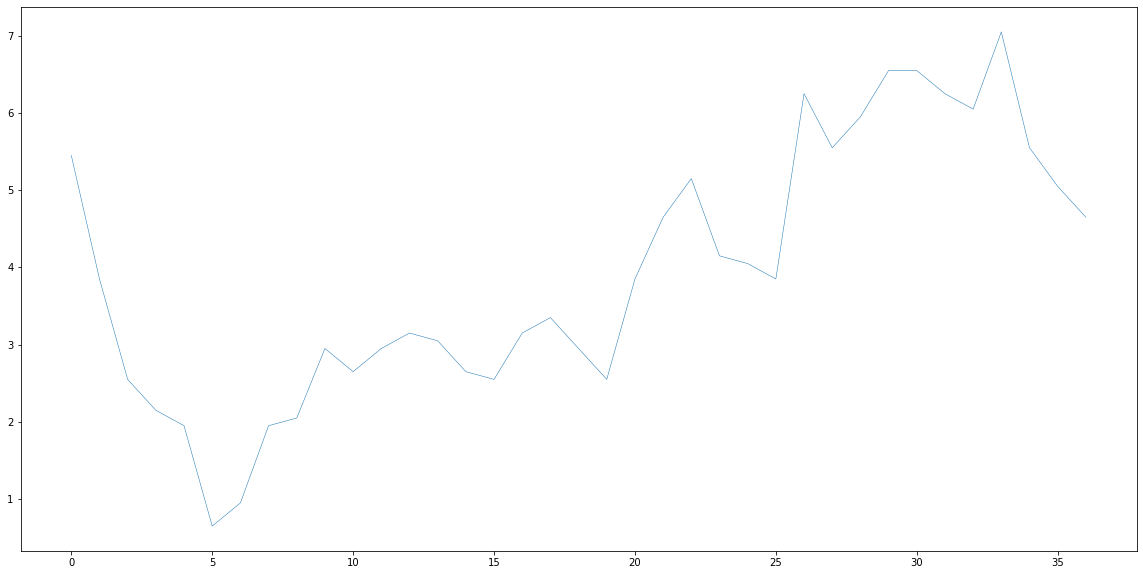

In [24]:
selection = data_array.loc['2016-03-22 18:00'][:, 0, 0]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(
    selection.forecast_hour,
    selection.values,
    linewidth=.5
)

In [23]:
data_array = data_array.dropna(dim='datetime')

ValueError: datetime must be a single dataset dimension

In [31]:
wind_speed = data_array[:, :, :, 0].drop('variable_name')
wind_direction = data_array[:, :, :, 1].drop('variable_name')

In [33]:
wind_speed.attrs = ds['si10'].attrs
wind_speed.attrs['heightAboveGround'] = 10
wind_direction.attrs = ds['wdir10'].attrs
wind_direction.attrs['heightAboveGround'] = 10

In [34]:
dataset = xr.Dataset(
    {'wind_speed': wind_speed, 'wind_direction': wind_direction},
    attrs=ds.attrs)

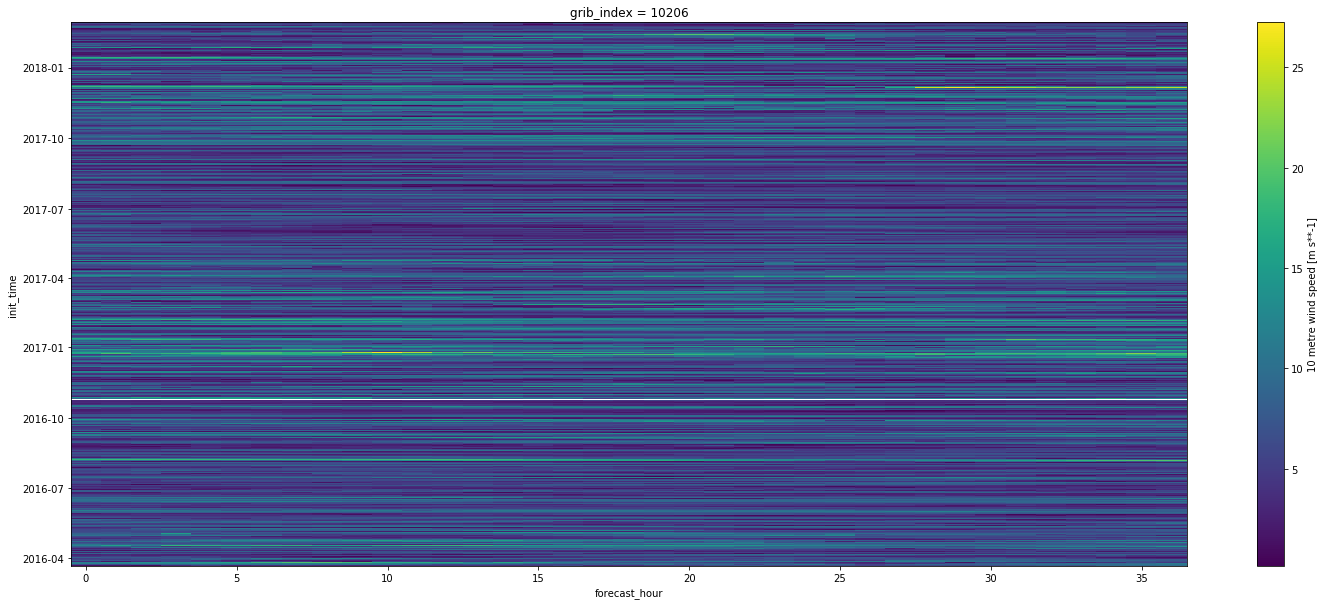

In [35]:
dataset.wind_speed.sel(grib_index=10206).plot(figsize=(25, 10), linewidth=0.5)

In [36]:
%%time

COMPRESS = False

if COMPRESS:
    COMPRESSION_ARGS = {'compression': 'gzip', 'compression_opts': 9}
    encoding = {variable: COMPRESSION_ARGS for variable in dataset}
else:
    encoding = None

dataset.to_netcdf(
    '~/data/national_grid/ukv_10m_wind_for_mpans.nc',
    encoding=encoding
)

CPU times: user 5.8 s, sys: 18.7 s, total: 24.5 s
Wall time: 31.5 s


In [100]:
import matplotlib.ticker as mticker

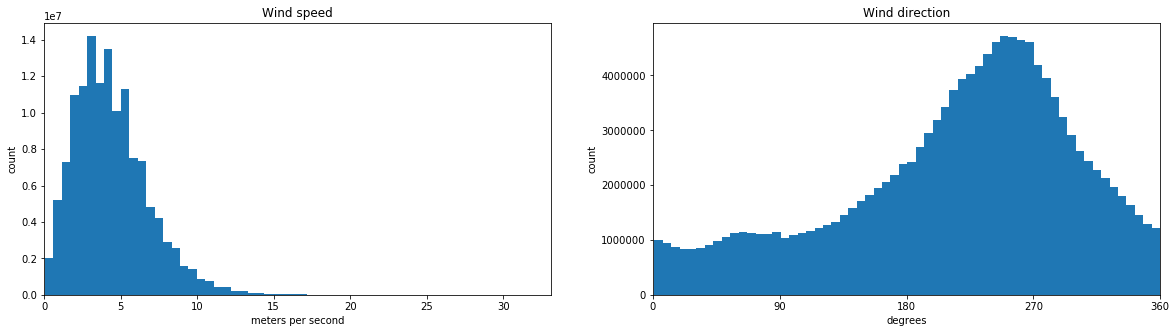

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

BINS = 60

ax = axes[0]
ax.set_title('Wind speed')
ax.set_xlabel('meters per second')
ax.set_ylabel('count')
wind_speed_flat = dataset.wind_speed.values.flatten()
ax.hist(wind_speed_flat, bins=BINS)
ax.set_xlim((0, wind_speed_flat.max()))

ax = axes[1]
ax.set_title('Wind direction')
ax.set_xlabel('degrees')
ax.set_ylabel('count')
wind_dir_flat = dataset.wind_direction.values.flatten()
ax.hist(wind_dir_flat, bins=BINS)
ax.set_xlim((0, 360))
ax.xaxis.set_major_locator(mticker.MultipleLocator(90))

In [117]:
def describe(array, unit=''):
    print('min = {:6.1f}'.format(array.min()), unit)
    print('max = {:6.1f}'.format(array.max()), unit)
    print('num unique values =', len(np.unique(array)))
    print('NaNs:', np.isnan(array).any())
    
describe(wind_speed_flat, 'm/s')

min =    0.1 m/s
max =   33.2 m/s
num unique values = 322
NaNs: False


In [118]:
describe(wind_dir_flat, 'degrees')

min =    1.0 degrees
max =  360.0 degrees
num unique values = 360
NaNs: False


In [124]:
dataset

<xarray.Dataset>
Dimensions:         (datetime: 8574, grib_index: 15559)
Coordinates:
  * datetime        (datetime) datetime64[ns] 2017-01-02 ... 2018-01-01T23:00:00
  * grib_index      (grib_index) int32 10206 10207 10754 ... 332252 332253
Data variables:
    wind_speed      (datetime, grib_index) float32 8.65 7.95 9.65 ... 6.85 6.85
    wind_direction  (datetime, grib_index) float32 343.0 337.0 ... 232.0 233.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2019-09-13T15:30:52 GRIB to CDM+CF via cfgrib-0....